In [262]:
import os
import re
import json
import pickle
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import torch
import tifffile
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram
from einops import rearrange, repeat

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.multiplex as multiplex
import mushroom.data.he as he
import mushroom.registration.bigwarp as bigwarp
from mushroom.mushroom import Mushroom

In [6]:
project_dir = '/data/estorrs/mushroom/data/projects/submission_v1'
output_dir = os.path.join(project_dir, 'analysis', 'dataset_summary')
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [7]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [8]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [9]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/nbhd_volumes.*pkl$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l0.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l1.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/nbhd_volumes_l2.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/nbhd_volumes_l0.pkl',


In [10]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/config.yaml$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/co

In [11]:
# # fix issues where antibody names aren't consistent accross some images
# channel_to_idents = {
#     'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'PanCK', 'PanCytokeratin'],
#     'E-cadherin': ['E-cadherin', 'E-Cadherin'],
#     'CD45': ['CD45'],
#     'CD45RO': ['CD45RO'],
#     'CD45RA': ['CD45RA'],
#     'CD8': ['CD8', 'CD8a'],
#     'DAPI': ['DAPI'],
#     'CD4': ['CD4'],
#     'CD3e': ['CD3e', 'CD3'],
#     'Vimentin': ['Vimentin', 'Vim', 'VIM'],
#     'SMA': ['SMA', 'a-SMA'],
#     'CD31': ['CD31'],
#     'CD20': ['CD20', 'CD20-Akoya'],
#     'CD68': ['CD68'],
#     'CD163': ['CD163'],
#     'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
#     'cKit': ['cKit', 'cKIT', 'ckit-(D)', 'ckit'],
#     'MGP': ['MGP'],
#     'CD36': ['CD36'],
#     'PR': ['PR'],
#     'ER': ['ER'],
#     'P21': ['P21'],
#     'P16': ['P16'],
#     'CK5': ['Keratin 5', 'KRT5', 'CK5'],
#     'CK7': ['CK7'],
#     'CK8/18': ['CK8/18'],
#     'TFF1': ['TFF1'],
#     'beta-integrin': ['beta-integrin', 'beta3-integrin'],
#     'CK14': ['CK14', 'Keratin 14', 'KRT14'],
#     'CK17': ['CK17', 'Keratin 17', 'CK17'],
#     'CK19': ['CK19', 'Keratin 19', 'KRT19'],
#     'CD11b': ['CD11b', 'CD11B', 'cd11b'],
#     'GATA3': ['GATA3'],
#     'PLAT/tPA': ['PLAT/tPA', 'PLAT'],
#     'COX6c': ['COX6c', 'COX6C (D)', 'COX6C'],
#     'Her2': ['Her2', 'HER2'],
#     'Bap1': ['Bap1', 'BAP1'],
#     'GLUT1': ['Glut1', 'GLUT1'],
#     'CD11c': ['CD11c'],
#     'HLA-DR': ['HLA-DR', 'HLADR'],
#     'Ki67': ['Ki67', 'KI67'],
#     'Podoplanin': ['Podoplanin', 'PDPN'],
#     'CTLA4': ['CTLA4'],
#     'SLC39A6': ['SLC39A6'],
#     'BCA1': ['BCA1'],
#     'BCAL': ['BCAL'],
#     'TUBB3': ['TUBB3'],
#     'PTPRZ1': ['PTPRZ1'],
#     'HIF1A': ['HIF1a', 'HIF1A'],
#     'PAI1': ['PAI1'],
#     'GFAP': ['GFAP'],
#     'VEGFA': ['VEGFA'],
#     'IBA1': ['IBA1'],
#     'OLIG2': ['OLIG2'],
#     'FN1': ['FN1'],
#     'a-Amylase': ['a-Amylase', 'Amylase (D', 'Amylase'],
#     'Hep-Par-1': ['Hep-Par-1', 'HepPar1-(D)', 'HepPar1'],
#     'Granzyme-B': ['Granzyme B', 'GZMB'],
#     'TCF-1': ['TCF-1'],
#     'CD39': ['CD39'],
#     'PD1': ['PD-1', 'PD1'],
#     'PDL1': ['PD-L1', 'PDL1'],
#     'Histone-H3-Pho': ['Histone H3 Pho'],
#     'Maspin': ['Maspin'],
#     'MMP9': ['MMP9'],
#     'CD44': ['CD44'],
#     'CD107A': ['CD107a'],
#     'FGFR3': ['FGFR3'],
#     'CD138': ['CD138'],
#     'MLPH': ['MLPH'],
#     'P63': ['P63', 'p63'],
#     'GP2': ['GP2'],
#     'COX2': ['COX2'],
#     'Lyve-1': ['Lyve-1', 'LYVE1'],
#     'CCL2': ['CCL2'],
#     'MUC2': ['MUC2'],
#     'SOX9': ['SOX9'],
#     'STEAP4': ['STEAP4'],
#     'AR': ['AR'],
#     'AMACR': ['AMACR'],
#     'PGC': ['PGC', 'PGC (D)'],
#     'CFTR': ['CFTR (D)', 'CFTR'],
#     'REG3A': ['REG3A (D)', 'REG3A'],
#     'LAMC2': ['LAMC2 (D)', 'LAMC2'],
#     'INS': ['INS (D)', 'INS'],
#     'CRP': ['CRP (D)', 'CRP'],
#     'CD74': ['CD74 (D)', 'CD74'],
#     'MUC5AC': ['MUC5AC (D)', 'MUC5AC'],
#     'AQP1': ['AQP1'],
#     'AQP2': ['Aqp2', 'AQP2'], 
#     'LRP2': ['LRP2'],
#     'UMOD': ['UMOD'],
#     'CALB1': ['CALB1'],
#     'CP': ['CP'],
#     'CA9': ['CA9'],
#     'UCHL1': ['UCHL1'],
# }
# channel_mapping = {v:k for k, vs in channel_to_idents.items() for v in vs}

# # add in (D) variants
# variants = ['(D)', ' (D)', '(d)', ' (d)', '-(D)', '-(d)', ' (Dnew)', '(Dnew)', '-(Dnew)']
# channel_mapping.update({k + variant:v
#                       for k, v in channel_mapping.items()
#                       for variant in variants})

In [12]:
exclude = ['S18-25943-A7', 'C3L-00970', 'WD-76845']

In [13]:
case_to_sections = {fp.split('/')[-3]:yaml.safe_load(open(fp))['sections'] for fp in fps}
case_to_sections = {k:v for k, v in case_to_sections.items() if k not in exclude}
case_to_sections.keys()

dict_keys(['C3L-00982', 'C3L-01287', 'C3L-02551', 'HT206B1', 'HT225C1', 'HT268B1', 'HT339B2-H1', 'HT397B1', 'HT413C1-K2', 'HT413C1-Th1k4A1', 'HT448C1-Th1K1Fp1', 'HT553P1-H2', 'HT565B1-H2', 'S18-5591-C8', 'S18-9906'])

In [14]:
case_meta = pd.read_csv(os.path.join(output_dir, 'case_metadata.txt'), sep='\t')
case_meta = case_meta[[True if x not in exclude else False for x in case_meta['case']]]
case_meta['n_sections'] = [len(case_to_sections[x]) for x in case_meta['case']]
case_to_disease = {k:v for k, v in zip(case_meta['case'], case_meta['tissue_type'])}
    
case_meta

case tissue_type   cohort  n_sections
1          C3L-00982       CCRCC  inhouse           5
2          C3L-01287       CCRCC  inhouse           2
3          C3L-02551       CCRCC  inhouse           5
4            HT206B1        BRCA  inhouse          15
5            HT225C1         CRC  inhouse           4
6            HT268B1        BRCA  inhouse           4
7         HT339B2-H1        BRCA  inhouse           2
8            HT397B1        BRCA  inhouse          12
9         HT413C1-K2         CRC  inhouse           2
10   HT413C1-Th1k4A1         CRC  inhouse          28
11  HT448C1-Th1K1Fp1         CRC  inhouse           4
12        HT553P1-H2        PDAC  inhouse           2
13        HT565B1-H2        BRCA  inhouse           2
14       S18-5591-C8         PKD  inhouse          14
15          S18-9906         PKD  inhouse          13

In [15]:
case_order = case_meta.sort_values(['tissue_type', 'n_sections'])['case'].to_list()
case_order

['HT339B2-H1',
 'HT565B1-H2',
 'HT268B1',
 'HT397B1',
 'HT206B1',
 'C3L-01287',
 'C3L-00982',
 'C3L-02551',
 'HT413C1-K2',
 'HT225C1',
 'HT448C1-Th1K1Fp1',
 'HT413C1-Th1k4A1',
 'HT553P1-H2',
 'S18-9906',
 'S18-5591-C8']

HT339B2-H1


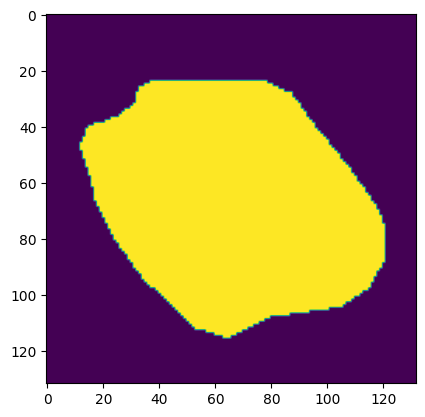

(132, 132) (2, 132, 132)
[(4, 19622, 3880), (3, 280, 0), (2, 234, 3084), (14, 126, 1402), (0, 120, 1956), (5, 86, 0), (13, 52, 672), (1, 50, 764), (11, 38, 1268), (7, 8, 294), (12, 6, 248), (8, 4, 66), (6, 4, 260), (16, 4, 98), (9, 4, 42), (18, 2, 20)]
HT565B1-H2


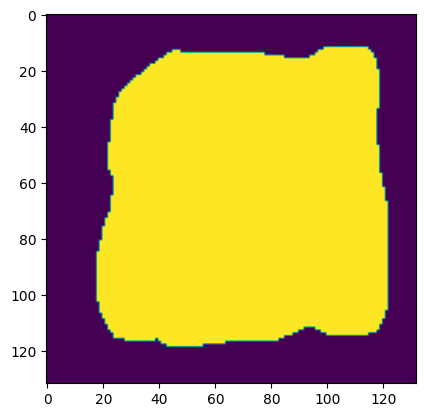

(132, 132) (3, 132, 132)
[(0, 19692, 7200), (4, 2211, 6651), (1, 579, 0)]
HT268B1


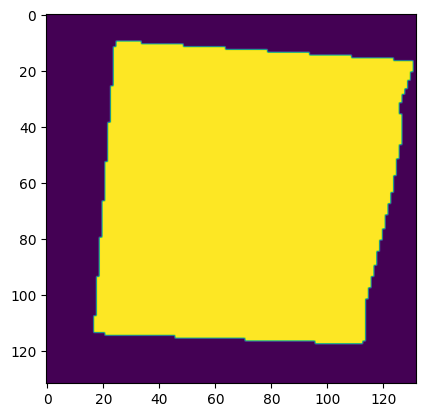

(132, 132) (32, 132, 132)
[(9, 98824, 16573), (5, 55456, 60409), (10, 51360, 1720), (0, 6999, 11083), (8, 5920, 25745), (3, 2085, 20405), (2, 715, 81215), (6, 603, 31021), (1, 333, 9471), (4, 331, 68278), (13, 125, 1506), (11, 48, 6233), (7, 17, 1028)]
HT397B1


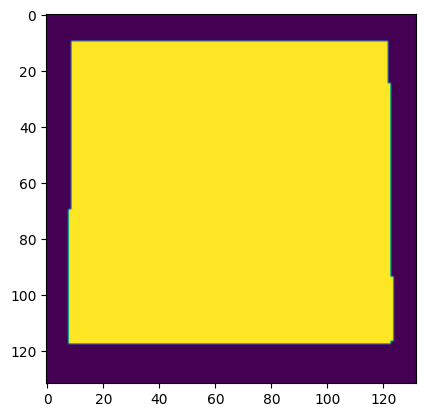

(132, 132) (31, 132, 132)
[(0, 150716, 178182), (15, 2879, 40692), (16, 1747, 17303), (12, 263, 10289), (11, 192, 11198), (1, 172, 8902), (3, 160, 22087), (2, 156, 5349), (8, 131, 933), (7, 129, 13138), (6, 107, 11416), (13, 44, 8299), (10, 35, 8039), (14, 5, 14901)]
HT206B1


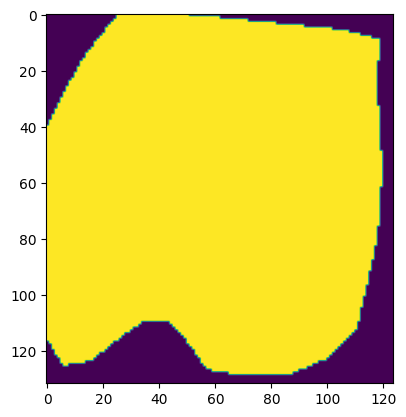

(132, 124) (25, 132, 124)
[(13, 57803, 108014), (15, 13375, 10017), (10, 22, 101822)]
C3L-01287


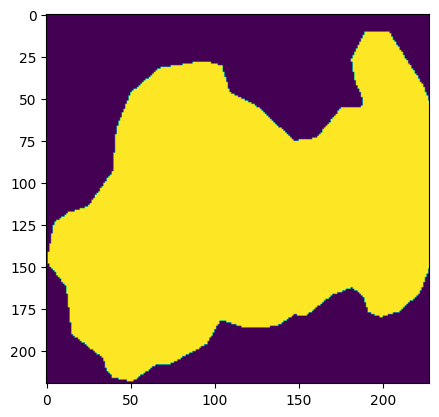

(220, 228) (2, 220, 228)
[(4, 41016, 19318), (10, 4, 2614), (14, 2, 3694)]
C3L-00982


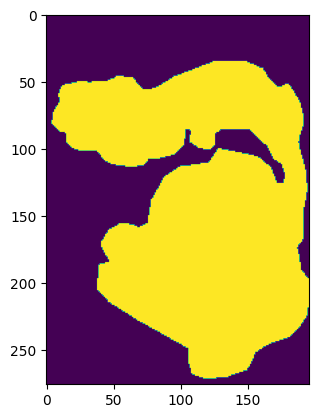

(276, 196) (7, 276, 196)
[(0, 168329, 64531), (33, 8183, 18473), (3, 819, 28650), (32, 511, 9912)]
C3L-02551


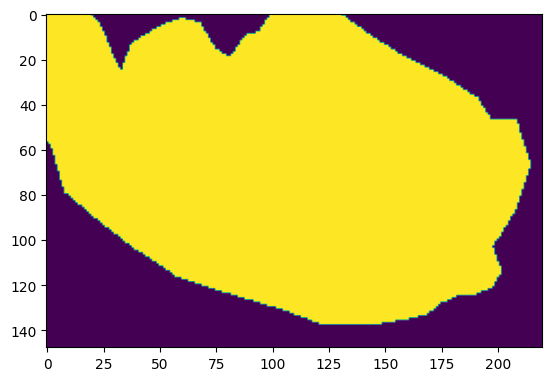

(148, 220) (8, 148, 220)
[(3, 83140, 33730), (10, 4, 176)]
HT413C1-K2


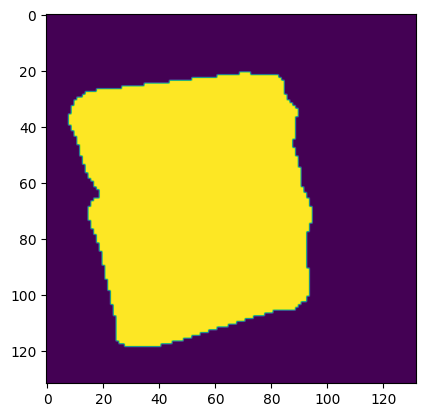

(132, 132) (2, 132, 132)
[(5, 21442, 2196), (12, 82, 0), (13, 44, 0)]
HT225C1


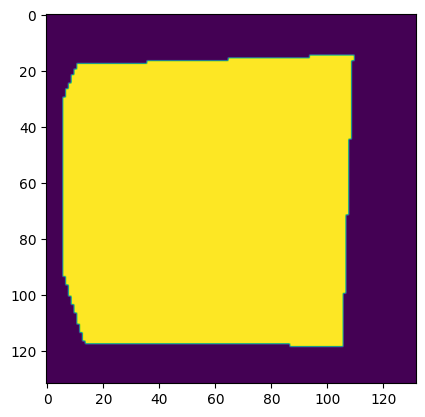

(132, 132) (37, 132, 132)
[(0, 217623, 52301), (4, 38877, 6568), (8, 3041, 42193), (3, 2374, 66155), (6, 1417, 43218), (7, 973, 36309), (2, 933, 9001), (9, 850, 28477), (1, 661, 30799), (5, 521, 24091), (12, 200, 12216), (13, 180, 7219), (11, 167, 13685), (10, 94, 3763), (14, 6, 776)]
HT448C1-Th1K1Fp1


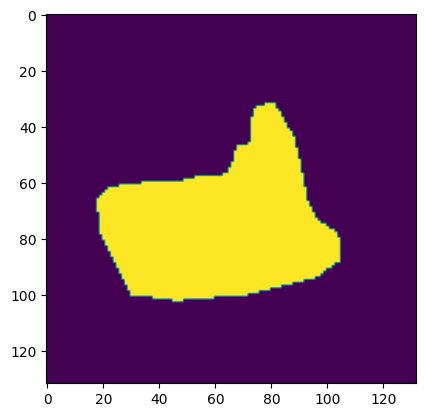

(132, 132) (14, 132, 132)
[(11, 181131, 10861), (4, 5284, 1282), (9, 3910, 13348), (1, 1352, 4106), (8, 486, 4448), (3, 481, 2282), (5, 443, 4649), (0, 247, 5970), (10, 210, 565), (12, 102, 256), (13, 52, 559), (7, 28, 1687), (2, 20, 125)]
HT413C1-Th1k4A1


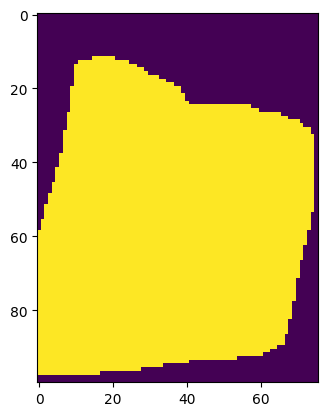

(100, 76) (42, 100, 76)
[(0, 90256, 63296), (16, 12516, 4286), (9, 2, 36142)]
HT553P1-H2


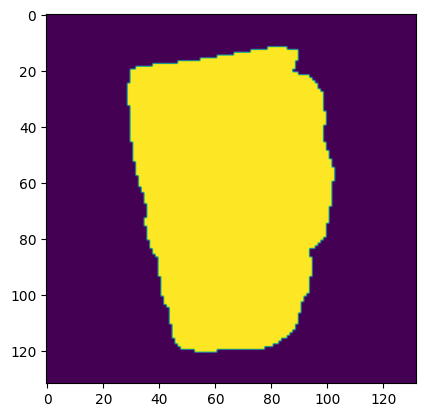

(132, 132) (2, 132, 132)
[(0, 22150, 2366), (1, 28, 0), (26, 2, 666)]
S18-9906


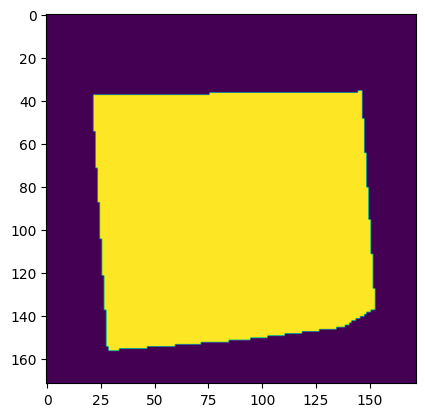

(172, 172) (33, 172, 172)
[(14, 204336, 9298), (7, 200739, 77023), (10, 40386, 52907), (3, 16908, 91570), (2, 11537, 58320), (1, 8004, 34029), (5, 7800, 52302), (13, 5147, 21593), (0, 4806, 32213), (6, 3087, 20358), (4, 1944, 16065), (12, 995, 1779), (8, 374, 853), (9, 237, 324), (11, 67, 236), (17, 37, 178), (19, 36, 234), (15, 20, 121), (18, 12, 157), (20, 6, 110), (16, 6, 118)]
S18-5591-C8


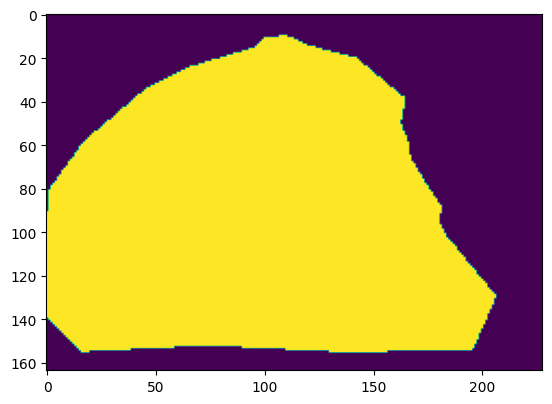

(164, 228) (24, 164, 228)
[(54, 325962, 81521), (31, 14754, 63980), (0, 9051, 121028), (30, 4948, 65577), (33, 593, 17453), (27, 550, 663), (9, 441, 76106), (26, 375, 1229), (11, 343, 561), (3, 218, 8052), (32, 180, 4), (1, 81, 22002), (25, 79, 2989), (34, 20, 31524), (4, 14, 14453), (7, 6, 2722), (10, 4, 118), (5, 3, 8502), (12, 2, 994)]


In [16]:
from collections import Counter
for case in case_order:
    print(case)
    v = pickle.load(open(
        os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb'))['labeled']['integrated']
    
    mask_fp = os.path.join(project_dir, case, 'masks', 'tissue_mask.tif')
    tissue_mask = tifffile.imread(mask_fp)
    target_size  = v.shape[1:]
    tissue_mask = utils.rescale(tissue_mask, size=target_size, dim_order='h w', target_dtype=bool)
    plt.imshow(tissue_mask)
    plt.show()
    
    mask_counts = Counter(v[..., ~tissue_mask].flatten())
    other_counts = Counter(v[..., tissue_mask].flatten())
    
    print(tissue_mask.shape, v.shape)
    print([(c, val, other_counts[c]) for c, val in mask_counts.most_common()])
    
    


In [17]:
sns.color_palette('tab20')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [483]:
case_to_background = {
    'HT339B2-H1': [4, 3],
    'HT565B1-H2': [0],
    'HT268B1': [9],
    'HT397B1': [0],
    'HT206B1': [13],
    'C3L-01287': [4],
    'C3L-00982': [0],
    'C3L-02551': [3],
    'HT413C1-K2': [5],
    'HT225C1': [0],
    'HT448C1-Th1K1Fp1': [11],
    'HT413C1-Th1k4A1': [0, 16],
    'HT553P1-H2': [0],
    'S18-9906': [14],
    'S18-5591-C8': [54]
}

In [19]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/outputs.pkl$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/outputs.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/ou

In [593]:
for case in case_order:
    print(case)
    config = yaml.safe_load(open(os.path.join(project_dir, case, 'mushroom_50res', 'config.yaml')))
    config['trainer_kwargs']['pct_expression'] = None # make sure we get all visium genes
    config['dtype_to_chkpt'] = None

    mushroom = Mushroom.from_config(
        config, accelerator='cpu'
    )
    mushroom.embed_sections()
    
    to_true_pixels = {}
    for dtype, spore in mushroom.dtype_to_spore.items():
        to_true_pixels[dtype] = {
            'channels': spore.learner_data.dtype_to_channels[dtype],
            'true_pixels': spore.true_pixels
        }
    
    pickle.dump(to_true_pixels,
                open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'wb'), protocol=4)

INFO:root:loading spore for he
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['HT339B2-H1-U1', 'HT339B2-H1-U1_dup']
INFO:root:processing sections
INFO:root:generating image data for section HT339B2-H1-U1


HT339B2-H1
0.00700525367917859


INFO:root:generating image data for section HT339B2-H1-U1_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT339B2-H1-U1', 'he'), ('HT339B2-H1-U1_dup', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading spore for multiplex
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 33 channels
INFO:root:2 sections detected: ['HT339B2-H1-U2', 'HT339B2-H1-U2_dup']
INFO:root:processing sections
INFO:root:generating image data for se

he torch.Size([3, 135, 133])
0.00700525367917859


INFO:root:generating image data for section HT339B2-H1-U2_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT339B2-H1-U2', 'multiplex'), ('HT339B2-H1-U2_dup', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading spore for visium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting visium processing


multiplex torch.Size([33, 135, 133])


INFO:root:using 17943 channels
INFO:root:2 sections detected: ['HT339B2-H1-U1', 'HT339B2-H1-U1_dup']
INFO:root:processing sections


ppm 0.35026268395892945 target_ppm 100
tiling size 285


INFO:root:generating image data for section HT339B2-H1-U1
INFO:root:generating image data for section HT339B2-H1-U1_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset


visium torch.Size([17943, 69, 68])


INFO:root:total of 2 sections detected: [('HT339B2-H1-U1', 'visium'), ('HT339B2-H1-U1_dup', 'visium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:embedding he spore
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding visium spore


Predicting: |                                                                                                 …

HT565B1-H2


INFO:root:loading spore for he
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['HT565B1-H2-U1', 'HT565B1-H2-U1_dup']
INFO:root:processing sections
INFO:root:generating image data for section HT565B1-H2-U1


0.006828392998703538


INFO:root:generating image data for section HT565B1-H2-U1_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT565B1-H2-U1', 'he'), ('HT565B1-H2-U1_dup', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 33 channels
INFO:root:2 sections detected: ['HT565B1-H2-U2', 'HT565B1-H2-U2_dup']
INFO:root:processing sections
INFO:root:generating image data for section HT565B1-H2-U2


he torch.Size([3, 135, 133])
0.006828392998703538


INFO:root:generating image data for section HT565B1-H2-U2_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT565B1-H2-U2', 'multiplex'), ('HT565B1-H2-U2_dup', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading spore for visium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting visium processing


multiplex torch.Size([33, 135, 133])


INFO:root:using 17943 channels
INFO:root:2 sections detected: ['HT565B1-H2-U1', 'HT565B1-H2-U1_dup']
INFO:root:processing sections


ppm 0.3414196499351769 target_ppm 100
tiling size 292


INFO:root:generating image data for section HT565B1-H2-U1
INFO:root:generating image data for section HT565B1-H2-U1_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset


visium torch.Size([17943, 69, 68])


INFO:root:total of 2 sections detected: [('HT565B1-H2-U1', 'visium'), ('HT565B1-H2-U1_dup', 'visium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:embedding he spore
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding visium spore


Predicting: |                                                                                                 …

INFO:root:loading spore for he


HT268B1


INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:4 sections detected: ['HT268B1-U2', 'HT268B1-U12', 'HT268B1-U22', 'HT268B1-U32']
INFO:root:processing sections
INFO:root:generating image data for section HT268B1-U2


0.007004457303449433


INFO:root:generating image data for section HT268B1-U12
INFO:root:generating image data for section HT268B1-U22
INFO:root:generating image data for section HT268B1-U32
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 4 sections detected: [('HT268B1-U2', 'he'), ('HT268B1-U12', 'he'), ('HT268B1-U22', 'he'), ('HT268B1-U32', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for visium
INFO:root:data mask detected
INFO:root:starting visium processing


he torch.Size([3, 135, 133])


INFO:root:using 36601 channels
INFO:root:4 sections detected: ['HT268B1-U2', 'HT268B1-U12', 'HT268B1-U22', 'HT268B1-U32']
INFO:root:processing sections


ppm 0.35022286517247164 target_ppm 100
tiling size 285


INFO:root:generating image data for section HT268B1-U2
INFO:root:generating image data for section HT268B1-U12
INFO:root:generating image data for section HT268B1-U22
INFO:root:generating image data for section HT268B1-U32


visium torch.Size([36601, 68, 68])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 4 sections detected: [('HT268B1-U2', 'visium'), ('HT268B1-U12', 'visium'), ('HT268B1-U22', 'visium'), ('HT268B1-U32', 'visium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:embedding he spore
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve p

Predicting: |                                                                                                 …

INFO:root:embedding visium spore


Predicting: |                                                                                                 …

HT397B1


INFO:root:loading spore for batch2_he
INFO:root:data mask detected
INFO:root:starting batch2_he processing
INFO:root:6 sections detected: ['HT397B1-U4', 'HT397B1-U8', 'HT397B1-U11', 'HT397B1-U16', 'HT397B1-U20', 'HT397B1-U28']
INFO:root:processing sections
INFO:root:generating image data for section HT397B1-U4


0.007287140063108625


INFO:root:generating image data for section HT397B1-U8
INFO:root:generating image data for section HT397B1-U11
INFO:root:generating image data for section HT397B1-U16
INFO:root:generating image data for section HT397B1-U20
INFO:root:generating image data for section HT397B1-U28
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 6 sections detected: [('HT397B1-U4', 'batch2_he'), ('HT397B1-U8', 'batch2_he'), ('HT397B1-U11', 'batch2_he'), ('HT397B1-U16', 'batch2_he'), ('HT397B1-U20', 'batch2_he'), ('HT397B1-U28', 'batch2_he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['HT397B1-U1', 'HT397B1-U21']
INFO:root:processing sections
INFO:

batch2_he torch.Size([3, 135, 133])
0.007287140063108625


INFO:root:generating image data for section HT397B1-U21
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT397B1-U1', 'he'), ('HT397B1-U21', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 24 channels
INFO:root:4 sections detected: ['HT397B1-U2', 'HT397B1-U12', 'HT397B1-U22', 'HT397B1-U31']
INFO:root:processing sections
INFO:root:generating image data for section HT397B1-U2


he torch.Size([3, 135, 133])
0.007287140063108625


INFO:root:generating image data for section HT397B1-U12
INFO:root:generating image data for section HT397B1-U22
INFO:root:generating image data for section HT397B1-U31
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 4 sections detected: [('HT397B1-U2', 'multiplex'), ('HT397B1-U12', 'multiplex'), ('HT397B1-U22', 'multiplex'), ('HT397B1-U31', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading spore for visium
INFO:root:data mask detected
INFO:root:starting visium processing


multiplex torch.Size([24, 135, 133])


INFO:root:using 17943 channels
INFO:root:2 sections detected: ['HT397B1-U1', 'HT397B1-U21']
INFO:root:processing sections


ppm 0.36435700315543124 target_ppm 100
tiling size 274


INFO:root:generating image data for section HT397B1-U1
INFO:root:generating image data for section HT397B1-U21
INFO:root:generating training dataset
INFO:root:generating inference dataset


visium torch.Size([17943, 69, 68])


INFO:root:total of 2 sections detected: [('HT397B1-U1', 'visium'), ('HT397B1-U21', 'visium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:embedding batch2_he spore
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding he spore


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding visium spore


Predicting: |                                                                                                 …

HT206B1


INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:3 sections detected: ['HT206B1-U4', 'HT206B1-U12', 'HT206B1-U20']
INFO:root:processing sections
INFO:root:generating image data for section HT206B1-U4


0.02


INFO:root:generating image data for section HT206B1-U12
INFO:root:generating image data for section HT206B1-U20
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 3 sections detected: [('HT206B1-U4', 'he'), ('HT206B1-U12', 'he'), ('HT206B1-U20', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 36 channels
INFO:root:6 sections detected: ['HT206B1-U2', 'HT206B1-U5', 'HT206B1-U10', 'HT206B1-U13', 'HT206B1-U18', 'HT206B1-U21']
INFO:root:processing sections
INFO:root:generating image data for section HT206B1-U2


he torch.Size([3, 130, 121])
0.02


INFO:root:generating image data for section HT206B1-U5
INFO:root:generating image data for section HT206B1-U10
INFO:root:generating image data for section HT206B1-U13
INFO:root:generating image data for section HT206B1-U18
INFO:root:generating image data for section HT206B1-U21
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 6 sections detected: [('HT206B1-U2', 'multiplex'), ('HT206B1-U5', 'multiplex'), ('HT206B1-U10', 'multiplex'), ('HT206B1-U13', 'multiplex'), ('HT206B1-U18', 'multiplex'), ('HT206B1-U21', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

multiplex torch.Size([36, 130, 121])


INFO:root:using 377 channels
INFO:root:6 sections detected: ['HT206B1-U1', 'HT206B1-U8', 'HT206B1-U9', 'HT206B1-U16', 'HT206B1-U17', 'HT206B1-U24']
INFO:root:processing sections
INFO:root:generating image data for section HT206B1-U1
INFO:root:generating image data for section HT206B1-U8
INFO:root:generating image data for section HT206B1-U9
INFO:root:generating image data for section HT206B1-U16
INFO:root:generating image data for section HT206B1-U17
INFO:root:generating image data for section HT206B1-U24
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 6 sections detected: [('HT206B1-U1', 'xenium'), ('HT206B1-U8', 'xenium'), ('HT206B1-U9', 'xenium'), ('HT206B1-U16', 'xenium'), ('HT206B1-U17', 'xenium'), ('HT206B1-U24', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU availabl

xenium torch.Size([377, 131, 122])


/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore


Predicting: |                                                                                                 …

INFO:root:loading spore for multiplex
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 29 channels
INFO:root:2 sections detected: ['C3L-01287-U2', 'C3L-01287-U2_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-01287-U2


C3L-01287
0.02


INFO:root:generating image data for section C3L-01287-U2_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-01287-U2', 'multiplex'), ('C3L-01287-U2_dup', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing


multiplex torch.Size([29, 217, 229])


INFO:root:using 477 channels
INFO:root:2 sections detected: ['C3L-01287-U1', 'C3L-01287-U1_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-01287-U1
INFO:root:generating image data for section C3L-01287-U1_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-01287-U1', 'xenium'), ('C3L-01287-U1_dup', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:embedding multiplex spore


xenium torch.Size([477, 218, 230])


/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore


Predicting: |                                                                                                 …

INFO:root:loading spore for he
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['C3L-00982-U5', 'C3L-00982-U5_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-00982-U5


C3L-00982
0.02


INFO:root:generating image data for section C3L-00982-U5_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-00982-U5', 'he'), ('C3L-00982-U5_dup', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 32 channels
INFO:root:3 sections detected: ['C3L-00982-U1', 'C3L-00982-U4', 'C3L-00982-U7']
INFO:root:processing sections
INFO:root:generating image data for section C3L-00982-U1


he torch.Size([3, 274, 193])
0.02


INFO:root:generating image data for section C3L-00982-U4
INFO:root:generating image data for section C3L-00982-U7
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 3 sections detected: [('C3L-00982-U1', 'multiplex'), ('C3L-00982-U4', 'multiplex'), ('C3L-00982-U7', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing


multiplex torch.Size([32, 274, 193])


INFO:root:using 477 channels
INFO:root:2 sections detected: ['C3L-00982-U2', 'C3L-00982-U2_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-00982-U2
INFO:root:generating image data for section C3L-00982-U2_dup


xenium torch.Size([477, 275, 194])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-00982-U2', 'xenium'), ('C3L-00982-U2_dup', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:embedding he spore
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore


Predicting: |                                                                                                 …

INFO:root:loading spore for he
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['C3L-02551-U7', 'C3L-02551-U7_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-02551-U7


C3L-02551
0.02


INFO:root:generating image data for section C3L-02551-U7_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-02551-U7', 'he'), ('C3L-02551-U7_dup', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 32 channels
INFO:root:3 sections detected: ['C3L-02551-U1', 'C3L-02551-U4', 'C3L-02551-U8']
INFO:root:processing sections
INFO:root:generating image data for section C3L-02551-U1


he torch.Size([3, 144, 217])
0.02


INFO:root:generating image data for section C3L-02551-U4
INFO:root:generating image data for section C3L-02551-U8
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 3 sections detected: [('C3L-02551-U1', 'multiplex'), ('C3L-02551-U4', 'multiplex'), ('C3L-02551-U8', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing


multiplex torch.Size([32, 144, 217])


INFO:root:using 477 channels
INFO:root:2 sections detected: ['C3L-02551-U3', 'C3L-02551-U3_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-02551-U3
INFO:root:generating image data for section C3L-02551-U3_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-02551-U3', 'xenium'), ('C3L-02551-U3_dup', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:embedding he spore


xenium torch.Size([477, 145, 218])


/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore


Predicting: |                                                                                                 …

INFO:root:loading spore for he
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['HT413C1-K2-U1', 'HT413C1-K2-U1_dup']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-K2-U1


HT413C1-K2
0.007096906213045373


INFO:root:generating image data for section HT413C1-K2-U1_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT413C1-K2-U1', 'he'), ('HT413C1-K2-U1_dup', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 33 channels
INFO:root:2 sections detected: ['HT413C1-K2-U2', 'HT413C1-K2-U2_dup']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-K2-U2


he torch.Size([3, 135, 133])
0.007096906213045373


INFO:root:generating image data for section HT413C1-K2-U2_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT413C1-K2-U2', 'multiplex'), ('HT413C1-K2-U2_dup', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading spore for visium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting visium processing


multiplex torch.Size([33, 135, 133])


INFO:root:using 17943 channels
INFO:root:2 sections detected: ['HT413C1-K2-U1', 'HT413C1-K2-U1_dup']
INFO:root:processing sections


ppm 0.35484531065226865 target_ppm 100
tiling size 281


INFO:root:generating image data for section HT413C1-K2-U1
INFO:root:generating image data for section HT413C1-K2-U1_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset


visium torch.Size([17943, 69, 68])


INFO:root:total of 2 sections detected: [('HT413C1-K2-U1', 'visium'), ('HT413C1-K2-U1_dup', 'visium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:embedding he spore
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding visium spore


Predicting: |                                                                                                 …

INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:4 sections detected: ['HT225C1-U2', 'HT225C1-U3', 'HT225C1-U4', 'HT225C1-U5']
INFO:root:processing sections
INFO:root:generating image data for section HT225C1-U2


HT225C1
0.006812610468866041


INFO:root:generating image data for section HT225C1-U3
INFO:root:generating image data for section HT225C1-U4
INFO:root:generating image data for section HT225C1-U5
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 4 sections detected: [('HT225C1-U2', 'he'), ('HT225C1-U3', 'he'), ('HT225C1-U4', 'he'), ('HT225C1-U5', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for visium
INFO:root:data mask detected
INFO:root:starting visium processing


he torch.Size([3, 135, 133])


INFO:root:using 36601 channels
INFO:root:4 sections detected: ['HT225C1-U2', 'HT225C1-U3', 'HT225C1-U4', 'HT225C1-U5']
INFO:root:processing sections


ppm 0.340630523443302 target_ppm 100
tiling size 293


INFO:root:generating image data for section HT225C1-U2
INFO:root:generating image data for section HT225C1-U3
INFO:root:generating image data for section HT225C1-U4
INFO:root:generating image data for section HT225C1-U5


visium torch.Size([36601, 68, 68])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 4 sections detected: [('HT225C1-U2', 'visium'), ('HT225C1-U3', 'visium'), ('HT225C1-U4', 'visium'), ('HT225C1-U5', 'visium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:embedding he spore
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve perf

Predicting: |                                                                                                 …

INFO:root:embedding visium spore


Predicting: |                                                                                                 …

INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['HT448C1-Th1K1Fp1-U1', 'HT448C1-Th1K1Fp1-U13']
INFO:root:processing sections
INFO:root:generating image data for section HT448C1-Th1K1Fp1-U1


HT448C1-Th1K1Fp1
0.007292096259888302


INFO:root:generating image data for section HT448C1-Th1K1Fp1-U13
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT448C1-Th1K1Fp1-U1', 'he'), ('HT448C1-Th1K1Fp1-U13', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 17 channels
INFO:root:2 sections detected: ['HT448C1-Th1K1Fp1-U2', 'HT448C1-Th1K1Fp1-U14']
INFO:root:processing sections
INFO:root:generating image data for section HT448C1-Th1K1Fp1-U2


he torch.Size([3, 135, 134])
0.007292096259888302


INFO:root:generating image data for section HT448C1-Th1K1Fp1-U14
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT448C1-Th1K1Fp1-U2', 'multiplex'), ('HT448C1-Th1K1Fp1-U14', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading spore for visium
INFO:root:data mask detected
INFO:root:starting visium processing


multiplex torch.Size([17, 135, 134])


INFO:root:using 17943 channels
INFO:root:2 sections detected: ['HT448C1-Th1K1Fp1-U1', 'HT448C1-Th1K1Fp1-U13']
INFO:root:processing sections


ppm 0.3646048129944151 target_ppm 100
tiling size 274


INFO:root:generating image data for section HT448C1-Th1K1Fp1-U1
INFO:root:generating image data for section HT448C1-Th1K1Fp1-U13
INFO:root:generating training dataset
INFO:root:generating inference dataset


visium torch.Size([17943, 68, 68])


INFO:root:total of 2 sections detected: [('HT448C1-Th1K1Fp1-U1', 'visium'), ('HT448C1-Th1K1Fp1-U13', 'visium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:embedding he spore
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding visium spore


Predicting: |                                                                                                 …

HT413C1-Th1k4A1


INFO:root:loading spore for cosmx
INFO:root:data mask detected
INFO:root:starting cosmx processing
INFO:root:using 1000 channels
INFO:root:2 sections detected: ['HT413C1-Th1k4A1-U7', 'HT413C1-Th1k4A1-U34']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-Th1k4A1-U7
INFO:root:generating image data for section HT413C1-Th1k4A1-U34
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT413C1-Th1k4A1-U7', 'cosmx'), ('HT413C1-Th1k4A1-U34', 'cosmx')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading spore fo

cosmx torch.Size([1000, 102, 73])
0.02


INFO:root:generating image data for section HT413C1-Th1k4A1-U18
INFO:root:generating image data for section HT413C1-Th1k4A1-U1
INFO:root:generating image data for section HT413C1-Th1k4A1-U4
INFO:root:generating image data for section HT413C1-Th1k4A1-U8
INFO:root:generating image data for section HT413C1-Th1k4A1-U11
INFO:root:generating image data for section HT413C1-Th1k4A1-U21
INFO:root:generating image data for section HT413C1-Th1k4A1-U24
INFO:root:generating image data for section HT413C1-Th1k4A1-U27
INFO:root:generating image data for section HT413C1-Th1k4A1-U29
INFO:root:generating image data for section HT413C1-Th1k4A1-U30
INFO:root:generating image data for section HT413C1-Th1k4A1-U35
INFO:root:generating image data for section HT413C1-Th1k4A1-U38
INFO:root:generating image data for section HT413C1-Th1k4A1-U40
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 14 sections detected: [('HT413C1-Th1k4A1-U14', 'he'), ('HT413C1-Th1k4A1-U18

he torch.Size([3, 101, 72])
0.02


INFO:root:generating image data for section HT413C1-Th1k4A1-U3
INFO:root:generating image data for section HT413C1-Th1k4A1-U26
INFO:root:generating image data for section HT413C1-Th1k4A1-U32
INFO:root:generating image data for section HT413C1-Th1k4A1-U37
INFO:root:generating image data for section HT413C1-Th1k4A1-U41
INFO:root:generating image data for section HT413C1-Th1k4A1-U42
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 7 sections detected: [('HT413C1-Th1k4A1-U20', 'multiplex'), ('HT413C1-Th1k4A1-U3', 'multiplex'), ('HT413C1-Th1k4A1-U26', 'multiplex'), ('HT413C1-Th1k4A1-U32', 'multiplex'), ('HT413C1-Th1k4A1-U37', 'multiplex'), ('HT413C1-Th1k4A1-U41', 'multiplex'), ('HT413C1-Th1k4A1-U42', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPU

multiplex torch.Size([27, 101, 72])


INFO:root:using 477 channels
INFO:root:5 sections detected: ['HT413C1-Th1k4A1-U19', 'HT413C1-Th1k4A1-U2', 'HT413C1-Th1k4A1-U9', 'HT413C1-Th1k4A1-U25', 'HT413C1-Th1k4A1-U36']
INFO:root:processing sections
INFO:root:generating image data for section HT413C1-Th1k4A1-U19
INFO:root:generating image data for section HT413C1-Th1k4A1-U2
INFO:root:generating image data for section HT413C1-Th1k4A1-U9
INFO:root:generating image data for section HT413C1-Th1k4A1-U25
INFO:root:generating image data for section HT413C1-Th1k4A1-U36
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 5 sections detected: [('HT413C1-Th1k4A1-U19', 'xenium'), ('HT413C1-Th1k4A1-U2', 'xenium'), ('HT413C1-Th1k4A1-U9', 'xenium'), ('HT413C1-Th1k4A1-U25', 'xenium'), ('HT413C1-Th1k4A1-U36', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, u

xenium torch.Size([477, 102, 73])


/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding he spore


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore


Predicting: |                                                                                                 …

INFO:root:loading spore for he
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['HT553P1-H2-U1', 'HT553P1-H2-U1_dup']
INFO:root:processing sections
INFO:root:generating image data for section HT553P1-H2-U1


HT553P1-H2
0.007004240418570933


INFO:root:generating image data for section HT553P1-H2-U1_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT553P1-H2-U1', 'he'), ('HT553P1-H2-U1_dup', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 33 channels
INFO:root:2 sections detected: ['HT553P1-H2-U2', 'HT553P1-H2-U2_dup']
INFO:root:processing sections
INFO:root:generating image data for section HT553P1-H2-U2


he torch.Size([3, 135, 133])
0.007004240418570933


INFO:root:generating image data for section HT553P1-H2-U2_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT553P1-H2-U2', 'multiplex'), ('HT553P1-H2-U2_dup', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading spore for visium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting visium processing


multiplex torch.Size([33, 135, 133])


INFO:root:using 17943 channels
INFO:root:2 sections detected: ['HT553P1-H2-U1', 'HT553P1-H2-U1_dup']
INFO:root:processing sections


ppm 0.3502120209285467 target_ppm 100
tiling size 285


INFO:root:generating image data for section HT553P1-H2-U1
INFO:root:generating image data for section HT553P1-H2-U1_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset


visium torch.Size([17943, 69, 68])


INFO:root:total of 2 sections detected: [('HT553P1-H2-U1', 'visium'), ('HT553P1-H2-U1_dup', 'visium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:embedding he spore
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding visium spore


Predicting: |                                                                                                 …

INFO:root:loading spore for batch2_he
INFO:root:data mask detected
INFO:root:starting batch2_he processing
INFO:root:3 sections detected: ['S18-9906-U5', 'S18-9906-U12', 'S18-9906-U20']
INFO:root:processing sections
INFO:root:generating image data for section S18-9906-U5


S18-9906
0.02


INFO:root:generating image data for section S18-9906-U12
INFO:root:generating image data for section S18-9906-U20
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 3 sections detected: [('S18-9906-U5', 'batch2_he'), ('S18-9906-U12', 'batch2_he'), ('S18-9906-U20', 'batch2_he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['S18-9906-U1', 'S18-9906-U16']
INFO:root:processing sections
INFO:root:generating image data for section S18-9906-U1


batch2_he torch.Size([3, 173, 169])
0.02


INFO:root:generating image data for section S18-9906-U16
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('S18-9906-U1', 'he'), ('S18-9906-U16', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 24 channels
INFO:root:4 sections detected: ['S18-9906-U3', 'S18-9906-U10', 'S18-9906-U18', 'S18-9906-U25']
INFO:root:processing sections
INFO:root:generating image data for section S18-9906-U3


he torch.Size([3, 173, 169])
0.02


INFO:root:generating image data for section S18-9906-U10
INFO:root:generating image data for section S18-9906-U18
INFO:root:generating image data for section S18-9906-U25
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 4 sections detected: [('S18-9906-U3', 'multiplex'), ('S18-9906-U10', 'multiplex'), ('S18-9906-U18', 'multiplex'), ('S18-9906-U25', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading spore for visium
INFO:root:data mask detected
INFO:root:starting visium processing


multiplex torch.Size([24, 173, 169])


INFO:root:using 17943 channels
INFO:root:2 sections detected: ['S18-9906-U1', 'S18-9906-U16']
INFO:root:processing sections


ppm 1.0 target_ppm 100
tiling size 100


INFO:root:generating image data for section S18-9906-U1
INFO:root:generating image data for section S18-9906-U16


visium torch.Size([17943, 87, 85])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('S18-9906-U1', 'visium'), ('S18-9906-U16', 'visium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading spore for xenium
INFO:root:data mask detected
INFO:root:starting xenium processing
INFO:root:using 377 channels
INFO:root:4 sections detected: ['S18-9906-U2', 'S18-9906-U9', 'S18-9906-U17', 'S18-9906-U24']
INFO:root:processing sections
INFO:root:generating image data for section S18-9906-U2
INFO:root:generating image data for section S18-9906-U9
INFO:root:generating image data for

xenium torch.Size([377, 174, 170])


/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding he spore


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding visium spore


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore


Predicting: |                                                                                                 …

S18-5591-C8


INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['S18-5591-C8-U3', 'S18-5591-C8-U9']
INFO:root:processing sections
INFO:root:generating image data for section S18-5591-C8-U3


0.02


INFO:root:generating image data for section S18-5591-C8-U9
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('S18-5591-C8-U3', 'he'), ('S18-5591-C8-U9', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 24 channels
INFO:root:6 sections detected: ['S18-5591-C8-U8', 'S18-5591-C8-U14', 'S18-5591-C8-U19', 'S18-5591-C8-U21', 'S18-5591-C8-U23', 'S18-5591-C8-U24']
INFO:root:processing sections
INFO:root:generating image data for section S18-5591-C8-U8


he torch.Size([3, 159, 229])
0.02


INFO:root:generating image data for section S18-5591-C8-U14
INFO:root:generating image data for section S18-5591-C8-U19
INFO:root:generating image data for section S18-5591-C8-U21
INFO:root:generating image data for section S18-5591-C8-U23
INFO:root:generating image data for section S18-5591-C8-U24
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 6 sections detected: [('S18-5591-C8-U8', 'multiplex'), ('S18-5591-C8-U14', 'multiplex'), ('S18-5591-C8-U19', 'multiplex'), ('S18-5591-C8-U21', 'multiplex'), ('S18-5591-C8-U23', 'multiplex'), ('S18-5591-C8-U24', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can

multiplex torch.Size([24, 159, 229])


INFO:root:using 477 channels
INFO:root:6 sections detected: ['S18-5591-C8-U1', 'S18-5591-C8-U5', 'S18-5591-C8-U7', 'S18-5591-C8-U12', 'S18-5591-C8-U18', 'S18-5591-C8-U20']
INFO:root:processing sections
INFO:root:generating image data for section S18-5591-C8-U1
INFO:root:generating image data for section S18-5591-C8-U5
INFO:root:generating image data for section S18-5591-C8-U7
INFO:root:generating image data for section S18-5591-C8-U12
INFO:root:generating image data for section S18-5591-C8-U18
INFO:root:generating image data for section S18-5591-C8-U20
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 6 sections detected: [('S18-5591-C8-U1', 'xenium'), ('S18-5591-C8-U5', 'xenium'), ('S18-5591-C8-U7', 'xenium'), ('S18-5591-C8-U12', 'xenium'), ('S18-5591-C8-U18', 'xenium'), ('S18-5591-C8-U20', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT


xenium torch.Size([477, 160, 230])


INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:embedding he spore
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore


Predicting: |                                                                                                 …

In [603]:
case_to_exp = {}
for case in case_order:
    print(case)
    dtype_to_true_pixels = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'rb')
    )
    
    dtypes = [dt for dt in dtype_to_true_pixels.keys() if dt != 'integrated']
    dtype_to_exp = {}
    for dtype in dtypes:    
        channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
        true_pixels = np.stack(true_pixels)

        volume = pickle.load(
            open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
        )['labeled']['integrated']

        outputs = pickle.load(
            open(os.path.join(project_dir, case, 'mushroom_50res', f'outputs.pkl'), 'rb')
        )
        section_ids = outputs['section_ids']
        section_positions = outputs['section_positions']
        positions = [i for i, (sid, dt) in zip(section_positions, section_ids) if dt==dtype]
        volume = volume[positions]

        data = []
        for label in np.unique(volume):
            data.append(true_pixels[volume==label].mean(0))
        exp_df = pd.DataFrame(data=data, columns=channels, index=np.unique(volume))
        dtype_to_exp[dtype] = exp_df
    
    case_to_exp[case] = dtype_to_exp
    
    

HT339B2-H1
HT565B1-H2
HT268B1
HT397B1
HT206B1
C3L-01287
C3L-00982
C3L-02551
HT413C1-K2
HT225C1
HT448C1-Th1K1Fp1
HT413C1-Th1k4A1
HT553P1-H2
S18-9906
S18-5591-C8


In [26]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/true_pixels.pkl$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/true_pixels.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_50res/true_pixels.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_50res/true_pixels.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/true_pixels.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_50res/true_pixels.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/true_pixels.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/true_pixels.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/true_pixels.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_50res/true_pixels.pkl',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_50res/true_pixels.pkl',
 '/data/estorrs/mushroom/data/projects/s

In [27]:
case_order

['HT339B2-H1',
 'HT565B1-H2',
 'HT268B1',
 'HT397B1',
 'HT206B1',
 'C3L-01287',
 'C3L-00982',
 'C3L-02551',
 'HT413C1-K2',
 'HT225C1',
 'HT448C1-Th1K1Fp1',
 'HT413C1-Th1k4A1',
 'HT553P1-H2',
 'S18-9906',
 'S18-5591-C8']

In [96]:
masking_dtype_order = [
    'xenium',
    'multiplex',
    'visium',
]
dtype_to_mask_channel = {
    'multiplex': 'Pan-Cytokeratin',
    'xenium': 'EPCAM',
    'visium': 'EPCAM'
}

dtype_to_mask_channel_ccrcc = {
    'multiplex': ['CA9', 'LRP2'],
    'xenium': ['CA9', 'LRP2'],
    'visium': ['CA9', 'LRP2'],
}

case_to_thresh = {
    'HT339B2-H1': 1.5,
    'HT565B1-H2': 1.5,
    'HT268B1': .75,
    'HT397B1': 1.5,
    'HT206B1': 1.5,
    'C3L-01287': 1.0,
    'C3L-00982': 1.0,
    'C3L-02551': 1.0,
    'HT413C1-K2': 1.0,
    'HT225C1': .75,
    'HT448C1-Th1K1Fp1': 1.5,
    'HT413C1-Th1k4A1': 1.25,
    'HT553P1-H2': 1.5,
    'S18-9906': 1.25,
    'S18-5591-C8': 1.25
}

HT339B2-H1


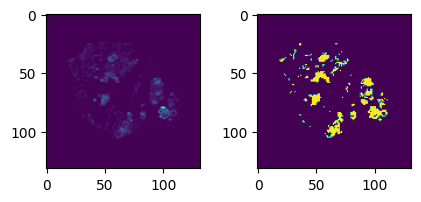

HT565B1-H2


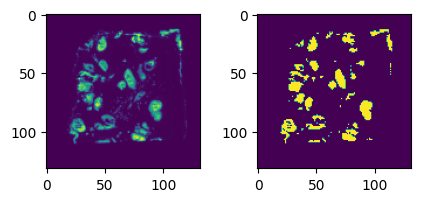

HT268B1


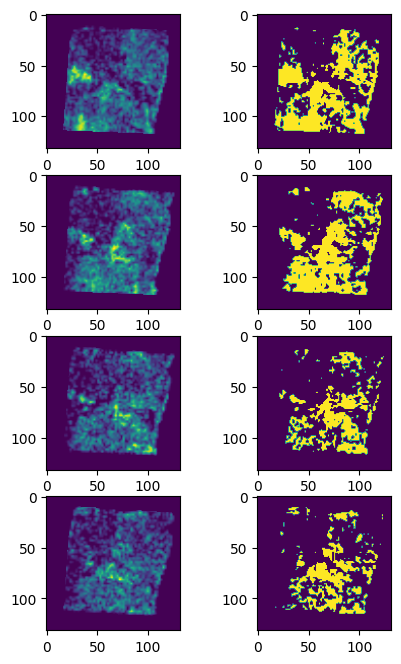

HT397B1


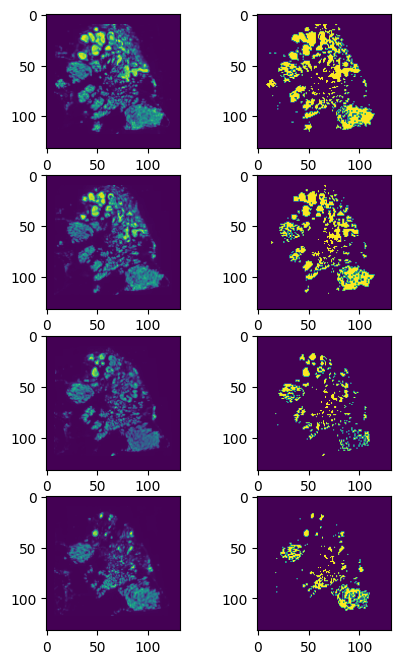

HT206B1


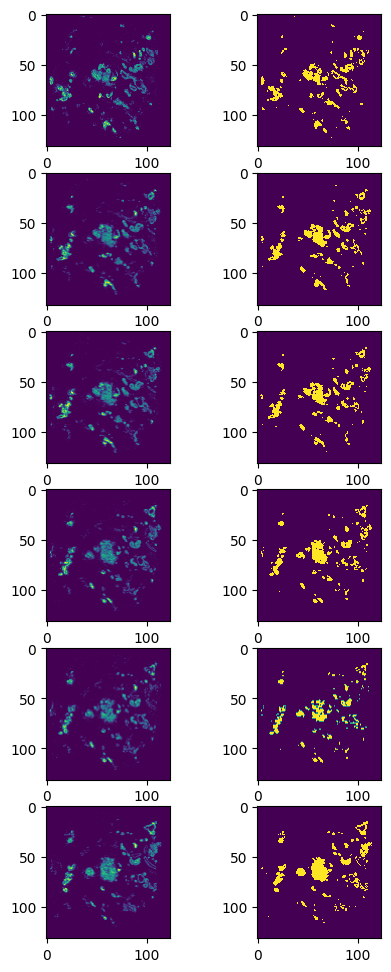

C3L-01287


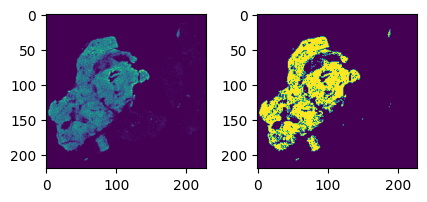

C3L-00982


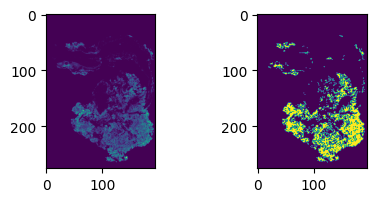

C3L-02551


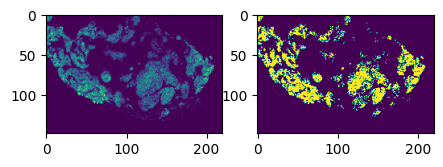

HT413C1-K2


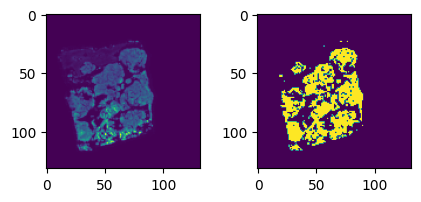

HT225C1


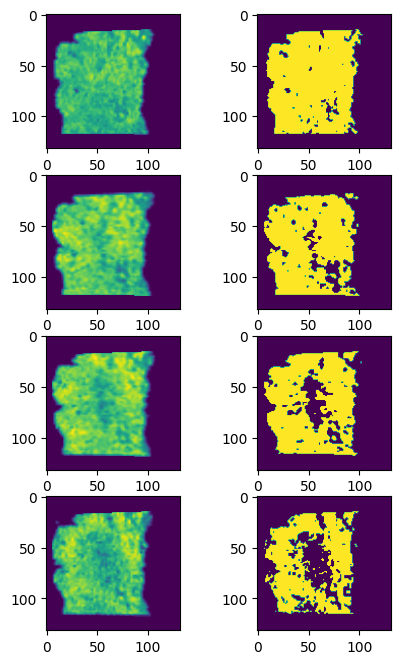

HT448C1-Th1K1Fp1


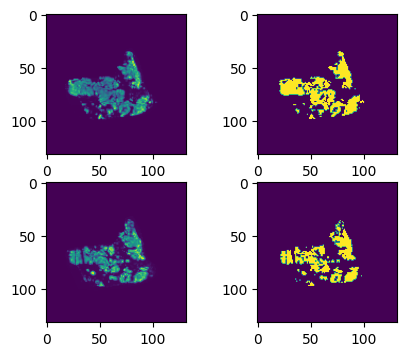

HT413C1-Th1k4A1


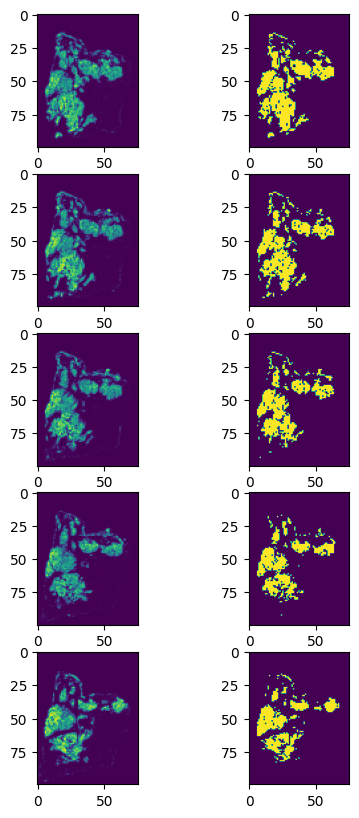

HT553P1-H2


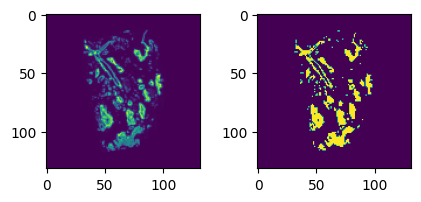

S18-9906


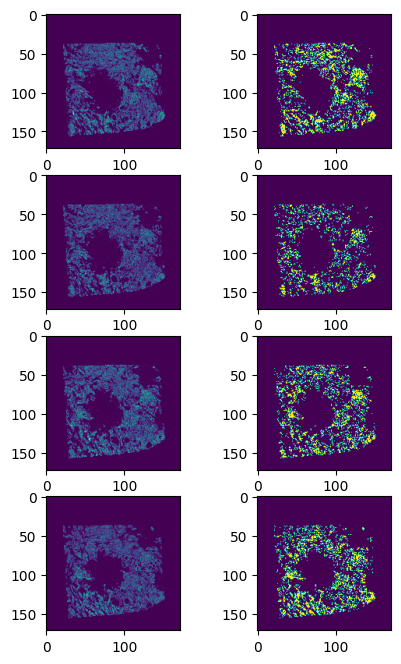

S18-5591-C8


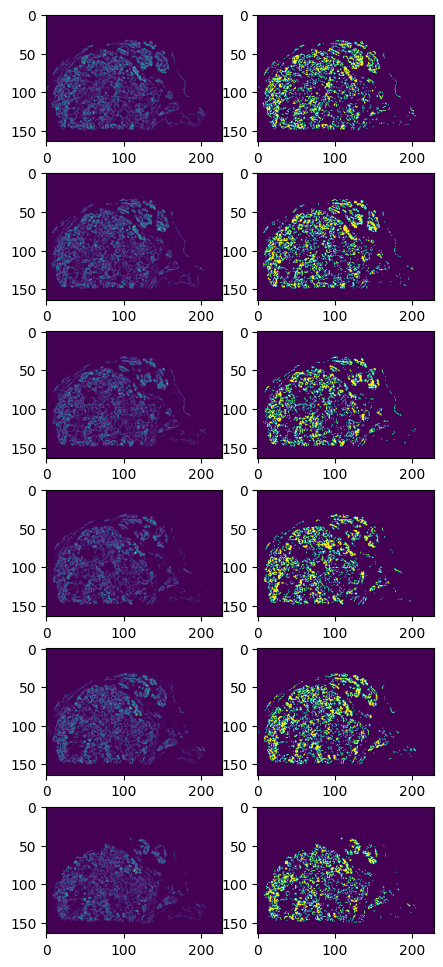

In [111]:
case_to_tumor_mask = {}
for case in case_order:
    print(case)
    dtype_to_true_pixels = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'rb')
    )
    
    dtype = [dt for dt in masking_dtype_order if dt in dtype_to_true_pixels][0]
    channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
    true_pixels = np.stack(true_pixels)
    
    if 'C3L' in case:
#         print()
        channel_idx = [channels.index(x) for x in dtype_to_mask_channel_ccrcc[dtype]]
    else:
        channel_idx = channels.index(dtype_to_mask_channel[dtype])
    
    
    mask_fp = os.path.join(project_dir, case, 'masks', 'tissue_mask.tif')
    tissue_mask = tifffile.imread(mask_fp)
    target_size  = true_pixels.shape[1:-1]
    tissue_mask = utils.rescale(tissue_mask, size=target_size, dim_order='h w', target_dtype=bool)
    
    thresh = case_to_thresh[case]
    
    nrows = len(true_pixels)
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(5, nrows * 2))
    if nrows == 1:
        axs = rearrange(axs, 'n -> 1 n')

    for i, tp in enumerate(true_pixels):
        if isinstance(channel_idx, list):
            img = tp[..., channel_idx].mean(-1)
        else:
            img = tp[..., channel_idx]
        img[~tissue_mask] = img.min()
        axs[i, 0].imshow(img)
        axs[i, 1].imshow(img > thresh)
    plt.show()
    
    if isinstance(channel_idx, list):
        img = true_pixels[..., channel_idx].mean(-1)
    else:
        img = true_pixels[..., channel_idx]
    img[..., ~tissue_mask] = img.min()
    tumor_mask = img > thresh
    
    case_to_tumor_mask[case] = tumor_mask


    

In [100]:
outputs = pickle.load(
    open(os.path.join(project_dir, 'HT397B1', 'mushroom_50res', f'outputs.pkl'), 'rb')
)
outputs.keys()


dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities', 'dtype_to_cluster_to_agg'])

In [328]:
case_to_true_slice = {}
case_to_labeled_slice = {}
for case in case_order:
    print(case)
    dtype_to_true_pixels = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'rb')
    )
    
    dtype = [dt for dt in masking_dtype_order if dt in dtype_to_true_pixels][0]
    channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
    true_pixels = true_pixels[0]
    
    volume = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
    )['labeled']['integrated']
    labeled = volume[0]
    
    case_to_true_slice[case] = true_pixels
    case_to_labeled_slice[case] = labeled

HT339B2-H1
HT565B1-H2
HT268B1
HT397B1
HT206B1
C3L-01287
C3L-00982
C3L-02551
HT413C1-K2
HT225C1
HT448C1-Th1K1Fp1
HT413C1-Th1k4A1
HT553P1-H2
S18-9906
S18-5591-C8


In [335]:
def get_nbhd_rgb(case, nbhds):
    labeled = case_to_labeled_slice[case]
    rgb = vis_utils.display_labeled_as_rgb(labeled)
    
    m = np.zeros_like(labeled, dtype=bool)
    for l in nbhds:
        m |= labeled==l
    
    rgb[~m] = 0.
    
    return rgb

def get_intensity_img(case, dtype, gene):
    dtype_to_true_pixels = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'rb')
    )
    
    channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
    true_pixels = true_pixels[0]
    
    img = true_pixels[..., channels.index(gene)]
    
    return img


In [122]:
case_to_contact_counts = {}
for case in case_order:
    print(case)
    volume = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
    )['labeled']['integrated']
    
    outputs = pickle.load(
        open(os.path.join(project_dir, case, 'mushroom_50res', f'outputs.pkl'), 'rb')
    )
    section_ids = outputs['section_ids']
    section_positions = outputs['section_positions']
    dtypes = sorted(set([v for _, v in section_ids]))
    
    dtype = [dt for dt in masking_dtype_order if dt in dtypes][0]
    positions = [i for i, (sid, dt) in zip(section_positions, section_ids) if dt==dtype]
    volume = volume[positions]
    
    tumor_mask = case_to_tumor_mask[case]
    
    assert volume.shape[0] == tumor_mask.shape[0]
    
    data, labels = [], np.unique(volume)
    counts = Counter()
    for v, m in zip(volume, tumor_mask):
        expanded = skimage.morphology.binary_dilation(m)
        boundary = expanded ^ m
        counts += Counter(v[boundary])
    
    case_to_contact_counts[case] = counts

HT339B2-H1
HT565B1-H2
HT268B1
HT397B1
HT206B1
C3L-01287
C3L-00982
C3L-02551
HT413C1-K2
HT225C1
HT448C1-Th1K1Fp1
HT413C1-Th1k4A1
HT553P1-H2
S18-9906
S18-5591-C8


In [604]:
# case_to_specific = {}
# case_to_integrated = {}
# for case in case_order:
#     fp = os.path.join(project_dir, case, 'mushroom_50res', 'outputs.pkl')
#     outputs = pickle.load(open(fp, 'rb'))
#     dtype_to_specific = outputs['dtype_to_cluster_intensities']['dtype_specific'][-1]
#     dtype_to_integrated = outputs['dtype_to_cluster_intensities']['integrated'][-1]

#     case_to_specific[case] = dtype_to_specific
#     case_to_integrated[case] = dtype_to_integrated                    

In [605]:
gene_sets = json.load(open(os.path.join(project_dir, 'analysis', 'gene_sets', 'c4.3ca.v2023.2.Hs.json')))
gene_sets.keys()

dict_keys(['GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_G2_M', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_2_CELL_CYCLE_G1_S', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_3_CELL_CYLCE_HMG_RICH', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_4_CHROMATIN', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_5_STRESS', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_METAPROGRAM_6_HYPOXIA', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_7_STRESS_IN_VITRO', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_8_PROTEASOMAL_DEGRADATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_9_UNFOLDED_PROTEIN_RESPONSE', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_13_EMT_2', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_14_EMT_3', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_15_EMT_4', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_16_MES_GLIOMA', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_17_INTERFERON_MHC_II_1', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_18_INTERFERON_MHC_II_2', 'GAVISH_3CA_MALIGNANT_ME

In [606]:
dtype_to_gene_order = {dtype: set() for dtype in dtype_to_integrated.keys()}
for dtype, df in dtype_to_integrated.items():
    dtype_to_gene_order[dtype].update(df.columns)
dtype_to_gene_order = {k:sorted(v) for k, v in dtype_to_gene_order.items()}


dtype_to_exp_df = {dt:None for dt in dtype_to_gene_order}
for case in case_order:
    dtype_to_integrated = case_to_exp[case]
#     dtype_to_integrated = case_to_integrated[case]
    for dtype, df in dtype_to_integrated.items():
        if dtype in dtype_to_gene_order:
            order = dtype_to_gene_order[dtype]
            missing = sorted(set(order) - set(df.columns))
            tail = pd.DataFrame(data=np.full((df.shape[0], len(missing)), df.values.min()))
            tail.columns = missing
            tail.index = df.index
            combined = pd.concat((df, tail), axis=1)
            combined = combined[order]
            combined.index = [(case, nbhd) for nbhd in df.index.to_list()]

            if dtype_to_exp_df[dtype] is None:
                dtype_to_exp_df[dtype] = combined
            else:
                dtype_to_exp_df[dtype] = pd.concat((dtype_to_exp_df[dtype], combined), axis=0)

In [607]:
quant_dtypes = ['xenium', 'visium', 'cosmx']

data = []
exp_data = []
for case in case_order:
    print(case)
#     dtype_to_integrated = case_to_integrated[case]
    dtype_to_integrated = case_to_exp[case]
    dtypes = [qdt for qdt in quant_dtypes if qdt in dtype_to_integrated]
    for quant_dtype in dtypes:
        df = dtype_to_integrated[quant_dtype]
        for name, gs in gene_sets.items():
            genes = [g for g in gs['geneSymbols'] if g in df.columns]
            if len(genes) >= 3:
                nbhd_scores = df[genes].values.mean(1)
                for nbhd, score in zip(df.index.to_list(), nbhd_scores):
                    data.append([case, quant_dtype, name, nbhd, score])

score_df = pd.DataFrame(data, columns=['case', 'dtype', 'gene_set', 'nbhd', 'score'])
score_df


HT339B2-H1
HT565B1-H2
HT268B1
HT397B1
HT206B1
C3L-01287
C3L-00982
C3L-02551
HT413C1-K2
HT225C1
HT448C1-Th1K1Fp1
HT413C1-Th1k4A1
HT553P1-H2
S18-9906
S18-5591-C8


case   dtype                                           gene_set  \
0       HT339B2-H1  visium  GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...   
1       HT339B2-H1  visium  GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...   
2       HT339B2-H1  visium  GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...   
3       HT339B2-H1  visium  GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...   
4       HT339B2-H1  visium  GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...   
...            ...     ...                                                ...   
49787  S18-5591-C8  xenium          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS   
49788  S18-5591-C8  xenium          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS   
49789  S18-5591-C8  xenium          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS   
49790  S18-5591-C8  xenium          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS   
49791  S18-5591-C8  xenium          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS   

       nbhd     score  
0         0  2.555244  
1         1  0.736646  
2         2 -0.068806  
3         3  0.002249  
4         4 -0.344707  
...     ...       ...  
49787    52  0.069131  
49788    53  0.351906  
49789    54 -0.303664  
49790    55  0.387669  
49791    56  0.437129  

[49792 rows x 5 columns]

In [608]:
case_to_background

{'HT339B2-H1': [4, 3],
 'HT565B1-H2': [0],
 'HT268B1': [9],
 'HT397B1': [0],
 'HT206B1': [13],
 'C3L-01287': [4],
 'C3L-00982': [0],
 'C3L-02551': [3],
 'HT413C1-K2': [5],
 'HT225C1': [0],
 'HT448C1-Th1K1Fp1': [11],
 'HT413C1-Th1k4A1': [0, 16],
 'HT553P1-H2': [0],
 'S18-9906': [14],
 'S18-5591-C8': [54]}

In [609]:
df = score_df.copy()
df = df.pivot(columns='gene_set', index=['case', 'dtype', 'nbhd'])
df = df.reset_index()

df = df[[False if nbhd in case_to_background[case] else True for case, nbhd in zip(df['case'], df['nbhd'])]]

df.index = [(case, nbhd) for case, nbhd in zip(df['case'], df['nbhd'])]


df

case   dtype nbhd  \
gene_set                                 
(C3L-00982, 1)  C3L-00982  xenium    1   
(C3L-00982, 2)  C3L-00982  xenium    2   
(C3L-00982, 3)  C3L-00982  xenium    3   
(C3L-00982, 4)  C3L-00982  xenium    4   
(C3L-00982, 5)  C3L-00982  xenium    5   
...                   ...     ...  ...   
(S18-9906, 16)   S18-9906  xenium   16   
(S18-9906, 17)   S18-9906  xenium   17   
(S18-9906, 18)   S18-9906  xenium   18   
(S18-9906, 19)   S18-9906  xenium   19   
(S18-9906, 20)   S18-9906  xenium   20   

                                                                score  \
gene_set       GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION   
(C3L-00982, 1)                                           0.344023       
(C3L-00982, 2)                                           0.294025       
(C3L-00982, 3)                                          -0.360286       
(C3L-00982, 4)                                          -0.302184       
(C3L-00982, 5)                                           1.096492       
...                                                           ...       
(S18-9906, 16)                                                NaN       
(S18-9906, 17)                                                NaN       
(S18-9906, 18)                                                NaN       
(S18-9906, 19)                                                NaN       
(S18-9906, 20)                                                NaN       

                                                                           \
gene_set       GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION   
(C3L-00982, 1)                                                NaN           
(C3L-00982, 2)                                                NaN           
(C3L-00982, 3)                                                NaN           
(C3L-00982, 4)                                                NaN           
(C3L-00982, 5)                                                NaN           
...                                                           ...           
(S18-9906, 16)                                                NaN           
(S18-9906, 17)                                                NaN           
(S18-9906, 18)                                                NaN           
(S18-9906, 19)                                                NaN           
(S18-9906, 20)                                                NaN           

                                                          \
gene_set       GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1   
(C3L-00982, 1)                                  2.643170   
(C3L-00982, 2)                                  0.167625   
(C3L-00982, 3)                                 -0.130489   
(C3L-00982, 4)                                  1.688134   
(C3L-00982, 5)                                  1.177587   
...                                                  ...   
(S18-9906, 16)                                  0.663112   
(S18-9906, 17)                                  0.663512   
(S18-9906, 18)                                  0.441130   
(S18-9906, 19)                                  0.737496   
(S18-9906, 20)                                  0.808803   

                                                          \
gene_set       GAVISH_3CA_MALIGNANT_METAPROGRAM_13_EMT_2   
(C3L-00982, 1)                                  1.605927   
(C3L-00982, 2)                                  0.210925   
(C3L-00982, 3)                                 -0.178630   
(C3L-00982, 4)                                  0.652141   
(C3L-00982, 5)                                  0.961150   
...                                                  ...   
(S18-9906, 16)                                  0.301211   
(S18-9906, 17)                                  0.244282   
(S18-9906, 18)                                  0.377532   
(S18-9906, 19)                                  0.357979   
(S18-9906, 20)       

In [610]:
case_order

['HT339B2-H1',
 'HT565B1-H2',
 'HT268B1',
 'HT397B1',
 'HT206B1',
 'C3L-01287',
 'C3L-00982',
 'C3L-02551',
 'HT413C1-K2',
 'HT225C1',
 'HT448C1-Th1K1Fp1',
 'HT413C1-Th1k4A1',
 'HT553P1-H2',
 'S18-9906',
 'S18-5591-C8']

In [611]:
# genes = [
#     'EPCAM',
#     'ACTA2',
#     'CD68',
#     'CD31',
#     'CD3D',
#     'CD8A',
#     'GZMK',
#     'GNLY',
#     'KLRB1',
#     'KLRD1',
#     'NCAM1',

# ]

In [700]:
components = {
    'Fibroblast': ['ACTA2', 'COL17A1', 'MYH11', 'CNN1'],
    'T cell': ['CD3D', 'CD3E', 'IL7R', 'CD2', 'CD247'],
    'NK cell': ['GZMK', 'GNLY', 'KLRB1', 'KLRD1', 'NCAM1'],
#     'B cell': ['MS4A1'],
    'Macrophage': ['CD68', 'CD163'],
    'Epithelial': ['EPCAM'],
    'Endothelial': ['PECAM1'],
#     'Epithelial - CCRCC': ['LRP2', 'CA9'],
}

In [701]:
def score_gene_set(df, gene_set):
    data = []
    order = sorted(gene_set.keys())
    for name in order:
        genes = gene_set[name]
        f = df[[c for c in df.columns if c in genes]]
        data.append(f.values.mean(1).flatten())
    scored = pd.DataFrame(data=data, columns=df.index, index=order).T
    return scored

In [702]:
scoring_order = ['xenium', 'visium']
case_to_scored = {}
for case in case_order:
#     dtype_to_integrated = case_to_integrated[case]
    dtype_to_integrated = case_to_exp[case]
    dtype = [dt for dt in scoring_order if dt in dtype_to_integrated][0]
    
    scored = score_gene_set(dtype_to_integrated[dtype], components)
    
    scored = scored[[True if x not in case_to_background[case] else False for x in scored.index]]
#     scored -= np.expand_dims(scored.min(1), -1)
#     scored /= np.expand_dims(scored.max(1), -1)
#     scored -= scored.min(1)
#     scored /= scored.max(1)
    
    
    case_to_scored[case] = scored
case_to_scored.keys()

dict_keys(['HT339B2-H1', 'HT565B1-H2', 'HT268B1', 'HT397B1', 'HT206B1', 'C3L-01287', 'C3L-00982', 'C3L-02551', 'HT413C1-K2', 'HT225C1', 'HT448C1-Th1K1Fp1', 'HT413C1-Th1k4A1', 'HT553P1-H2', 'S18-9906', 'S18-5591-C8'])

In [703]:
# del(mushroom)

In [704]:
# mushroom = Mushroom.from_config('/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res')

In [705]:
# config = yaml.safe_load(open('/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/config.yaml'))
# config['trainer_kwargs']['pct_expression'] = None
# config['dtype_to_chkpt'] = None

# m2 = Mushroom.from_config(config)

In [706]:
# m2.embed_sections()

In [707]:
# for name, genes in components.items():
#     channels = m2.dtype_to_spore['visium'].dtype_to_channels['visium']
#     print(name, [g for g in genes if g in channels])

In [708]:
# m2.dtype_to_spore['visium'].true_pixels[0].shape

In [709]:
# spore = m2.dtype_to_spore['visium']

In [710]:
# spore.learner_data.dtype_to_channels['visium'].index('MS1A1')

In [711]:
# spore.learner_data.dtype_to_section_to_img

In [712]:
# gene_df

In [713]:
case_to_scored['HT339B2-H1']

Endothelial  Epithelial  Fibroblast  Macrophage   NK cell    T cell
0      1.250234    2.794176    1.329241    0.848821  0.226307  0.160094
1      1.054881    1.003202    1.273967    1.073722  0.325184  0.217080
2      0.519493   -0.053913    0.361619    0.397161  0.109750  0.111491
5     -0.017479   -0.324002   -0.265156   -0.288568 -0.074967 -0.075007
6      1.356802    0.998118    1.367709    0.957321  0.114440  0.288783
7      1.382507    0.836168    1.341792    1.103491  0.058357  0.122278
8      1.419700    0.160982    1.062436    0.401001  0.069898  0.302462
9      1.118713    0.429920    0.995155    0.740463  0.183882  0.049972
10     1.027349    0.776899    0.904685    0.524319  0.088540  0.207825
11     1.396897    0.933524    1.412304    1.093386  0.141916  0.228193
12     1.208714    0.362993    1.092045    0.925923  0.128815  0.245858
13     1.533847    1.574924    1.658936    1.157519  0.203362  0.197562
14     0.665576    0.240578    0.549675    0.391725  0.044826  0.039130
15     0.881245    0.457238    1.123703    1.066489 -0.073778  0.073179
16     1.371726   -0.003892    1.217357    0.717979  0.056682  0.340753
17     1.183834    0.444023    0.917750    0.869673  0.076841  0.230978
18     0.802323    0.335618    0.769629    0.800951  0.140228  0.028473

In [714]:
case_to_scored['HT206B1']

Endothelial  Epithelial  Fibroblast  Macrophage   NK cell    T cell
0      1.455803    0.784820    9.285375    0.955248  0.387382  0.391884
1      1.228255    0.575971    0.784629    0.842278  0.936511  1.032355
2     -0.092449    4.078033   -0.009598    0.337121 -0.037537 -0.181323
3      0.128663    2.657975    0.034739    0.542193 -0.032565 -0.145477
4      3.392073   -0.113441    0.609586    1.143818  5.381817  8.165964
5      1.503692    0.217598    4.171337    1.132146  0.460850  0.399583
6      2.522570   -0.134237    0.342448    1.879605  2.675800  2.951195
7      0.004174    1.205564    0.291044    0.359054  0.625833  0.031252
8      0.825397   -0.003059    0.054453    0.889339  0.518980  0.404120
9      1.078079    0.008463    0.078151    1.110575  0.684755  0.580017
10    -0.277296   -0.288573   -0.160989   -0.143679 -0.194686 -0.212577
11     1.132007   -0.150173    0.124386    1.074010  0.583623  0.452718
12     1.245589   -0.095788    0.153227    1.230083  0.801439  0.668912
14     0.879049    0.613972    0.337416    0.814255  0.426427  0.394204
15    -0.173066    0.292435   -0.074504   -0.204268 -0.071854 -0.023439
16     0.932219   -0.227483    0.069012    0.705634  0.236422  0.107989
17    -0.505597   -0.305186   -0.208797   -0.446179 -0.318469 -0.298854

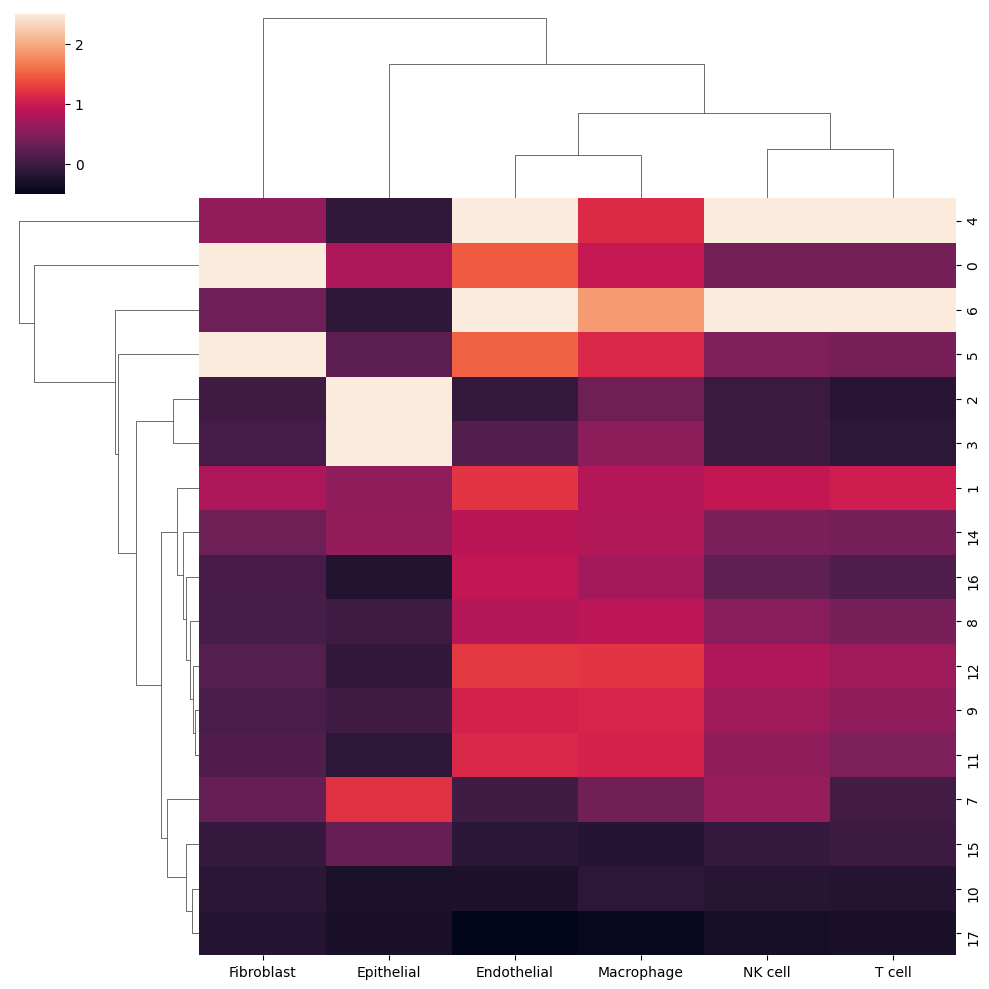

In [723]:
sns.clustermap(case_to_scored['HT206B1'], col_cluster=True, row_cluster=True, vmax=2.5)
plt.show()

In [731]:
cases = []
dtypes = []
combined = None
for case, scored in case_to_scored.items():
    cases += [case] * len(scored)

    dtype_to_integrated = case_to_exp[case]
    dtype = [dt for dt in scoring_order if dt in dtype_to_integrated][0]
    dtypes += [dtype] * len(scored)

    if combined is None:
        combined = scored.copy()
    else:
        combined = pd.concat((combined, scored), axis=0)
    combined[combined>3.5] = 3.5
combined

Endothelial  Epithelial  Fibroblast  Macrophage   NK cell    T cell
0      1.250234    2.794176    1.329241    0.848821  0.226307  0.160094
1      1.054881    1.003202    1.273967    1.073722  0.325184  0.217080
2      0.519493   -0.053913    0.361619    0.397161  0.109750  0.111491
5     -0.017479   -0.324002   -0.265156   -0.288568 -0.074967 -0.075007
6      1.356802    0.998118    1.367709    0.957321  0.114440  0.288783
..          ...         ...         ...         ...       ...       ...
51     0.201128   -0.199619    1.136865    0.412076  0.395455  0.173508
52     0.101045    1.453470    0.075866    0.056373 -0.006711 -0.139743
53     0.759873    0.895787    1.048215    0.272061  0.363953  0.101543
55     0.551923    0.970555    1.224907    0.319559  0.470205  0.252702
56     0.718657    0.818933    0.866658    0.476536  0.397821  0.143938

[317 rows x 6 columns]

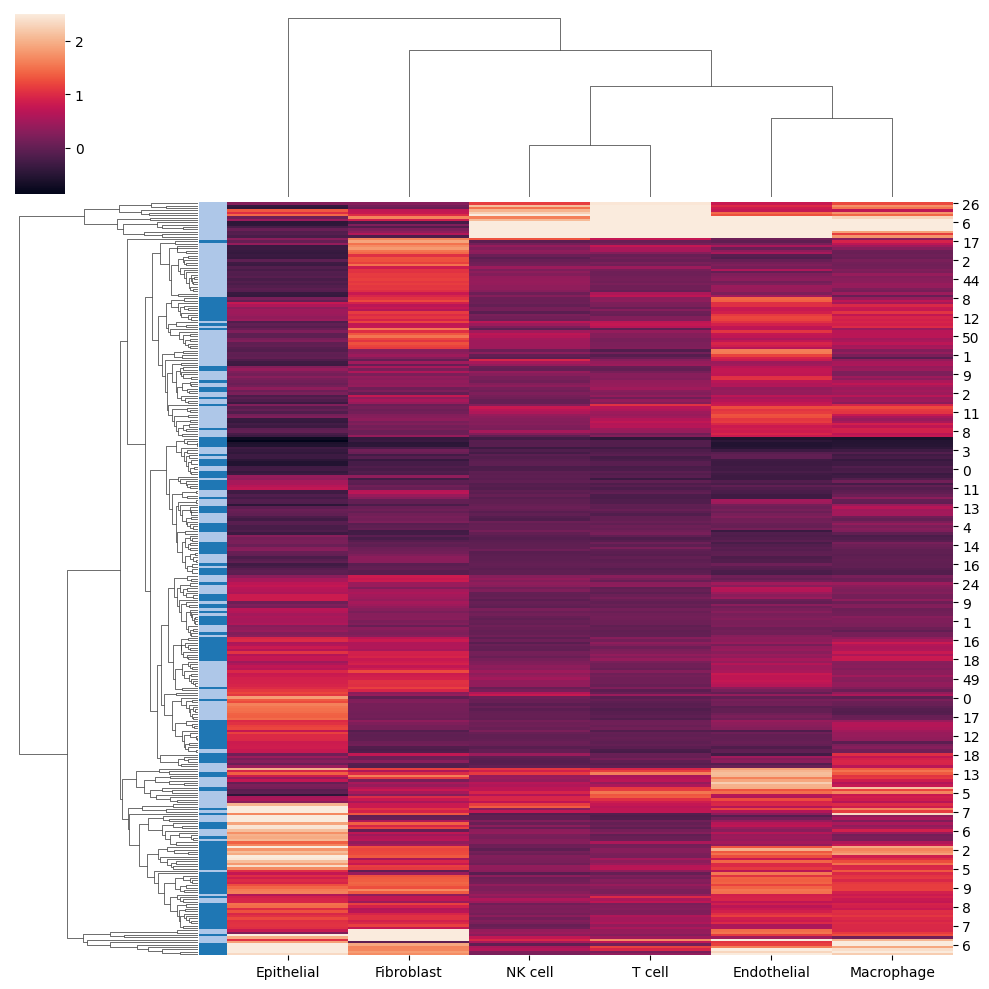

In [732]:
# colors = [sns.color_palette('tab20')[case_order.index(z)] for z in cases]
order = ['visium', 'xenium']
colors = [sns.color_palette('tab20')[order.index(z)] for z in dtypes]
sns.clustermap(combined, col_cluster=True, row_cluster=True, vmax=2.5, row_colors=colors)
plt.show()

In [ ]:
cols = ['Epithelial', 'Macrophage', 'T cell', 'NK cell', 'Endothelial', 'Fibroblast']
idx = [2, 3,
      6, 12, 9, 11, 4, 5]

In [722]:
# cg = sns.clustermap(case_to_scored['HT339B2-H1'],
#                            standard_scale=0, col_cluster=False)
# plt.show()
# cg
# # plt.savefig('/data/estorrs/sandbox/xenium_heatmap_gs.svg')

In [717]:
case = 'HT206B1'
# # gene_df = case_to_integrated[case]['xenium']
# gene_df = case_to_integrated[case]['visium']
# gs_df = df[df['case']==case]
# gene_df = gene_df[[True if x not in case_to_background[case] else False
#                    for x in gene_df.index]]
# ct_df = score_gene_set(gene_df, components)

# to_macro = {
    
# }




In [647]:
# cg = sns.clustermap(gene_df[[g for g in genes if g in gene_df.columns]],
#                            standard_scale=0, col_cluster=False)
# plt.show()
# cg
# # plt.savefig('/data/estorrs/sandbox/xenium_heatmap_gs.svg')

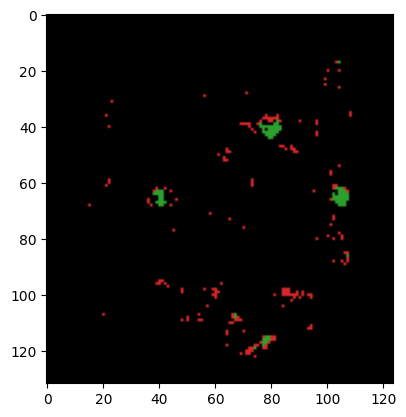

In [724]:
rgb = get_nbhd_rgb(case, [4, 6])
plt.imshow(rgb)
plt.show()

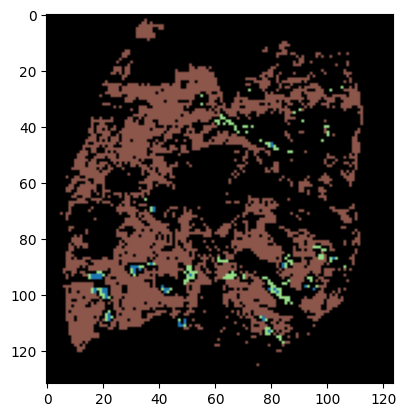

In [504]:
rgb = get_nbhd_rgb(case, [10, 0, 5])
plt.imshow(rgb)
plt.show()

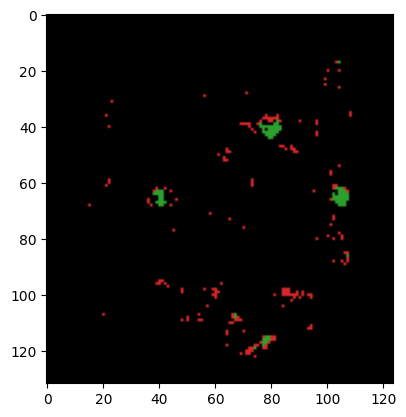

In [509]:
rgb = get_nbhd_rgb(case, [4, 6])
plt.imshow(rgb)
plt.show()

In [ ]:
rgb = get_nbhd_rgb(case, [10, 0, 5])
plt.imshow(rgb)
plt.show()

In [478]:
vis_utils.get_cmap(max(gene_df.index.to_list()))

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

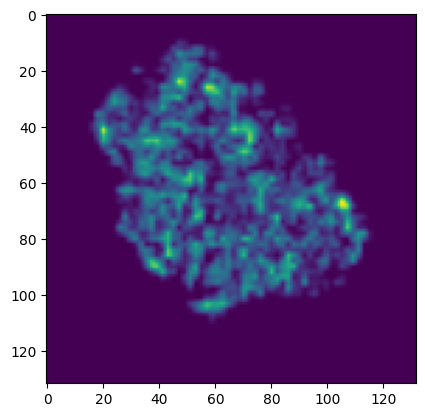

In [650]:
img = get_intensity_img(case, 'visium', 'PECAM1')
plt.imshow(img)
plt.show()

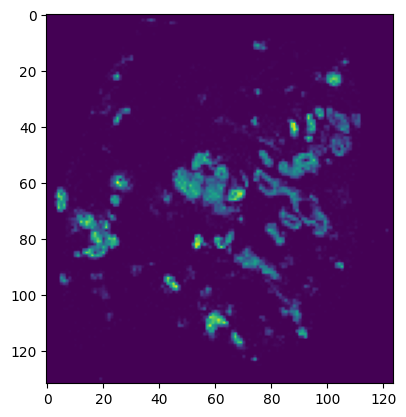

In [513]:
img = get_intensity_img(case, 'xenium', 'EPCAM')
plt.imshow(img)
plt.show()

In [421]:
visium_df = df[df['dtype']=='visium']
visium_df = visium_df[visium_df.columns[pd.isnull(visium_df).sum(0) == 0]]

xenium_df = df[df['dtype']=='xenium']
xenium_df = xenium_df[xenium_df.columns[pd.isnull(xenium_df).sum(0) == 0]]

cols = sorted(set(visium_df.columns).intersection(set(xenium_df.columns)))
visium_df = visium_df[cols]
xenium_df = xenium_df[cols]

visium_meta, visium_df = visium_df.iloc[:, :3], visium_df.iloc[:, 3:]
xenium_meta, xenium_df = xenium_df.iloc[:, :3], xenium_df.iloc[:, 3:]

# cg = sns.clustermap(visium_df, standard_scale=0)
# gs_order = visium_df.columns[cg.dendrogram_col.reordered_ind]
# cg = sns.clustermap(xenium_df, standard_scale=0)
# gs_order = xenium_df.columns[cg.dendrogram_col.reordered_ind]

xenium_df = xenium_df[gs_order]
visium_df = visium_df[gs_order]


In [429]:
list(exp_df.columns)

['ABCC11',
 'ACAN',
 'ACE2',
 'ACKR1',
 'ACTA2',
 'ACTG2',
 'ADAM28',
 'ADAMTS1',
 'ADGRE1',
 'ADGRL4',
 'ADH1C',
 'ADH4',
 'ADIPOQ',
 'AGER',
 'AGR3',
 'AHSP',
 'AIF1',
 'ALAS2',
 'ALDH1A3',
 'AMY2A',
 'AMY2B',
 'ANGPT2',
 'ANPEP',
 'APCDD1',
 'APOA5',
 'APOBEC3A',
 'APOLD1',
 'AQP2',
 'AQP3',
 'AQP8',
 'AQP9',
 'AR',
 'AREG',
 'ARFGEF3',
 'ASCL1',
 'ASCL3',
 'ASPN',
 'ATP6V1C1',
 'AVPR2',
 'AZGP1',
 'B3GAT1',
 'BAMBI',
 'BANK1',
 'BASP1',
 'BBOX1',
 'BCL2L11',
 'BMX',
 'BTNL9',
 'C15orf48',
 'C1orf162',
 'C1orf194',
 'C20orf85',
 'C5orf46',
 'C6orf118',
 'C7',
 'CA4',
 'CA9',
 'CALB1',
 'CALCR',
 'CAPN8',
 'CAV1',
 'CAVIN1',
 'CAVIN2',
 'CCDC39',
 'CCDC78',
 'CCL19',
 'CCL27',
 'CCL5',
 'CCNB2',
 'CCR2',
 'CCR7',
 'CD14',
 'CD163',
 'CD19',
 'CD1A',
 'CD1C',
 'CD1E',
 'CD2',
 'CD247',
 'CD27',
 'CD274',
 'CD28',
 'CD300E',
 'CD34',
 'CD3D',
 'CD3E',
 'CD4',
 'CD44',
 'CD5L',
 'CD68',
 'CD69',
 'CD70',
 'CD79A',
 'CD83',
 'CD86',
 'CD8A',
 'CD93',
 'CDH1',
 'CDH11',
 'CDH16',
 'CDK1',

In [430]:
genes = [
    'EPCAM',
    'LRP2',
    'CA9',
    'IL7R',
    'CD8A',
    'CD3D',
    'PTPRC',
    'CD68',
    'ACTA2',
    'HPX'
]

In [438]:
xenium_cg.ax_heatmap.xaxis.get_ticklabels()

[Text(0.5, 0, 'score-GAVISH_3CA_METAPROGRAM_FIBROBLASTS_CAF_5'),
 Text(3.5, 0, 'score-GAVISH_3CA_METAPROGRAM_FIBROBLASTS_CAF_1'),
 Text(6.5, 0, 'score-GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1'),
 Text(9.5, 0, 'score-GAVISH_3CA_METAPROGRAM_FIBROBLASTS_MHC_II_CYTOKINE'),
 Text(12.5, 0, 'score-GAVISH_3CA_METAPROGRAM_MACROPHAGES_PROTEASOMAL_DEGRADATION'),
 Text(15.5, 0, 'score-GAVISH_3CA_METAPROGRAM_CD4_T_CELLS_GLYCOLYSIS_MYC'),
 Text(18.5, 0, 'score-GAVISH_3CA_METAPROGRAM_CD4_T_CELLS_T_REG'),
 Text(21.5, 0, 'score-GAVISH_3CA_METAPROGRAM_CD4_T_CELLS_DYSFUNCTION'),
 Text(24.5, 0, 'score-GAVISH_3CA_METAPROGRAM_CD8_T_CELLS_NAIVE_2'),
 Text(27.5, 0, 'score-GAVISH_3CA_METAPROGRAM_CD4_T_CELLS_NAIVE_1'),
 Text(30.5, 0, 'score-GAVISH_3CA_METAPROGRAM_B_CELLS_STRESS'),
 Text(33.5, 0, 'score-GAVISH_3CA_METAPROGRAM_FIBROBLASTS_CAF_10'),
 Text(36.5, 0, 'score-GAVISH_3CA_METAPROGRAM_FIBROBLASTS_PI16_POS'),
 Text(39.5, 0, 'score-GAVISH_3CA_METAPROGRAM_EPITHELIAL_EMT_LIKE_1'),
 Text(42.5, 0, 'score-GAVIS

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


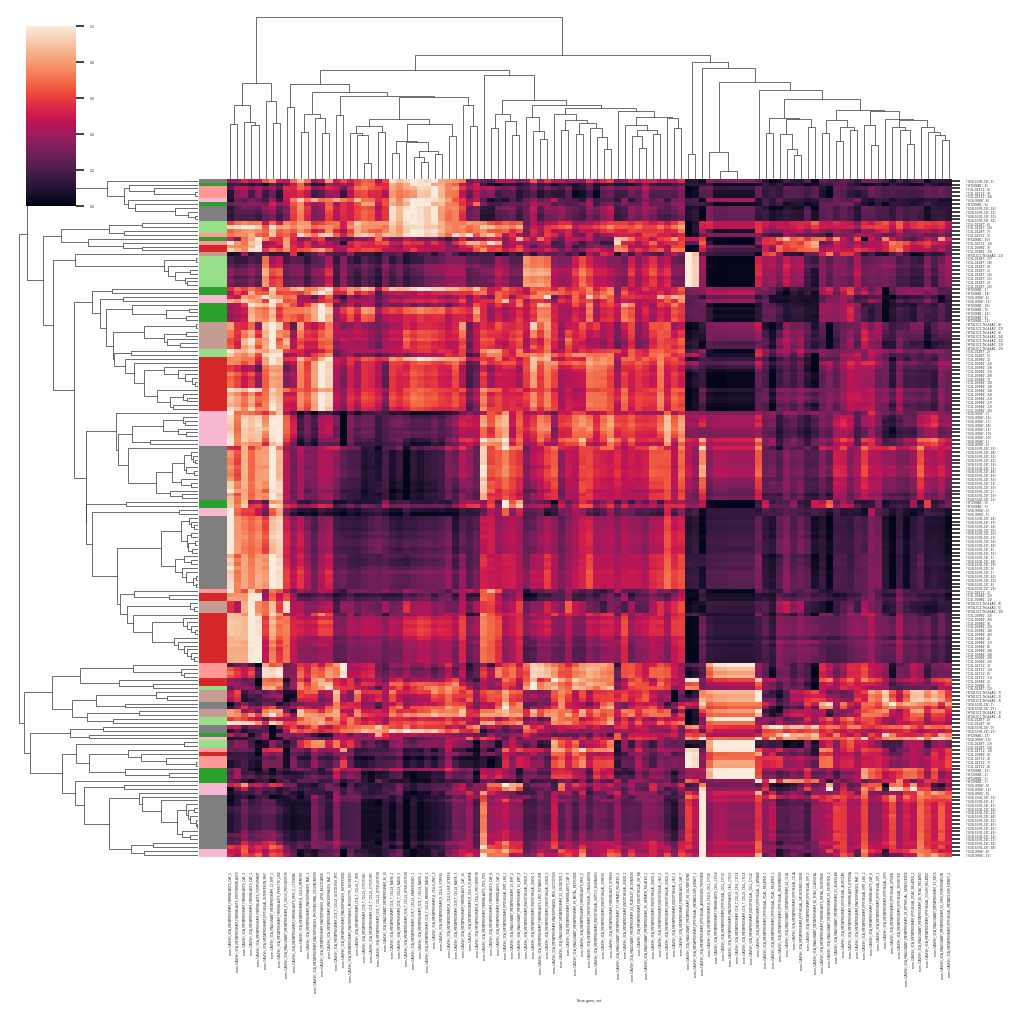

In [440]:
colors = [sns.color_palette('tab20')[case_order.index(z)] for z in xenium_meta['case']]
sns.set(font_scale=.2)
xenium_cg = sns.clustermap(xenium_df, standard_scale=0, row_colors=colors, col_cluster=True)

plt.savefig('/data/estorrs/sandbox/xenium_heatmap_gs.svg')

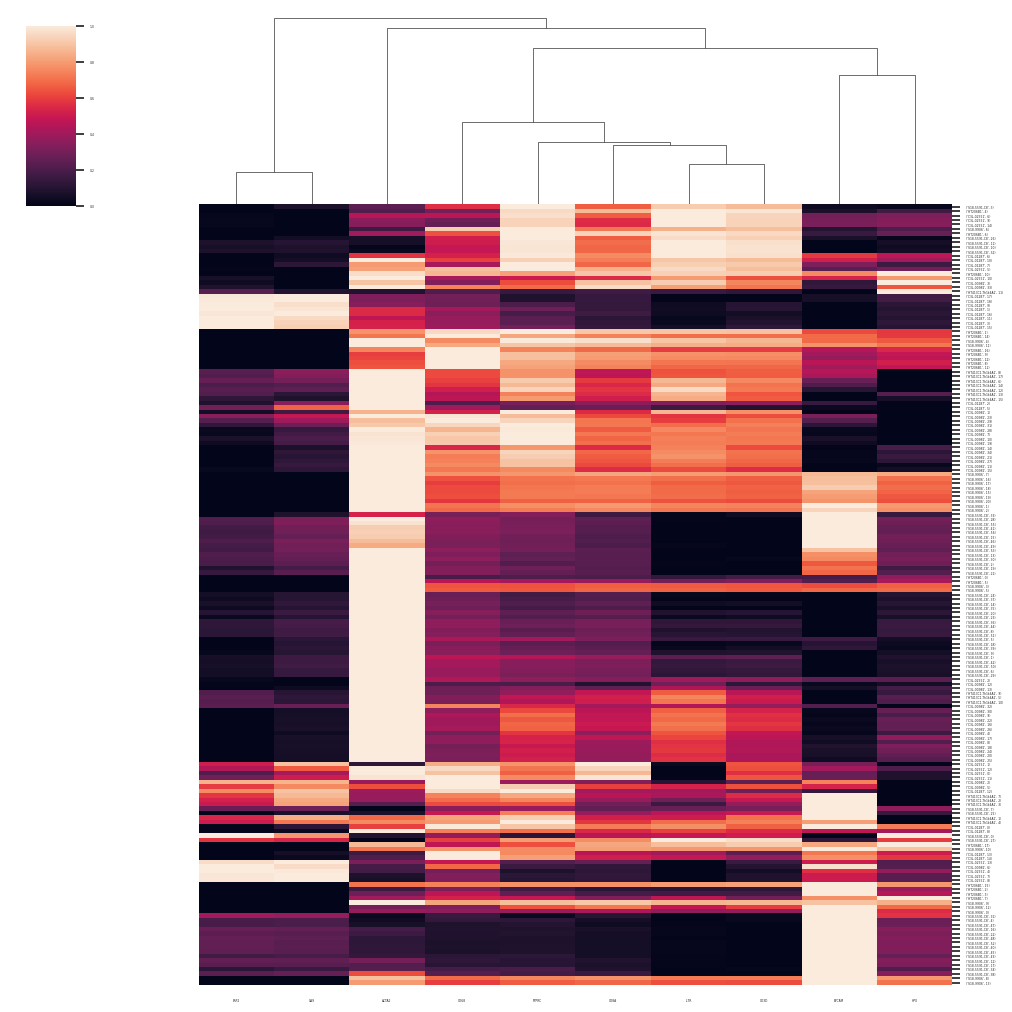

In [442]:
nbhd_order = xenium_meta.index[xenium_cg.dendrogram_row.reordered_ind].to_list()
colors = np.asarray([sns.color_palette('tab20')[case_order.index(z)] for z in xenium_meta['case']])

exp_df = dtype_to_exp_df['xenium']
exp_cg = sns.clustermap(
    exp_df.loc[nbhd_order, genes], standard_scale=0,
    row_cluster=False, col_cluster=True
)

plt.savefig('/data/estorrs/sandbox/xenium_heatmap_genes.svg')

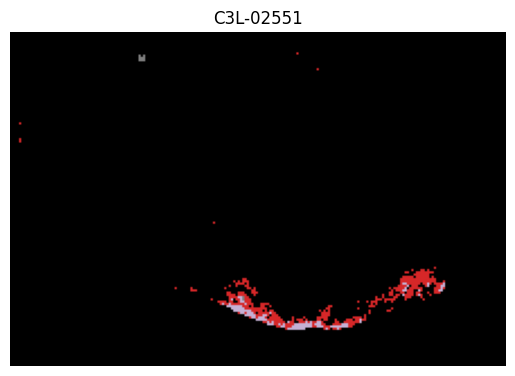

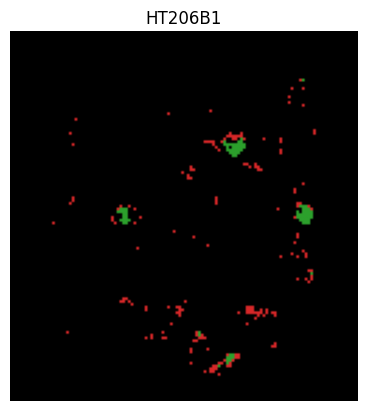

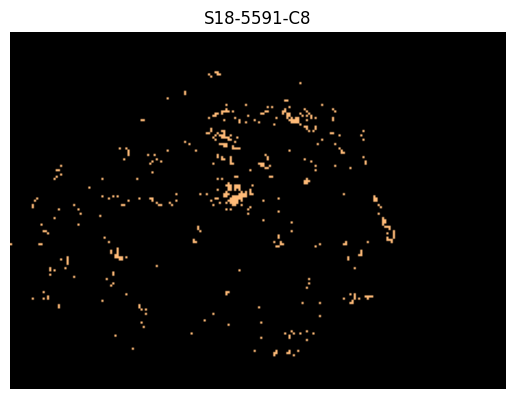

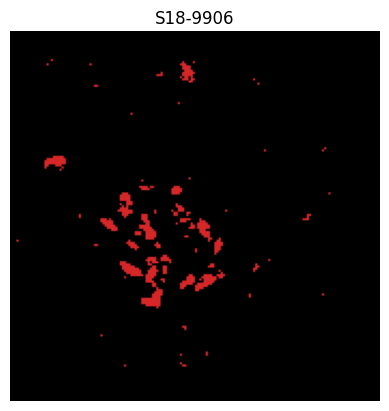

In [453]:
sns.reset_orig()
start, stop = ('S18-5591-C8', 3), ('S18-5591-C8', 26)
selected = []
current=False
for nbhd in nbhd_order:
    if nbhd == start:
        current = True
    if nbhd == stop:
        break
    
    if current:
        selected.append(nbhd)
    
selected = sorted(selected)
case_to_nbhd = {case:[] for case, _ in selected}
for case, nbhd in selected:
    case_to_nbhd[case].append(nbhd)

for case, nbhds in case_to_nbhd.items():
    rgb = get_nbhd_rgb(case, nbhds)
    plt.imshow(rgb)
    plt.title(case)
    plt.axis('off')
    plt.show()

In [324]:
xenium_cg.dendrogram_row.linkage[:, -1]

array([  2.,   2.,   3.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
         2.,   2.,   2.,   2.,   2.,   2.,   2.,   3.,   4.,   3.,   2.,
         3.,   4.,   3.,   3.,   2.,   2.,   2.,   2.,   2.,   3.,   4.,
         2.,   4.,   4.,   6.,   3.,   4.,   2.,   4.,   2.,   6.,   2.,
         2.,   5.,   7.,   3.,   2.,   4.,   2.,   3.,   2.,   2.,   3.,
         5.,   7.,   5.,   3.,   3.,   3.,   6.,   2.,   3.,   3.,  10.,
         2.,   2.,   6.,   3.,   5.,  10.,   5.,   9.,   4.,   7.,   2.,
        10.,   3.,   5.,   2.,   2.,   6.,   3.,   2.,   3.,   4.,   6.,
         5.,   8.,   6.,  11.,  19.,   6.,   3.,  13.,   3.,   2.,   2.,
        12.,   2.,   7.,  12.,   2.,   2.,  12.,   2.,   4.,   2.,  13.,
         5.,  13.,   3.,   4.,  13.,   5.,   8.,   2.,   4.,   4.,   6.,
         5.,  14.,  16.,   2.,   2.,   3.,  14.,   2.,  10.,   2.,   2.,
         3.,  19.,   3.,  22.,  38.,  23.,  16.,   2.,  23.,   2.,   4.,
        17.,  11.,  28.,   2.,  30.,   5.,  32.,  4

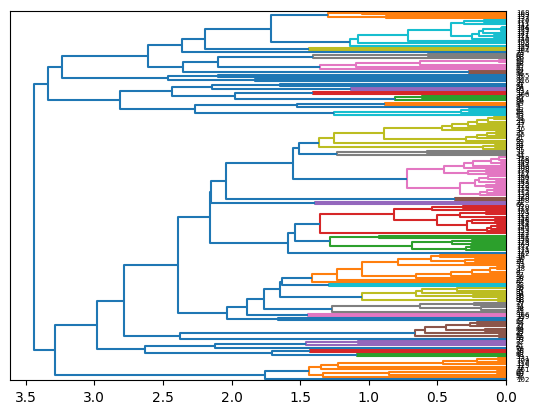

In [290]:
dn = dendrogram(xenium_cg.dendrogram_row.linkage, color_threshold=1.5, orientation='left')

In [305]:
clusters = []
seen = set()
current = None
for i, c in enumerate(dn['leaves_color_list']):
    if c != current:
        current = c
        seen.add(i)
        
    clusters.append(f'C{len(seen)}')
clusters = np.asarray(clusters)

xenium_meta['cluster'] = clusters[np.argsort(dn['leaves'])]
xenium_meta

case   dtype nbhd cluster
gene_set                                
1         C3L-00982  xenium    1     C14
2         C3L-00982  xenium    2     C24
3         C3L-00982  xenium    3      C6
4         C3L-00982  xenium    4     C22
5         C3L-00982  xenium    5     C25
..              ...     ...  ...     ...
368        S18-9906  xenium   16     C16
369        S18-9906  xenium   17     C16
370        S18-9906  xenium   18     C16
371        S18-9906  xenium   19     C16
372        S18-9906  xenium   20     C16

[175 rows x 4 columns]

In [327]:
xenium_meta[xenium_meta['cluster']=='C8']

case   dtype nbhd cluster
gene_set                                
36        C3L-01287  xenium    1      C8
38        C3L-01287  xenium    3      C8
44        C3L-01287  xenium    9      C8
46        C3L-01287  xenium   11      C8
50        C3L-01287  xenium   15      C8
51        C3L-01287  xenium   16      C8
52        C3L-01287  xenium   17      C8
53        C3L-01287  xenium   18      C8

In [329]:
case_to_tumor_mask['C3L-01287'].shape

(1, 220, 228)

In [332]:
def get_nbhd_rgb(case, nbhds):
    labeled = case_to_labeled_slice[case]
    rgb = vis_utils.display_labeled_as_rgb(labeled)
    
    m = np.zeros_like(labeled, dtype=bool)
    for l in nbhds:
        m |= labeled==l
    
    rgb[~m] = 0.
    
    return rgb

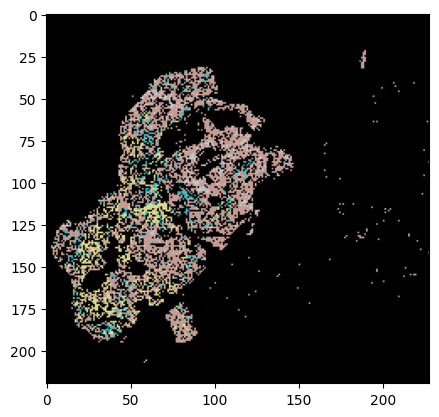

In [333]:
rgb = get_nbhd_rgb('C3L-01287', [11, 15, 16, 17, 18])
plt.imshow(rgb)

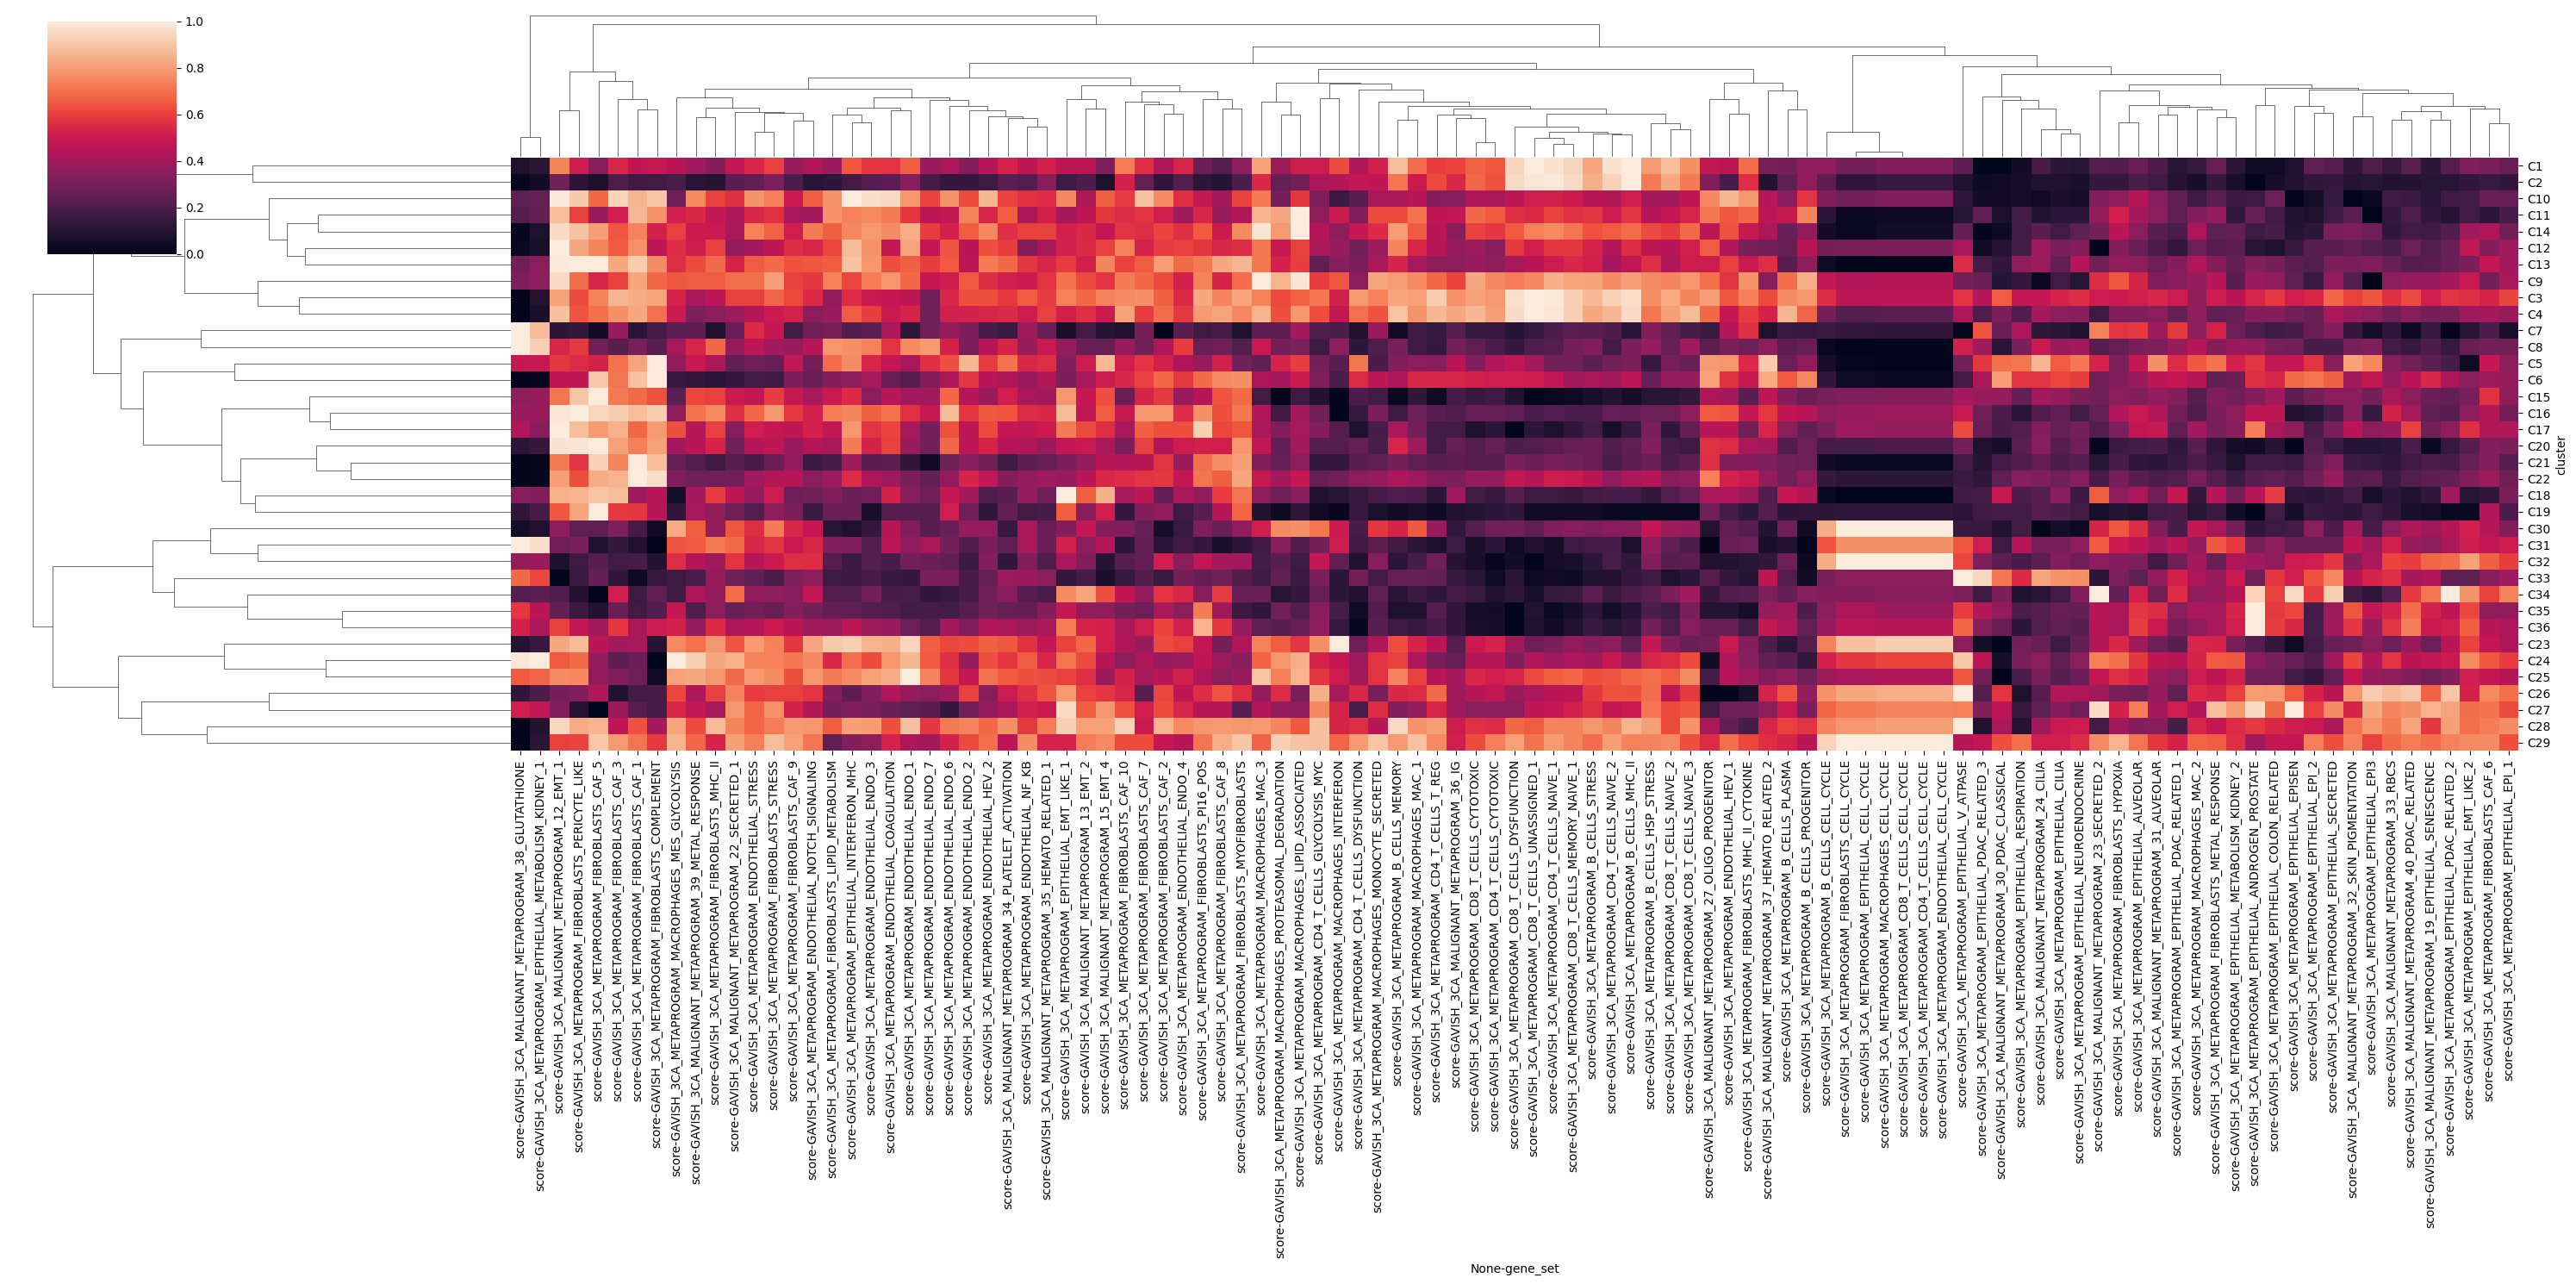

In [316]:
xenium_df['cluster'] = xenium_meta['cluster'].to_list()
grouped_df = xenium_df.groupby('cluster').mean()
cg = sns.clustermap(grouped_df, standard_scale=0, col_cluster=True, figsize=(30, 15))
plt.savefig('/data/estorrs/sandbox/xenium_heatmap.svg')

In [ ]:
xenium_df['cluster'] = xenium_meta['cluster'].to_list()
grouped_df = xenium_df.groupby('cluster').mean()
sns.heatmap(grouped_df, standard_scale=0, col_cluster=True, figsize=(30, 15))

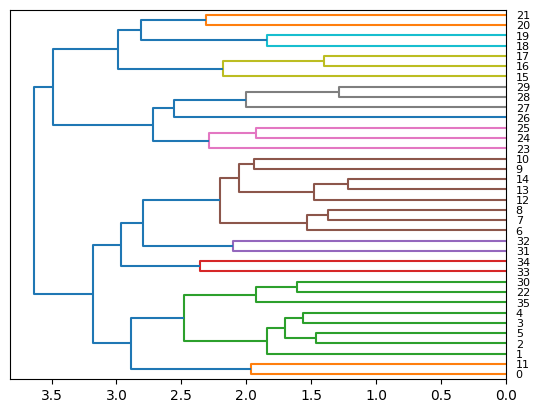

In [319]:
cluster_dn = dendrogram(cg.dendrogram_row.linkage, color_threshold=2.5, orientation='left')

In [292]:
xenium_cg.dendrogram_row.reordered_ind

[102,
 70,
 57,
 60,
 65,
 161,
 72,
 125,
 110,
 109,
 131,
 39,
 43,
 40,
 56,
 76,
 61,
 2,
 32,
 93,
 50,
 51,
 42,
 35,
 49,
 44,
 37,
 48,
 67,
 79,
 159,
 166,
 81,
 75,
 78,
 74,
 77,
 90,
 98,
 88,
 96,
 94,
 95,
 97,
 36,
 38,
 0,
 22,
 28,
 30,
 27,
 6,
 9,
 18,
 13,
 33,
 20,
 26,
 10,
 14,
 162,
 170,
 171,
 172,
 169,
 173,
 174,
 156,
 157,
 132,
 127,
 153,
 140,
 154,
 114,
 145,
 148,
 152,
 112,
 129,
 101,
 118,
 120,
 66,
 71,
 158,
 160,
 123,
 136,
 113,
 134,
 119,
 122,
 135,
 143,
 107,
 150,
 104,
 117,
 138,
 108,
 100,
 141,
 149,
 105,
 128,
 54,
 11,
 12,
 91,
 87,
 92,
 31,
 29,
 8,
 21,
 15,
 25,
 3,
 16,
 7,
 17,
 23,
 19,
 24,
 53,
 63,
 52,
 62,
 1,
 4,
 45,
 89,
 84,
 85,
 106,
 124,
 83,
 86,
 34,
 41,
 99,
 126,
 82,
 165,
 46,
 47,
 64,
 5,
 55,
 58,
 59,
 80,
 68,
 69,
 73,
 164,
 167,
 155,
 130,
 103,
 146,
 115,
 121,
 147,
 151,
 139,
 144,
 142,
 111,
 116,
 133,
 137,
 163,
 168]

In [288]:
xenium_df.shape, len(xenium_cg.dendrogram_row.reordered_ind)

((175, 103), 175)

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


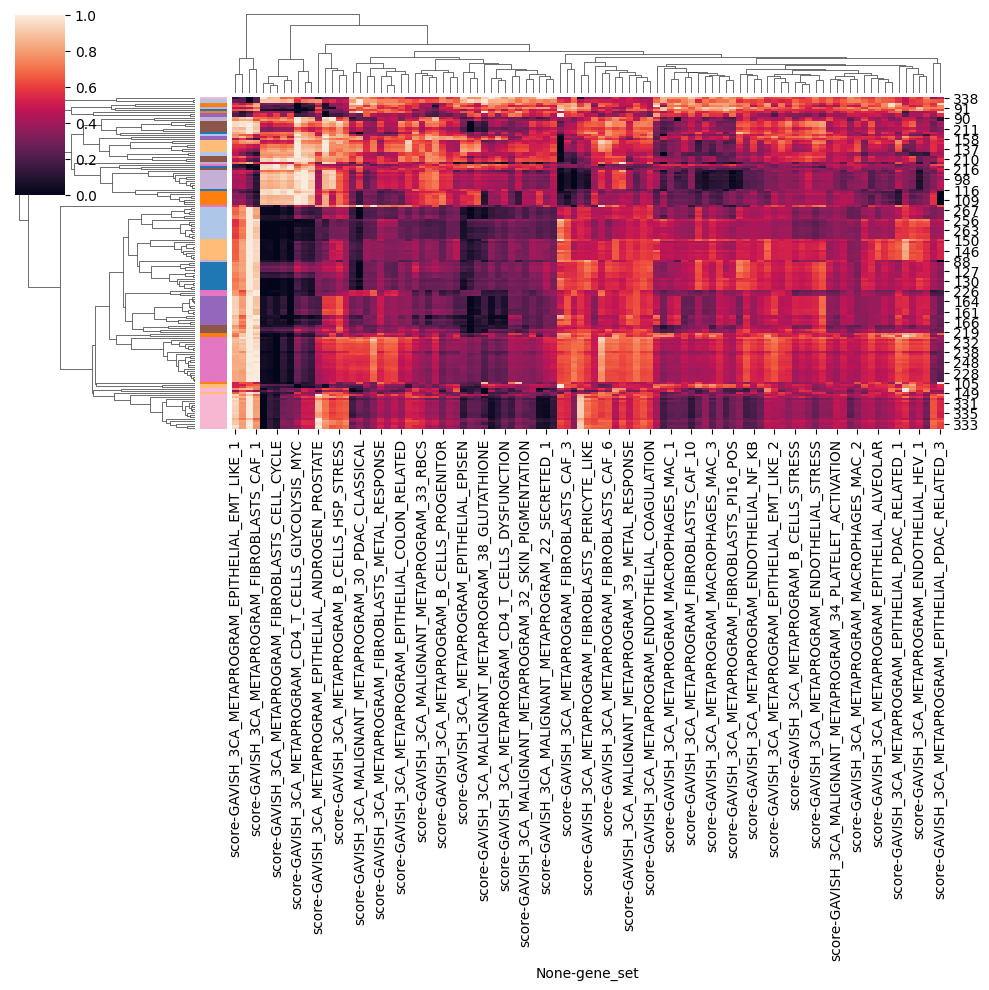

In [276]:
colors = [sns.color_palette('tab20')[case_order.index(z)] for z in visium_meta['case']]
visium_cg = sns.clustermap(visium_df[gs_order], standard_scale=0, row_colors=colors, col_cluster=True)

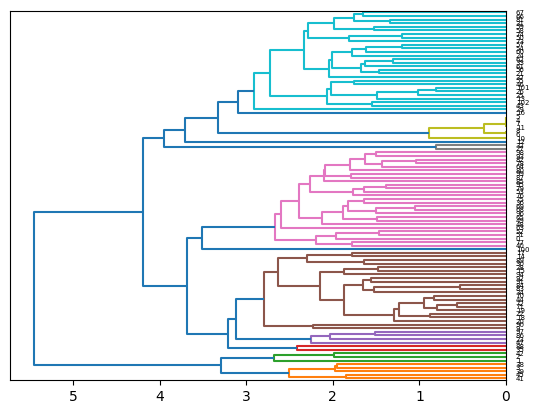

In [261]:
from scipy.cluster.hierarchy import dendrogram
dn = dendrogram(xenium_cg.dendrogram_col.linkage, color_threshold=3., orientation='left')

In [ ]:
case_to_volume_mask = {}

In [30]:
case = 'HT397B1'
level_to_dtype_to_volume = {}
for i in range(3):
    v = pickle.load(open(
        os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l{i}.pkl'), 'rb'))['labeled']
    level_to_dtype_to_volume[i] = v

In [32]:
np.unique(level_to_dtype_to_volume[2]['integrated'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [38]:
case_to_integrated['HT397B1']['visium']

A1BG       A2M    A4GALT      AAAS      AACS     AAGAB      AAK1  \
0  -0.294328 -0.543914 -0.450339 -0.439054 -0.418045 -0.346567 -0.371085   
1   1.164742  1.410245  1.635811  1.590037  1.582717  1.384281  1.199064   
2   1.410820  1.566035  1.951696  1.901902  1.905597  1.680290  1.401774   
3   0.143007  0.638243  0.298510  0.262789  0.214657  0.208740  0.326175   
4   1.553868  1.868335  2.179401  2.139637  2.120145  1.782206  1.588157   
5   1.118481  1.675403  1.677568  1.655676  1.594286  1.296012  1.286124   
6   0.218988  0.697437  0.432388  0.398447  0.350144  0.314000  0.399232   
7   0.049208  0.443747  0.156759  0.129248  0.089602  0.103308  0.199555   
8  -0.187079 -0.200111 -0.260478 -0.253786 -0.258219 -0.200929 -0.185989   
9   2.258847  2.274866  3.061818  2.991949  3.033580  2.660377  2.138445   
10  0.894478  1.230738  1.247237  1.217881  1.182126  0.975473  0.961971   
11  0.026820  0.481479  0.186735  0.149790  0.104426  0.117613  0.212933   
12  0.070123  0.478740  0.196781  0.166936  0.125726  0.133107  0.227163   
13  0.100960  0.656673  0.279015  0.235427  0.184700  0.196916  0.316595   
14  0.775044  1.487777  1.283639  1.252294  1.169998  0.964872  1.036031   
15 -0.130087  0.069712 -0.106685 -0.128203 -0.146524 -0.096449 -0.042867   
16 -0.178251 -0.130582 -0.208250 -0.218724 -0.224089 -0.171004 -0.145780   
17  0.192909  0.817648  0.342471  0.286804  0.253663  0.258696  0.414144   
18  0.205526  0.812543  0.340430  0.290484  0.247625  0.257538  0.402574   
19  0.106562  0.719756  0.221494  0.178741  0.125833  0.169821  0.314227   

       AAMDC      AAMP      AAR2  ...    ZSWIM8    ZSWIM9      ZW10    ZWILCH  \
0  -0.332054 -0.493185 -0.380375  ... -0.455457 -0.364958 -0.317168 -0.330333   
1   1.314542  1.633671  1.424630  ...  1.471185  1.372748  1.145851  1.280371   
2   1.590657  1.903408  1.702798  ...  1.728181  1.640200  1.376076  1.524265   
3   0.164500  0.397339  0.255164  ...  0.355397  0.208120  0.215111  0.242218   
4   1.713287  2.225816  1.852795  ...  2.021407  1.833931  1.516932  1.665396   
5   1.268947  1.794723  1.379759  ...  1.621265  1.406638  1.123387  1.263475   
6   0.286000  0.516325  0.356966  ...  0.441145  0.331030  0.278844  0.338894   
7   0.070881  0.231494  0.135003  ...  0.198620  0.097707  0.107226  0.135858   
8  -0.199021 -0.265372 -0.215039  ... -0.243917 -0.213199 -0.185501 -0.178222   
9   2.546915  2.949339  2.700769  ...  2.628236  2.609484  2.151493  2.411181   
10  0.913105  1.353627  1.035641  ...  1.281903  1.017173  0.911518  0.932594   
11  0.095816  0.252769  0.147871  ...  0.185297  0.116530  0.098186  0.156131   
12  0.101361  0.270587  0.166406  ...  0.229013  0.130646  0.131709  0.166319   
13  0.152293  0.375500  0.238871  ...  0.311943  0.182781  0.184251  0.231171   
14  0.943235  1.406674  1.055948  ...  1.233784  1.063671  0.831567  0.977573   
15 -0.107480 -0.081084 -0.093999  ... -0.101343 -0.114355 -0.093387 -0.066973   
16 -0.171512 -0.207275 -0.180332  ... -0.211871 -0.186954 -0.161791 -0.145112   
17  0.159518  0.476284  0.306465  ...  0.467312  0.206942  0.283316  0.287177   
18  0.158618  0.492029  0.302522  ...  0.479456  0.215606  0.278403  0.274295   
19  0.090038  0.366920  0.222380  ...  0.341805  0.137162  0.186627  0.192021   

       ZWINT      ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1  
0  -0.390452 -0.318879 -0.410236 -0.339289 -0.566562 -0.460525  
1   1.462710  1.173992  1.442756  1.273612  1.635163  1.622634  
2   1.748691  1.407310  1.695653  1.523910  1.869249  1.917668  
3   0.211605  0.194910  0.341465  0.207359  0.526479  0.297233  
4   1.954207  1.543846  1.907380  1.661694  2.241860  2.156119  
5   1.479690  1.131217  1.492465  1.242750  1.924517  1.693756  
6   0.329408  0.264482  0.424014  0.308225  0.638942  0.442583  
7   0.090515  0.092432  0.199452  0.104299  0.334960  0.160522  
8  -0.234407 -0.187931 -0.209674 -0.198119 -0.263282 -0.254498  
9   2.789653  2.225566  2.621124  2.440387  2.808845  3.042

In [ ]:
gene_sets = json.load(open(os.path.join(project_dir, 'analysis', 'gene_sets', 'c4.3ca.v2023.2.Hs.json')))
gene_sets.keys()

In [25]:
outputs['dtype_to_cluster_intensities']['dtype_projections']['integrated'][2]['visium']

A2M    A4GALT      AAAS      AACS     AADAT     AAGAB      AAK1  \
0   0.487440  0.207279  0.200390  0.136779  0.172406  0.130097  0.214920   
1   1.739788  0.832569  0.908840  0.741483  0.779180  0.574249  0.934964   
2   1.197124  0.533641  0.573762  0.458723  0.507811  0.360113  0.605047   
3   0.247848  0.104713  0.098793  0.046841  0.076788  0.048993  0.085912   
4   0.464481  0.202279  0.199250  0.129823  0.166877  0.116786  0.201545   
5   0.716810  0.306710  0.303499  0.221829  0.259290  0.198695  0.336118   
6   0.855434  0.390181  0.410128  0.301453  0.270357  0.238759  0.400331   
7  -0.463157 -0.207275 -0.245649 -0.172081 -0.197940 -0.150688 -0.253997   
8   0.430409  0.165554  0.127366  0.115050  0.136001  0.152294  0.186947   
9   0.337025  0.136200  0.108225  0.083798  0.103166  0.104747  0.142665   
10  0.044094  0.014984 -0.006725  0.004371  0.008034  0.006808  0.000860   
11  3.736785  2.759861  1.769047  1.290267  2.312648  1.290743  1.967179   
12  0.294206  0.136855  0.117399  0.105289  0.122384  0.097281  0.134289   
13  0.567054  0.257544  0.271376  0.185552  0.225164  0.141805  0.263738   
14 -0.571517 -0.255851 -0.300576 -0.209185 -0.242474 -0.180664 -0.307616   
15  0.642677  0.272671  0.264111  0.187373  0.223359  0.172755  0.294995   
16  0.787760  0.320962  0.295794  0.231685  0.266013  0.243308  0.360865   
17  0.775910  0.337115  0.327625  0.240132  0.280032  0.220173  0.365199   
18  0.693778  0.295362  0.287337  0.213440  0.247925  0.188570  0.322161   
19  0.821902  0.368213  0.389296  0.280385  0.324697  0.211344  0.400922   
20  0.682721  0.291309  0.298363  0.219200  0.253799  0.180028  0.322556   

       AAMDC      AAMP      AAR2  ...   ZSCAN30    ZSWIM7    ZSWIM8    ZSWIM9  \
0   0.215508  0.253610  0.148146  ...  0.151364  0.151268  0.190168  0.161041   
1   0.842168  1.186286  0.623877  ...  0.662849  0.642074  0.843681  0.741731   
2   0.581813  0.735030  0.381528  ...  0.443670  0.429497  0.552905  0.464489   
3   0.105750  0.107472  0.075552  ...  0.080844  0.065336  0.072485  0.074310   
4   0.205484  0.241458  0.142334  ...  0.146714  0.142484  0.173137  0.154409   
5   0.318715  0.390735  0.215633  ...  0.215487  0.231791  0.293039  0.238123   
6   0.367347  0.494492  0.287709  ...  0.256121  0.287760  0.347611  0.308287   
7  -0.216487 -0.301610 -0.154697  ... -0.156874 -0.170351 -0.205115 -0.177329   
8   0.180324  0.211170  0.130511  ...  0.103037  0.135048  0.205214  0.138352   
9   0.143437  0.157755  0.097317  ...  0.081996  0.101023  0.146217  0.103971   
10  0.018583  0.004140  0.010746  ...  0.013766  0.005493  0.017672  0.011528   
11  1.712190  2.580491  1.408040  ...  1.210272  1.041844  2.548028  3.214442   
12  0.137853  0.173176  0.101038  ...  0.104189  0.100065  0.146856  0.121591   
13  0.263872  0.322031  0.178634  ...  0.202935  0.183227  0.220089  0.205611   
14 -0.267288 -0.366817 -0.190078  ... -0.195676 -0.207146 -0.249017 -0.217708   
15  0.279239  0.338746  0.189364  ...  0.186955  0.200745  0.253732  0.207739   
16  0.336663  0.418233  0.240727  ...  0.213789  0.256691  0.343893  0.252730   
17  0.342942  0.424385  0.234662  ...  0.228616  0.249957  0.320620  0.266708   
18  0.309257  0.367715  0.199994  ...  0.202948  0.217865  0.277360  0.232017   
19  0.381757  0.474723  0.249763  ...  0.276728  0.276611  0.333845  0.282418   
20  0.307291  0.381504  0.205986  ...  0.213254  0.222870  0.277342  0.222359   

        ZW10      ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1  
0   0.174936  0.181466  0.164056  0.173538  0.374708  0.252944  
1   0.613997  0.841302  0.801516  0.818534  1.410510  1.060768  
2   0.441349  0.569228  0.505985  0.510662  0.930362  0.689861  
3   0.081764  0.070605  0.069914  0.077819  0.195737  0.120403  
4   0.164744  0.168975  0.157280  0.165920  0.365790  0.244812  
5   0.263737  0.282213  0.252011  0.260817  0.558444  0.382198  
6   0.301168  0.359533  0.357571  0.304192  0.737599  0.517470  
7  -0.165735 -0.217559 -0.203208 

In [28]:
d

(15, 172, 172)

In [19]:
case_to_integrated['HT397B1']['visium']

A1BG       A2M    A4GALT      AAAS      AACS     AAGAB      AAK1  \
0  -0.294328 -0.543914 -0.450339 -0.439054 -0.418045 -0.346567 -0.371085   
1   1.164742  1.410245  1.635811  1.590037  1.582717  1.384281  1.199064   
2   1.410820  1.566035  1.951696  1.901902  1.905597  1.680290  1.401774   
3   0.143007  0.638243  0.298510  0.262789  0.214657  0.208740  0.326175   
4   1.553868  1.868335  2.179401  2.139637  2.120145  1.782206  1.588157   
5   1.118481  1.675403  1.677568  1.655676  1.594286  1.296012  1.286124   
6   0.218988  0.697437  0.432388  0.398447  0.350144  0.314000  0.399232   
7   0.049208  0.443747  0.156759  0.129248  0.089602  0.103308  0.199555   
8  -0.187079 -0.200111 -0.260478 -0.253786 -0.258219 -0.200929 -0.185989   
9   2.258847  2.274866  3.061818  2.991949  3.033580  2.660377  2.138445   
10  0.894478  1.230738  1.247237  1.217881  1.182126  0.975473  0.961971   
11  0.026820  0.481479  0.186735  0.149790  0.104426  0.117613  0.212933   
12  0.070123  0.478740  0.196781  0.166936  0.125726  0.133107  0.227163   
13  0.100960  0.656673  0.279015  0.235427  0.184700  0.196916  0.316595   
14  0.775044  1.487777  1.283639  1.252294  1.169998  0.964872  1.036031   
15 -0.130087  0.069712 -0.106685 -0.128203 -0.146524 -0.096449 -0.042867   
16 -0.178251 -0.130582 -0.208250 -0.218724 -0.224089 -0.171004 -0.145780   
17  0.192909  0.817648  0.342471  0.286804  0.253663  0.258696  0.414144   
18  0.205526  0.812543  0.340430  0.290484  0.247625  0.257538  0.402574   
19  0.106562  0.719756  0.221494  0.178741  0.125833  0.169821  0.314227   

       AAMDC      AAMP      AAR2  ...    ZSWIM8    ZSWIM9      ZW10    ZWILCH  \
0  -0.332054 -0.493185 -0.380375  ... -0.455457 -0.364958 -0.317168 -0.330333   
1   1.314542  1.633671  1.424630  ...  1.471185  1.372748  1.145851  1.280371   
2   1.590657  1.903408  1.702798  ...  1.728181  1.640200  1.376076  1.524265   
3   0.164500  0.397339  0.255164  ...  0.355397  0.208120  0.215111  0.242218   
4   1.713287  2.225816  1.852795  ...  2.021407  1.833931  1.516932  1.665396   
5   1.268947  1.794723  1.379759  ...  1.621265  1.406638  1.123387  1.263475   
6   0.286000  0.516325  0.356966  ...  0.441145  0.331030  0.278844  0.338894   
7   0.070881  0.231494  0.135003  ...  0.198620  0.097707  0.107226  0.135858   
8  -0.199021 -0.265372 -0.215039  ... -0.243917 -0.213199 -0.185501 -0.178222   
9   2.546915  2.949339  2.700769  ...  2.628236  2.609484  2.151493  2.411181   
10  0.913105  1.353627  1.035641  ...  1.281903  1.017173  0.911518  0.932594   
11  0.095816  0.252769  0.147871  ...  0.185297  0.116530  0.098186  0.156131   
12  0.101361  0.270587  0.166406  ...  0.229013  0.130646  0.131709  0.166319   
13  0.152293  0.375500  0.238871  ...  0.311943  0.182781  0.184251  0.231171   
14  0.943235  1.406674  1.055948  ...  1.233784  1.063671  0.831567  0.977573   
15 -0.107480 -0.081084 -0.093999  ... -0.101343 -0.114355 -0.093387 -0.066973   
16 -0.171512 -0.207275 -0.180332  ... -0.211871 -0.186954 -0.161791 -0.145112   
17  0.159518  0.476284  0.306465  ...  0.467312  0.206942  0.283316  0.287177   
18  0.158618  0.492029  0.302522  ...  0.479456  0.215606  0.278403  0.274295   
19  0.090038  0.366920  0.222380  ...  0.341805  0.137162  0.186627  0.192021   

       ZWINT      ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1  
0  -0.390452 -0.318879 -0.410236 -0.339289 -0.566562 -0.460525  
1   1.462710  1.173992  1.442756  1.273612  1.635163  1.622634  
2   1.748691  1.407310  1.695653  1.523910  1.869249  1.917668  
3   0.211605  0.194910  0.341465  0.207359  0.526479  0.297233  
4   1.954207  1.543846  1.907380  1.661694  2.241860  2.156119  
5   1.479690  1.131217  1.492465  1.242750  1.924517  1.693756  
6   0.329408  0.264482  0.424014  0.308225  0.638942  0.442583  
7   0.090515  0.092432  0.199452  0.104299  0.334960  0.160522  
8  -0.234407 -0.187931 -0.209674 -0.198119 -0.263282 -0.254498  
9   2.789653  2.225566  2.621124  2.440387  2.808845  3.042

In [ ]:
data = []

for case in case_order:
    print(case)
    disease = case_to_disease[case]
    dtype_to_specific = case_to_specific[case]
    dtype_to_integrated = case_to_integrated[case]
    
    volume = dtype_to_integrated['integrated']
    
    outputs = pickle.load(open(
        os.path.join(project_dir, case, 'mushroom_50res', 'outputs.pkl'), 'rb'))
    
    for volume_dtype in volume_dtypes:
        if volume_dtype in outputs['dtype_to_volume']:
            volume = outputs['dtype_to_volume'][volume_dtype]
            labels, counts = np.unique(volume, return_counts=True)
            total = counts.sum()
            label_to_count = {l:c for l, c in zip(labels, counts)}
        
        if volume_dtype == 'integrated':
            for quant_dtype in quant_dtypes:
                if quant_dtype in dtype_to_integrated:
                    df = dtype_to_integrated[quant_dtype]
                    for name, gs in gene_sets.items():
                        genes = [g for g in gs['geneSymbols'] if g in df.columns]
                        if genes:
                            nbhd_scores = df[genes].values.mean(1)
                            for nbhd, score in zip(df.index.to_list(), nbhd_scores):
                                area = label_to_count[nbhd]
                                data.append([case, disease, quant_dtype, 'integrated', name, nbhd, area, area / total, score])
        else:
            if volume_dtype in dtype_to_specific:
                df = dtype_to_specific[volume_dtype]
                for name, gs in gene_sets.items():
                    genes = [g for g in gs['geneSymbols'] if g in df.columns]
                    if genes:
                        nbhd_scores = df[genes].values.mean(1)
                        for nbhd, score in zip(df.index.to_list(), nbhd_scores):
                            area = label_to_count[nbhd]
                            data.append([case, disease, volume_dtype, 'specific', name, nbhd, area, area / total, score])
score_df = pd.DataFrame(data=data, columns=['case', 'disease', 'dtype', 'type', 'gene_set', 'nbhd', 'area', 'area_frac', 'score'])
score_df

In [18]:
# case = 'C3L-00982'
case = 'HT397B1'
mushroom = Mushroom.from_config(os.path.join(project_dir, case, 'mushroom_50res'))

INFO:root:loading spore for batch2_he
INFO:root:data mask detected
INFO:root:starting batch2_he processing
INFO:root:6 sections detected: ['HT397B1-U4', 'HT397B1-U8', 'HT397B1-U11', 'HT397B1-U16', 'HT397B1-U20', 'HT397B1-U28']
INFO:root:processing sections
INFO:root:generating image data for section HT397B1-U4


0.007287140063108625


INFO:root:generating image data for section HT397B1-U8
INFO:root:generating image data for section HT397B1-U11
INFO:root:generating image data for section HT397B1-U16
INFO:root:generating image data for section HT397B1-U20
INFO:root:generating image data for section HT397B1-U28
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 6 sections detected: [('HT397B1-U4', 'batch2_he'), ('HT397B1-U8', 'batch2_he'), ('HT397B1-U11', 'batch2_he'), ('HT397B1-U16', 'batch2_he'), ('HT397B1-U20', 'batch2_he'), ('HT397B1-U28', 'batch2_he')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpqwzsw8wq
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpqwzsw8wq/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized


batch2_he torch.Size([3, 135, 133])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/batch2_he_chkpts/last-v1.ckpt
INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['HT397B1-U1', 'HT397B1-U21']
INFO:root:processing sections
INFO:root:generating image data for section HT397B1-U1


0.007287140063108625


INFO:root:generating image data for section HT397B1-U21
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT397B1-U1', 'he'), ('HT397B1-U21', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/he_chkpts/last-v1.ckpt


he torch.Size([3, 135, 133])


INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 24 channels
INFO:root:4 sections detected: ['HT397B1-U2', 'HT397B1-U12', 'HT397B1-U22', 'HT397B1-U31']
INFO:root:processing sections
INFO:root:generating image data for section HT397B1-U2


0.007287140063108625


INFO:root:generating image data for section HT397B1-U12
INFO:root:generating image data for section HT397B1-U22
INFO:root:generating image data for section HT397B1-U31
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 4 sections detected: [('HT397B1-U2', 'multiplex'), ('HT397B1-U12', 'multiplex'), ('HT397B1-U22', 'multiplex'), ('HT397B1-U31', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/multiplex_chkpts/last-v1.ckpt
INFO:root:loading spore for visium
INFO:root:data mask detected
INFO:root:starting visium processing


multiplex torch.Size([24, 135, 133])


INFO:root:using 9675 channels
INFO:root:2 sections detected: ['HT397B1-U1', 'HT397B1-U21']
INFO:root:processing sections


ppm 0.36435700315543124 target_ppm 100
tiling size 274


INFO:root:generating image data for section HT397B1-U1
INFO:root:generating image data for section HT397B1-U21
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT397B1-U1', 'visium'), ('HT397B1-U21', 'visium')]
INFO:root:creating data loaders
INFO:root:creating ViT


visium torch.Size([9675, 69, 68])


INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/visium_chkpts/last-v1.ckpt
INFO:root:chkpt files detected, embedding to spores
INFO:root:embedding batch2_he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding visium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

In [19]:
outputs = pickle.load(open(os.path.join(project_dir, case, 'mushroom_50res', 'outputs.pkl'), 'rb'))
outputs.keys()

dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities', 'dtype_to_cluster_to_agg'])

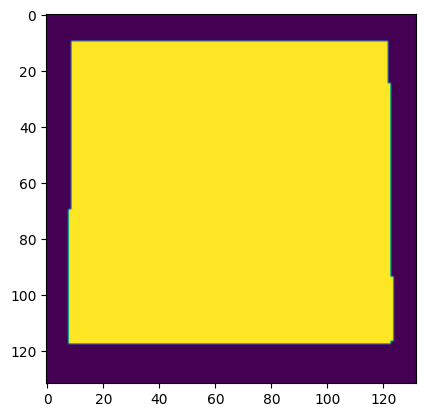

In [33]:
mask_fp = os.path.join(project_dir, case, 'masks', 'tissue_mask.tif')
tissue_mask = tifffile.imread(mask_fp)
target_size  = outputs['dtype_to_clusters']['integrated'][0].shape[1:]
tissue_mask = utils.rescale(tissue_mask, size=target_size, dim_order='h w', target_dtype=bool)
plt.imshow(tissue_mask)

In [35]:
level_to_dtype_to_volume = {}
for i in range(3):
    v = pickle.load(open(
        os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l{i}.pkl'), 'rb'))['labeled']
    level_to_dtype_to_volume[i] = v

In [77]:
v_params = yaml.safe_load(open(os.path.join(project_dir, case, 'mushroom_50res', 'nbhd_volume_params.yaml')))
z_sf = 50. * v_params['z_scaler']
z_sf

10.0

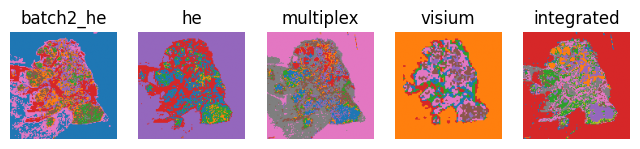

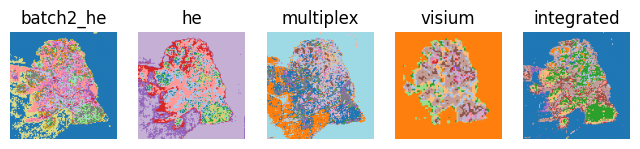

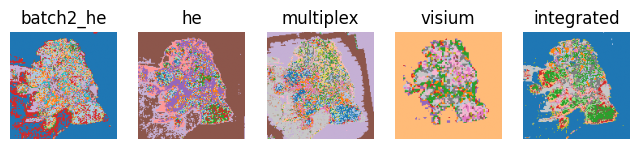

In [36]:
for i in range(mushroom.num_levels):
    mushroom.display_volumes(positions=[2], dtype_to_volume=level_to_dtype_to_volume[i], figsize=(8, 4))
    plt.show()

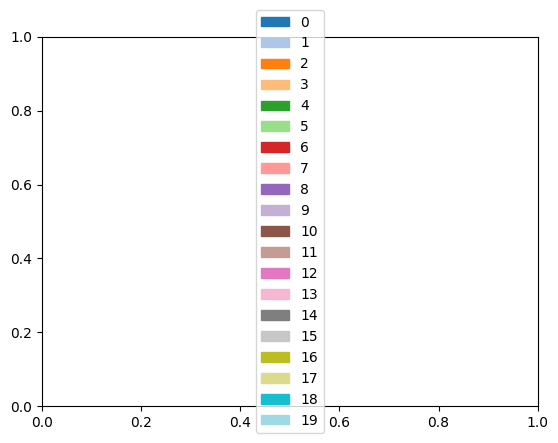

In [240]:
cmap = vis_utils.get_cmap(level_to_dtype_to_volume[2]['integrated'].max())
vis_utils.display_legend(np.unique(level_to_dtype_to_volume[2]['integrated']), cmap)

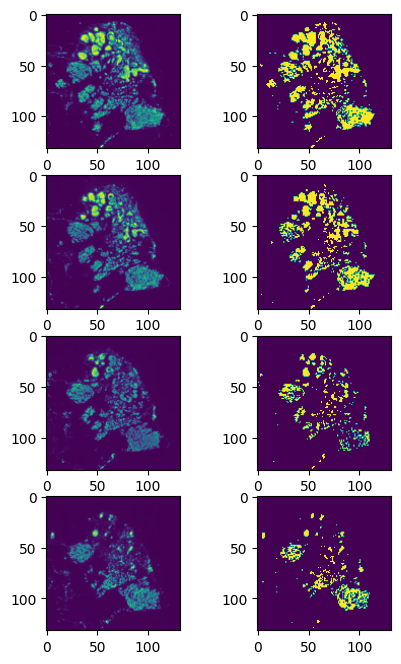

In [41]:
thresh = 1.5
spore = mushroom.dtype_to_spore['multiplex']
idx = spore.learner_data.dtype_to_channels['multiplex'].index('Pan-Cytokeratin')
nrows = len(spore.true_pixels)
fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(5, nrows * 2))
if nrows == 1:
    axs = rearrange(axs, 'n -> 1 n')

for i, tp in enumerate(spore.true_pixels):
    img = tp[..., idx]
    axs[i, 0].imshow(img)
    axs[i, 1].imshow(img > thresh)

In [45]:
tumor_mask = np.stack(spore.true_pixels)[..., idx] > thresh
tumor_mask.shape

(4, 132, 132)

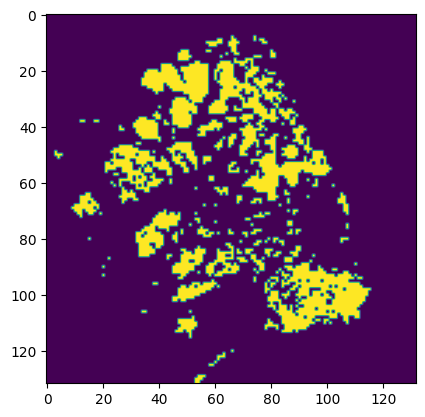

In [459]:
plt.imshow(tumor_mask[0])

In [103]:
positions = [pos for pos, (sid, dtype) in zip(mushroom.section_positions, mushroom.section_ids)
            if dtype == 'multiplex']
positions

[1, 11, 21, 30]

In [104]:
level_to_dtype_to_volume[2]['integrated'][positions].shape

(4, 132, 132)

In [445]:
from collections import Counter
volume = level_to_dtype_to_volume[2]['integrated']
data, labels = [], np.unique(volume)
for label in labels:
    masks = volume==label
    contacts = []
    for m, v in zip(masks, volume):
        expanded = skimage.morphology.binary_dilation(m)
        contacts += [l for l in v[expanded] if l != label]
    counts = Counter(contacts)
    data.append([counts.get(l, 0) for l in labels])
contact_df = pd.DataFrame(data=data, columns=labels, index=labels)
contact_df /= np.expand_dims(contact_df.sum(1).values, -1)
contact_df

0         1         2         3         4         5         6   \
0   0.000000  0.024098  0.012809  0.024408  0.008436  0.002636  0.012405   
1   0.057937  0.000000  0.181549  0.148485  0.182503  0.025778  0.002110   
2   0.064287  0.453051  0.000000  0.094123  0.128575  0.015537  0.003603   
3   0.026370  0.075595  0.022422  0.000000  0.089515  0.035650  0.115742   
4   0.009627  0.118498  0.036036  0.129343  0.000000  0.210701  0.041288   
5   0.005155  0.028028  0.007625  0.071091  0.379081  0.000000  0.075279   
6   0.025533  0.002346  0.001146  0.235201  0.065906  0.078891  0.000000   
7   0.046124  0.025849  0.005917  0.207107  0.020337  0.029524  0.098508   
8   0.191237  0.017824  0.013368  0.037133  0.003713  0.007798  0.028593   
9   0.032002  0.137638  0.016992  0.007080  0.393656  0.089776  0.000000   
10  0.010157  0.055022  0.015952  0.263522  0.383101  0.094342  0.049040   
11  0.044032  0.004750  0.000798  0.062675  0.007745  0.016926  0.121597   
12  0.100182  0.084094  0.031768  0.160404  0.028863  0.011210  0.008603   
13  0.019175  0.015958  0.003003  0.107288  0.012698  0.019304  0.029814   
14  0.042332  0.049139  0.009422  0.057344  0.177306  0.152150  0.016139   
15  0.235085  0.016065  0.004065  0.045566  0.005939  0.005793  0.023952   
16  0.500825  0.016546  0.004678  0.036466  0.003718  0.002881  0.022727   
17  0.021429  0.025000  0.000000  0.021429  0.017857  0.000000  0.000000   
18  0.031609  0.051724  0.000000  0.034483  0.005747  0.002874  0.005747   
19  0.082237  0.059211  0.000000  0.121711  0.000000  0.039474  0.006579   

          7         8         9         10        11        12        13  \
0   0.040069  0.011754  0.004125  0.004280  0.026641  0.066245  0.011940   
1   0.042812  0.002713  0.023717  0.045375  0.007035  0.127280  0.018944   
2   0.022517  0.004278  0.006417  0.027246  0.002252  0.101666  0.007543   
3   0.168425  0.002824  0.000721  0.090466  0.044469  0.119776  0.064557   
4   0.023365  0.000381  0.041592  0.169261  0.006317  0.028464  0.010655   
5   0.048540  0.001128  0.016967  0.078769  0.021209  0.016377  0.022981   
6   0.175405  0.003983  0.000000  0.040810  0.190791  0.012439  0.036227   
7   0.000000  0.011461  0.000810  0.030708  0.081784  0.062817  0.115731   
8   0.144077  0.000000  0.000000  0.021166  0.011140  0.021166  0.043075   
9   0.007080  0.000000  0.000000  0.004815  0.006231  0.017559  0.008779   
10  0.073654  0.004113  0.001059  0.000000  0.001184  0.012338  0.007478   
11  0.100120  0.001277  0.000878  0.000719  0.000000  0.044631  0.105190   
12  0.075863  0.002048  0.002421  0.006815  0.042605  0.000000  0.072362   
13  0.168418  0.004805  0.001416  0.005191  0.121831  0.085754  0.000000   
14  0.064827  0.001307  0.032549  0.007484  0.063340  0.079118  0.069831   
15  0.067522  0.007059  0.002751  0.001460  0.153811  0.095490  0.114427   
16  0.075074  0.014921  0.001428  0.005097  0.042917  0.064659  0.025558   
17  0.135714  0.014286  0.000000  0.000000  0.071429  0.221429  0.182143   
18  0.074713  0.000000  0.000000  0.000000  0.057471  0.163793  0.189655   
19  0.032895  0.000000  0.000000  0.000000  0.013158  0.148026  0.092105   

          14        15        16        17        18        19  
0   0.036999  0.281944  0.429816  0.000186  0.000341  0.000868  
1   0.059444  0.036028  0.036179  0.000352  0.000904  0.000854  
2   0.026008  0.020603  0.022292  0.000000  0.000000  0.000000  
3   0.038561  0.058015  0.045478  0.000173  0.000317  0.000922  
4   0.157616  0.010427  0.006165  0.000190  0.000076  0.000000  
5   0.207045  0.013424  0.006927  0.000000  0.000054  0.000322  
6   0.018823  0.060996  0.051285  0.000000  0.000109  0.000109  
7   0.052415  0.097044  0.111807  0.001028  0.000779  0.000249  
8   0.010397  0.150390  0.297438  0.001485  0.000000  0.000000  
9   0.227981  0.032285  0.018125  0.000000  0.000000  0.000000  
10  0.011279  0.003926  0.013833  0.000000  0.000000  0.000000  
11  0.059281  0.344870  0.083194  0.

In [458]:
from collections import Counter
volume = level_to_dtype_to_volume[2]['integrated']
data, labels = [], np.unique(volume)
for label in labels:
    contacts = 0
    for m, v in zip(tumor_mask, volume):
        expanded = skimage.morphology.binary_dilation(m)
        boundary = expanded ^ m
        contacts += (v[boundary] == label).sum()
    data.append(contacts)
contact_df = pd.DataFrame(data=data, index=labels)
contact_df /= contact_df.sum()
contact_df

0
0   0.050924
1   0.040482
2   0.021526
3   0.070201
4   0.225703
5   0.135743
6   0.055743
7   0.038554
8   0.000161
9   0.029076
10  0.037269
11  0.025703
12  0.034056
13  0.021847
14  0.144739
15  0.049960
16  0.018313
17  0.000000
18  0.000000
19  0.000000

In [433]:
import skimage
def get_profiles(volume, label_volume, mask, tumor_dist=0., tme_dist=5., n=1000, z_sf=10.):
    max_bounds = np.asarray(mask.shape) - 1
    min_bounds = (0, 0, 0)
    
    verts, faces, normals, values = skimage.measure.marching_cubes(mask)
    
    idxs = np.random.choice(np.arange(verts.shape[0]), size=n, replace=True)
    profiles = []
    label_profiles = []
    for idx in idxs:
        start = verts[idx]
        stop = start.copy()
        stop[0] = start[0] + (normals[idx][0] * (tme_dist / z_sf)) # depth direction needs to be scaled
        stop[1:] = start[1:] + (normals[idx][1:] * tme_dist)
        
        start[0] = start[0] - (normals[idx][0] * (tumor_dist / z_sf)) # depth direction needs to be scaled
        start[1:] = start[1:] - (normals[idx][1:] * tumor_dist)
        
        if (stop > max_bounds).sum() == 0 and (stop < min_bounds).sum() == 0:
            if (start > max_bounds).sum() == 0 and (start < min_bounds).sum() == 0:
                line = skimage.draw.line_nd(start, stop, integer=True)
                profile = volume[line]
                profile = np.pad(profile, ((0, int(tumor_dist + tme_dist) - len(profile)), (0, 0)))
                profiles.append(profile)

                profile = label_volume[line]
                profile = np.pad(profile, (0, int(tumor_dist + tme_dist) - len(profile)))
                label_profiles.append(profile)
    
    return np.stack(profiles), np.stack(label_profiles)

# profiles, label_profiles = get_profiles(
#     np.stack(spore.true_pixels), level_to_dtype_to_volume[2]['integrated'][positions], tumor_mask)
profiles, label_profiles = get_profiles(
    np.stack(spore.predicted_pixels[2]), level_to_dtype_to_volume[2]['integrated'][positions], tumor_mask)
# profiles, label_profiles = get_profiles(
#     np.stack(spore.predicted_pixels[2]), level_to_dtype_to_volume[2]['multiplex'][positions], tumor_mask)
profiles.shape, label_profiles.shape

((922, 5, 24), (922, 5))

In [434]:
# x = rearrange(profiles, 'n bin c -> n (bin c)')
# # x = profiles.mean(1)
# # x = profiles[:, 0]
# cg = sns.clustermap(x, col_cluster=False)

In [435]:
# profiles = profiles[cg.dendrogram_row.reordered_ind]
# label_profiles = label_profiles[cg.dendrogram_row.reordered_ind]
# profiles.shape, label_profiles.shape

In [436]:
data = []
labels = np.unique(label_profiles)
count_df = pd.DataFrame(np.zeros((len(label_profiles), len(labels)), dtype=int), columns=labels)
for i, profile in enumerate(label_profiles):
    for j, l in enumerate(profile):
        count_df.loc[i, l] += 1
count_df 

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0     3   0   0   0   0   1   0   0   0   0   0   0   1   0   0   0   0   0   
1     4   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   
2     0   0   0   0   1   0   0   0   0   0   0   0   0   0   3   0   1   0   
3     0   0   0   1   0   0   0   1   0   0   0   1   0   0   0   2   0   0   
4     0   0   0   1   0   0   1   0   0   0   0   1   0   0   0   2   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
917   2   0   0   1   0   0   0   0   0   0   0   0   0   2   0   0   0   0   
918   4   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
919   0   0   0   4   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
920   0   0   0   2   0   2   1   0   0   0   0   0   0   0   0   0   0   0   
921   1   0   0   0   0   0   0   0   0   0   0   2   0   0   0   2   0   0   

     19  
0     0  
1     0  
2     0  
3     0  
4     0  
..   ..  
917   0  
918   0  
919   0  
920   0  
921   0  

[922 rows x 19 columns]

[1, 2, 6, 12, 3, 4, 10, 0, 8, 5, 11, 15, 16, 9, 13, 14, 18, 7, 17, 19]

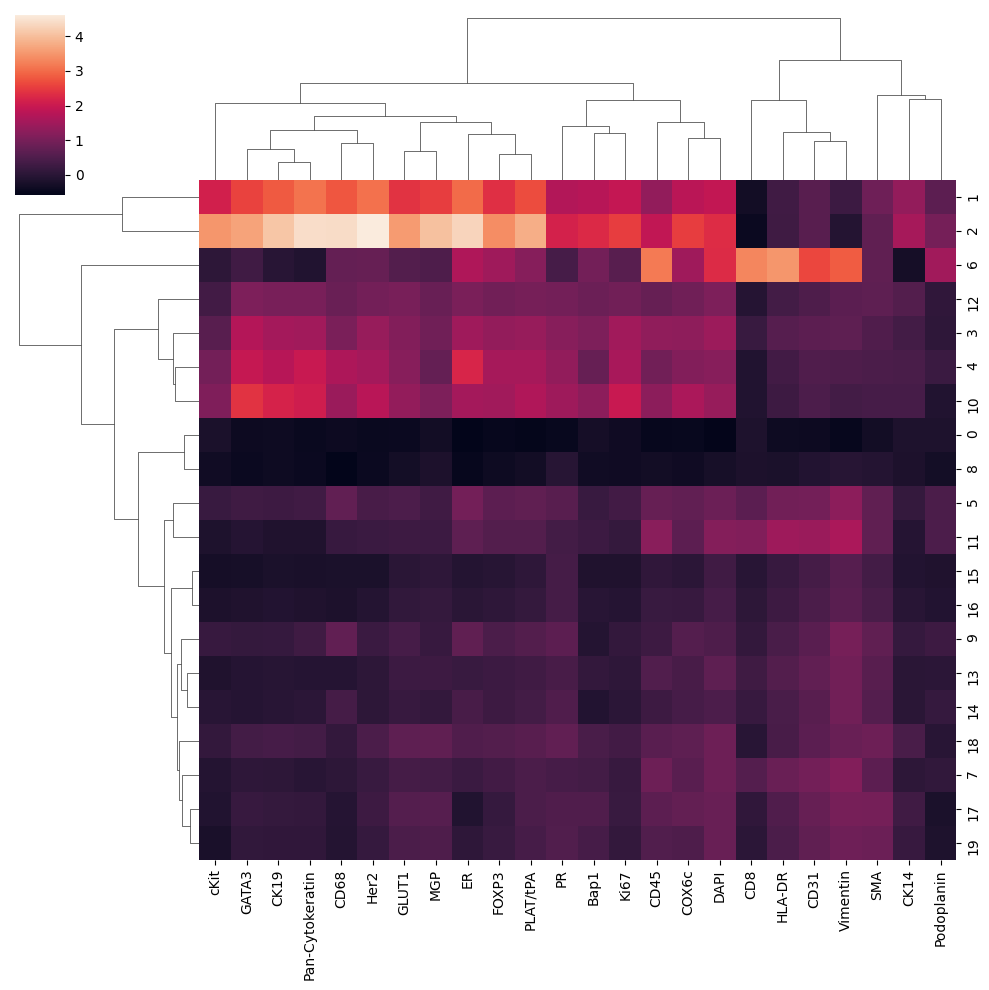

In [437]:
df = outputs['dtype_to_cluster_intensities']['integrated'][2]['multiplex']
# df = df[[c for c in df.columns if c not in [
#     'DAPI', 'CD45'
# ]]]
cg = sns.clustermap(df)
label_order = cg.dendrogram_row.reordered_ind
label_order

In [438]:
sort_df = pd.DataFrame(np.stack(([1,2,3],[4,5,6])).T)
sort_df

0  1
0  1  4
1  2  5
2  3  6

In [439]:
# max_labels = count_df.columns[count_df.values.argmax(1)].to_list()
# first_labels = label_profiles[:, 0]

# max_labels_idx = [label_order.index(x) for x in max_labels]
# first_labels_idx = [label_order.index(x) for x in first_labels]

# sort_df = pd.DataFrame(data=np.stack((first_labels_idx, max_labels_idx)).T)
# idxs = sort_df.sort_values(by=list(sort_df.columns)).index.to_list()

# label_profiles = label_profiles[idxs]

In [440]:
# max_labels = count_df.columns[count_df.values.argmax(1)]
# idxs = np.argsort([label_order.index(x) for x in max_labels])
# label_profiles = label_profiles[idxs]
# # sorted(max_labels, key=lambda x: label_order.index(x))

In [441]:
# # background = [0]
# # label_order = count_df.sum(0).sort_values(ascending=False).index.to_list()
# count_df = count_df.sort_values([l for l in label_order if l in count_df.columns], ascending=False)
# label_profiles = label_profiles[count_df.index.to_list()]

In [442]:
# n = 10.
# weights = np.flip(np.arange(1, label_profiles.shape[1] + 1) * n)
weights = np.asarray([1., .2, .1, .05, .01])
ordering = np.vectorize(label_order.index)(label_profiles).astype(float)
ordering /= ordering.max()
idxs = np.argsort((ordering * weights).sum(1))
label_profiles = label_profiles[idxs]

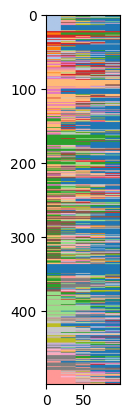

In [443]:
labeled = utils.rescale(label_profiles, size=(500, 100), dim_order='h w', target_dtype=int, antialias=False, interpolation=TF.InterpolationMode.NEAREST)
rgb = vis_utils.display_labeled_as_rgb(labeled)
plt.imshow(rgb)

In [421]:
import torchvision.transforms.functional as TF

In [258]:
dtype_to_df = mushroom.calculate_cluster_intensities(
    level=2, projection_dtype='integrated', dtype_to_volume=level_to_dtype_to_volume[2], use_predicted=False)
dtype_to_df.keys()

dict_keys(['batch2_he', 'he', 'multiplex', 'visium'])

In [259]:
dtype_to_df['multiplex'][['Pan-Cytokeratin']]

Pan-Cytokeratin
0         -0.434623
1          3.438769
2          4.468661
3          1.689319
4          2.110534
5          0.400373
6         -0.106279
7          0.071598
8         -0.309054
9          0.305129
10         2.165610
11        -0.285934
12         1.299634
13        -0.044440
14        -0.002260
15        -0.318511
16        -0.107489
17         0.174035
18         0.141680
19         0.233888

In [260]:
dtype_to_df['visium'][['EPCAM']]

EPCAM
0  -0.493039
1   1.885840
2   2.433446
3   0.334307
4   2.359307
5   1.679420
6   0.230122
7   0.084881
8  -0.161663
9   3.133486
10  1.375720
11 -0.040639
12  0.214125
13  0.131119
14  1.262583
15 -0.219691
16 -0.288363
17  0.019427
18  0.107317
19  0.051555

In [261]:
threshold = 1.
seeds = [i for i, val in zip(dtype_to_df['multiplex'].index, dtype_to_df['multiplex']['Pan-Cytokeratin'])
        if val > threshold]
seeds

[1, 2, 3, 4, 10, 12]

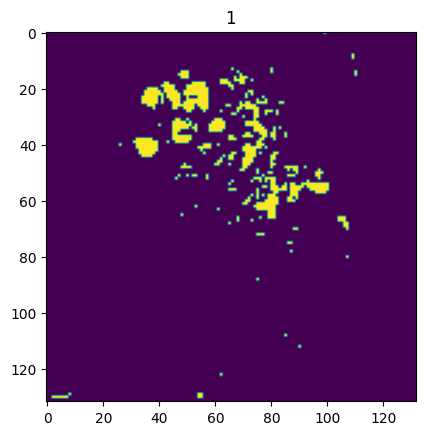

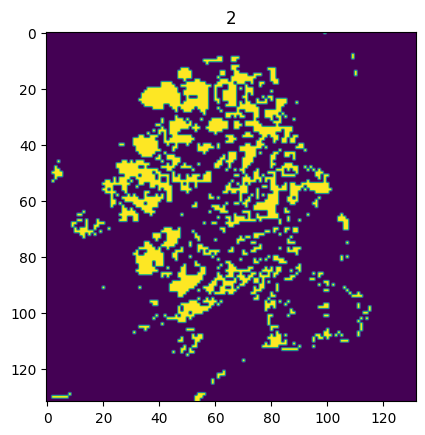

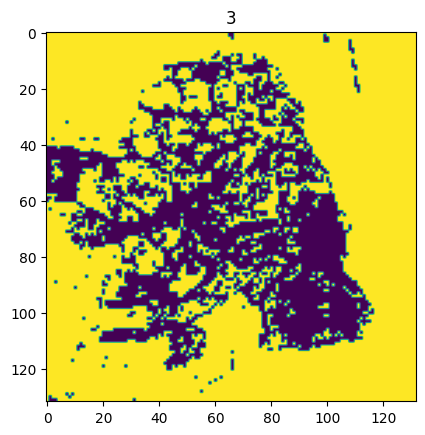

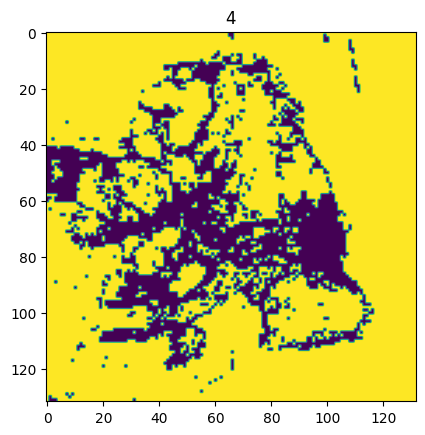

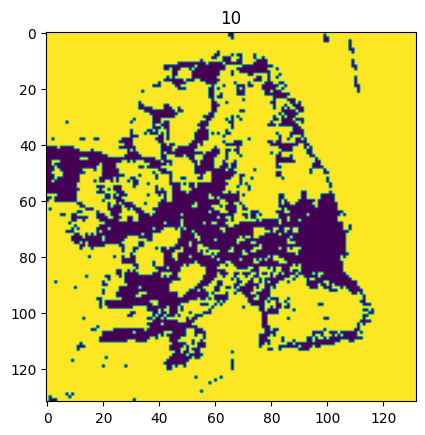

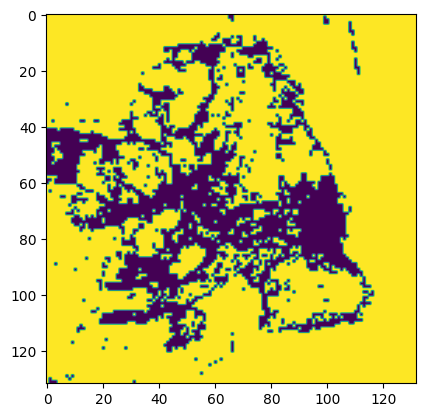

In [256]:
v = level_to_dtype_to_volume[0]['integrated'][section_idx]
mask = np.zeros_like(v, dtype=bool)
for label in seeds:
    mask |= v==label
    plt.imshow(mask)
    plt.title(label)
    plt.show()
plt.imshow(mask)

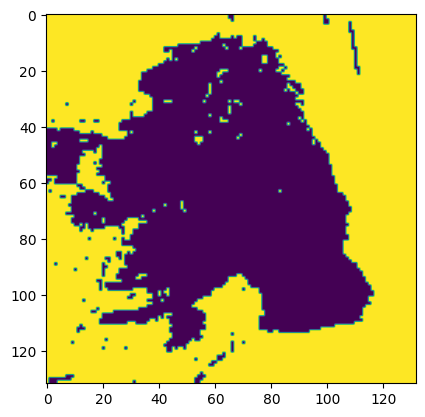

In [257]:
plt.imshow(v==3)

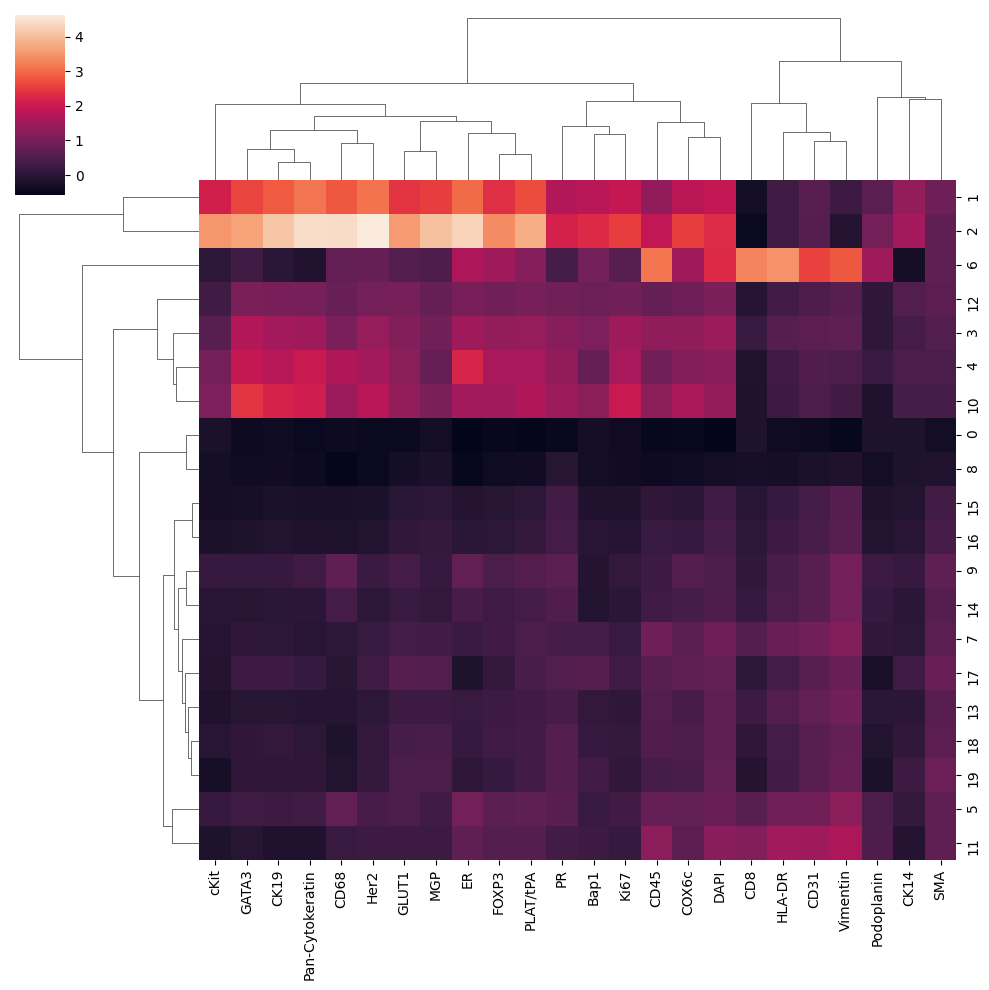

In [252]:
sns.clustermap(data=dtype_to_df['multiplex'])

In [182]:
from collections import Counter
volume = level_to_dtype_to_volume[0]['integrated']
data, labels = [], np.unique(volume)
for label in labels:
    masks = volume==label
    contacts = []
    for m, v in zip(masks, volume):
        expanded = skimage.morphology.binary_dilation(m)
        contacts += [l for l in v[expanded] if l != label]
    counts = Counter(contacts)
    data.append([counts.get(l, 0) for l in labels])
contact_df = pd.DataFrame(data=data, columns=labels, index=labels)
contact_df /= np.expand_dims(contact_df.sum(1).values, -1)
contact_df

0         1         2         3         4         5         6  \
0  0.000000  0.186290  0.095805  0.018623  0.046186  0.076873  0.566696   
1  0.184958  0.000000  0.063565  0.028663  0.369610  0.157744  0.194680   
2  0.386797  0.275360  0.000000  0.083254  0.155046  0.050677  0.047660   
3  0.068594  0.147276  0.108944  0.000000  0.502354  0.102219  0.049092   
4  0.040232  0.415459  0.040725  0.094177  0.000000  0.258688  0.128175   
5  0.066700  0.176116  0.013903  0.024639  0.259962  0.000000  0.409579   
6  0.386199  0.173811  0.010597  0.010061  0.091754  0.250446  0.000000   
7  0.041491  0.002813  0.001406  0.020394  0.081575  0.208158  0.644163   

          7  
0  0.009528  
1  0.000780  
2  0.001207  
3  0.021520  
4  0.022544  
5  0.049101  
6  0.077132  
7  0.000000

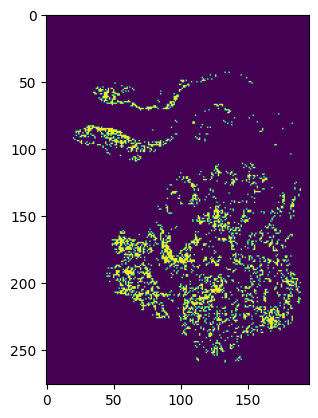

In [214]:
seed = 4
masks = level_to_dtype_to_volume[0]['integrated']==seed
m = masks[section_idx]
plt.imshow(m)

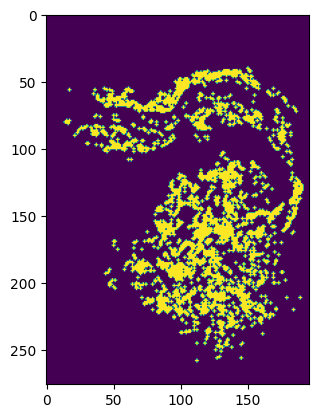

In [171]:
expanded = skimage.morphology.binary_dilation(m)

plt.imshow(expanded)

In [172]:
v = dtype_to_volume['integrated'][section_idx]
v.shape

(276, 196)

In [175]:
contacts = [l for l in v[expanded] if l != seed]
contacts

[1,
 6,
 1,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 0,
 6,
 6,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 6,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 7,
 7,
 4,
 7,
 6,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 6,
 7,
 6,
 6,
 6,
 7,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 7,
 4,
 7,
 6,
 7,
 6,
 7,
 7,
 7,
 7,
 6,
 4,
 7,
 7,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 6,
 4,
 6,
 6,
 7,
 6,
 6,
 6,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 4,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 6,
 6,
 6,
 6,
 4,
 4,
 4,
 6,
 6,
 7,
 7,
 7,
 4,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 6,
 6,
 6,
 6,
 4,
 4,
 6,
 4,
 4,
 4,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 6,
 6,
 6,
 7,
 7,
 7,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 4,
 7,
 6,
 6,
 4,
 4,
 4,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 4,
 4,
 4,
 6,
 6,
 7,
 6,


In [112]:
dtype = 'xenium'

In [114]:
volume = level_to_dtype_to_volume[2][dtype]
volume.shape

(7, 276, 196)

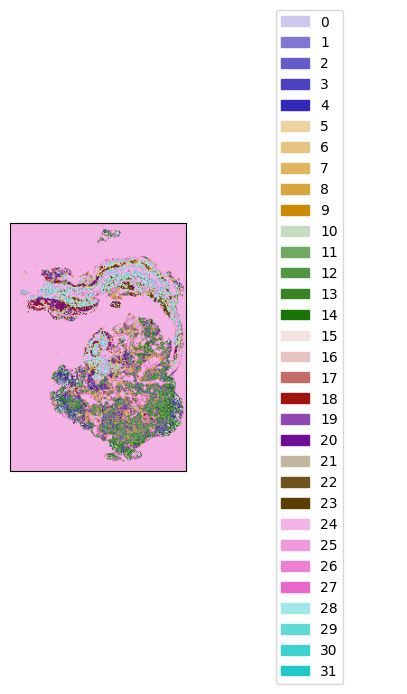

In [115]:
mushroom.display_clusters(dtype, 2, figsize=(5, 5))

In [124]:
bbox = (100, 150, 120, 170)

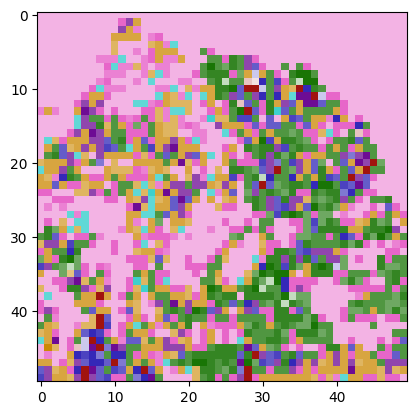

In [125]:
rgb = vis_utils.display_labeled_as_rgb(volume[2], label_to_hierarchy=outputs['dtype_to_cluster_to_agg'][dtype][2])
plt.imshow(rgb[bbox[0]:bbox[1], bbox[2]:bbox[3]])

In [104]:
level_to_dtype_to_volume[2]['integrated'].shape

(7, 276, 196)

In [110]:
# rgb = vis_utils.display_labeled_as_rgb(level_to_dtype_to_volume[2]['integrated'][2])
# plt.imshow(rgb[bbox[0]:bbox[1], bbox[2]:bbox[3]])

In [111]:
# volume[2, bbox[0]:bbox[1], bbox[2]:bbox[3]]

In [126]:
seed = 13

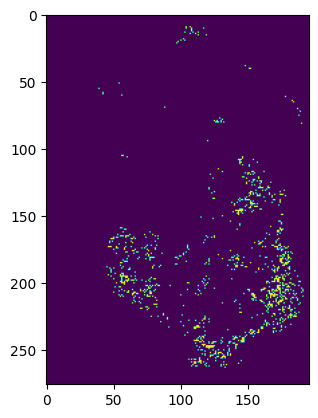

In [127]:
mask = volume==seed
plt.imshow(mask[2])

In [129]:
case_to_specific[case][dtype]

ABCC11      ACE2     ACKR1     ACTA2     ACTG2    ADAM28   ADAMTS1  \
0   0.340314  2.811056  0.690512  1.593009  2.886210  2.192092  2.194993   
1   0.216039  1.207221  0.699244  1.002272  1.735500  1.398614  1.534885   
2   0.177676  0.830765  0.724568  0.956430  1.487225  1.251245  1.404476   
3   0.235821  1.425171  0.674119  0.975317  1.803117  1.384973  1.509606   
4   0.247584  1.546272  0.869246  1.515889  2.270957  1.868923  1.981143   
5   0.008057 -0.421623  0.347787  1.051600  0.496949  0.239155  0.432879   
6   0.067188 -0.398812  0.521439  1.299966  0.767358  0.537893  0.745243   
7   0.042384 -0.168170  0.326403  0.579759  0.413625  0.350612  0.501084   
8   0.094954  0.220768  0.497059  0.609589  0.769433  0.682209  0.829610   
9   0.087332 -0.341672  0.626789  1.661750  1.011799  0.735354  0.953770   
10  0.392993  3.416239  0.201698  0.870125  2.453059  1.283272  1.392643   
11  0.204159  1.883333  0.080447  0.172878  1.154151  0.436420  0.560023   
12  0.117742  1.077048  0.151144  0.203762  0.792411  0.369066  0.490830   
13  0.234261  2.331757  0.119485  0.392014  1.453516  0.585970  0.676701   
14  0.322805  2.777208  0.149689  0.608594  1.932953  0.905982  1.022222   
15  0.218500  0.377360  2.163667  3.989407  3.898719  4.373835  4.315755   
16  0.266021  0.868373  1.672744  3.103526  3.382046  3.506243  3.500631   
17  0.223454 -0.271229  2.652674  4.705741  4.458633  5.206327  5.177128   
18  0.182423  0.274150  1.428050  2.781477  2.622299  2.681566  2.805072   
19  0.108695  0.064666  0.966382  1.227718  1.362900  1.378250  1.545410   
20  0.128453 -0.118345  1.080224  2.444090  1.891444  1.692418  1.903629   
21 -0.007865 -0.284668  0.124271  1.226192  0.398215 -0.045521  0.096625   
22 -0.010629 -0.239934  0.143207  1.778233  0.631060 -0.081772  0.127291   
23  0.056465 -0.314311  0.535682  2.778333  1.239310  0.471110  0.750833   
24 -0.061650 -0.283685 -0.167459 -0.411149 -0.506192 -0.362075 -0.412721   
25 -0.078317 -0.188402 -0.242557  0.194097 -0.228203 -0.395063 -0.403045   
26 -0.051671 -0.262840  0.014599 -0.003514 -0.155482 -0.160928 -0.145803   
27  0.018247  0.378247  0.054089  0.044161  0.244919 -0.001274  0.087965   
28  0.008081 -0.357307  0.081379  0.805023  0.201221 -0.092477 -0.014326   
29 -0.023216 -0.397324  0.112215  0.275760  0.016032 -0.018241  0.044765   
30 -0.002321 -0.127796  0.213231  0.209039  0.186448  0.159869  0.217708   
31 -0.041662 -0.157450 -0.067940  1.076629  0.244284 -0.235161 -0.160043   

      ADGRE1    ADGRL4     ADH1C  ...     UCHL1      UMOD     UPK3B      VCAN  \
0   1.304393  1.936255  0.243409  ...  0.290282  0.105298  0.380045  3.439014   
1   0.851277  1.418311  0.134232  ...  0.261430  0.085185  0.217605  1.681544   
2   0.753856  1.326361  0.123549  ...  0.302012  0.080100  0.176532  1.310198   
3   0.851023  1.358508  0.153790  ...  0.247482  0.087227  0.221726  1.877727   
4   1.111831  1.902817  0.251361  ...  0.446172  0.098691  0.299114  2.208968   
5   0.125622  0.372788  0.398740  ...  0.871969  0.000358  0.030610  0.224453   
6   0.280745  0.754316  0.443878  ...  0.919660  0.022275  0.081384  0.355899   
7   0.202281  0.523079  0.151064  ...  0.401621 -0.008631  0.024671  0.220221   
8   0.418395  0.808108  0.096318  ...  0.317125  0.047082  0.087599  0.619565   
9   0.371531  0.952228  0.538569  ...  1.112174  0.024982  0.116874  0.513066   
10  0.871632  0.687540  0.185717  ...  0.160445  0.099460  0.333273  3.653303   
11  0.316798  0.091905  0.034261  ... -0.032620  0.089888  0.155165  1.948557   
12  0.266753  0.218826  0.029864  ...  0.064303  0.047309  0.103211  1.210261   
13  0.437192  0.144424  0.112165  ...  0.047905  0.115918  0.204663  2.432255   
14  0.641075  0.431284  0.131458  ...  0.083920  0.101308  0.269044  2.976568   
15  1.969837  4.839883  0.560331  ...  1.194188  0.212878  0.551690  2.049570   
16  1.705844  3.801629  0.457607  ...  0.948326  0.158337  0.448664  2.170890   
17  2.263979  5.907950  0.546762  ...  

In [137]:
def get_profiles(volume, seed, dist=10., n=1000):
    mask = volume==seed
    max_bounds = mask.shape
    min_bounds = (0, 0, 0)
    
    verts, faces, normals, values = skimage.measure.marching_cubes(mask)
    
    idxs = np.random.choice(np.arange(verts.shape[0]), size=n, replace=True)
    profiles = []
    for idx in idxs:
        start = verts[idx]
        stop = start + (normals[idx] * dist)
        
        if not np.count_nonzero(stop >= max_bounds) and not np.count_nonzero(stop < min_bounds):
            line = skimage.draw.line_nd(start, stop, integer=True)
            profile = volume[line]
            profile = np.pad(profile, (0, int(dist) - len(profile)))
            profiles.append(profile)
    
    return np.stack(profiles)
        

In [138]:
profiles = get_profiles(volume, seed)

In [139]:
profiles[:10]

array([[13, 19,  8,  7, 24, 24, 24, 24,  0,  0],
       [11, 11,  0, 17, 17,  0,  4, 27, 13, 13],
       [ 8,  8, 24, 24, 27, 27, 27, 12, 12, 27],
       [13, 27, 27,  4,  4,  8,  8, 14, 14, 13],
       [13, 12, 12, 12, 12,  2, 12,  8, 12,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [13, 10, 13, 14, 14, 11,  4, 27, 24, 27],
       [13,  2, 19,  8, 24,  8, 19,  2, 27, 27],
       [13,  6, 23, 24, 24, 24, 24, 24,  0,  0],
       [13, 24, 24, 24, 24, 24, 24, 24,  0,  0]])

In [143]:
exp_df = case_to_specific[case][dtype]


ABCC11      ACE2     ACKR1     ACTA2     ACTG2    ADAM28   ADAMTS1  \
0   0.340314  2.811056  0.690512  1.593009  2.886210  2.192092  2.194993   
1   0.216039  1.207221  0.699244  1.002272  1.735500  1.398614  1.534885   
2   0.177676  0.830765  0.724568  0.956430  1.487225  1.251245  1.404476   
3   0.235821  1.425171  0.674119  0.975317  1.803117  1.384973  1.509606   
4   0.247584  1.546272  0.869246  1.515889  2.270957  1.868923  1.981143   
5   0.008057 -0.421623  0.347787  1.051600  0.496949  0.239155  0.432879   
6   0.067188 -0.398812  0.521439  1.299966  0.767358  0.537893  0.745243   
7   0.042384 -0.168170  0.326403  0.579759  0.413625  0.350612  0.501084   
8   0.094954  0.220768  0.497059  0.609589  0.769433  0.682209  0.829610   
9   0.087332 -0.341672  0.626789  1.661750  1.011799  0.735354  0.953770   
10  0.392993  3.416239  0.201698  0.870125  2.453059  1.283272  1.392643   
11  0.204159  1.883333  0.080447  0.172878  1.154151  0.436420  0.560023   
12  0.117742  1.077048  0.151144  0.203762  0.792411  0.369066  0.490830   
13  0.234261  2.331757  0.119485  0.392014  1.453516  0.585970  0.676701   
14  0.322805  2.777208  0.149689  0.608594  1.932953  0.905982  1.022222   
15  0.218500  0.377360  2.163667  3.989407  3.898719  4.373835  4.315755   
16  0.266021  0.868373  1.672744  3.103526  3.382046  3.506243  3.500631   
17  0.223454 -0.271229  2.652674  4.705741  4.458633  5.206327  5.177128   
18  0.182423  0.274150  1.428050  2.781477  2.622299  2.681566  2.805072   
19  0.108695  0.064666  0.966382  1.227718  1.362900  1.378250  1.545410   
20  0.128453 -0.118345  1.080224  2.444090  1.891444  1.692418  1.903629   
21 -0.007865 -0.284668  0.124271  1.226192  0.398215 -0.045521  0.096625   
22 -0.010629 -0.239934  0.143207  1.778233  0.631060 -0.081772  0.127291   
23  0.056465 -0.314311  0.535682  2.778333  1.239310  0.471110  0.750833   
24 -0.061650 -0.283685 -0.167459 -0.411149 -0.506192 -0.362075 -0.412721   
25 -0.078317 -0.188402 -0.242557  0.194097 -0.228203 -0.395063 -0.403045   
26 -0.051671 -0.262840  0.014599 -0.003514 -0.155482 -0.160928 -0.145803   
27  0.018247  0.378247  0.054089  0.044161  0.244919 -0.001274  0.087965   
28  0.008081 -0.357307  0.081379  0.805023  0.201221 -0.092477 -0.014326   
29 -0.023216 -0.397324  0.112215  0.275760  0.016032 -0.018241  0.044765   
30 -0.002321 -0.127796  0.213231  0.209039  0.186448  0.159869  0.217708   
31 -0.041662 -0.157450 -0.067940  1.076629  0.244284 -0.235161 -0.160043   

      ADGRE1    ADGRL4     ADH1C  ...     UCHL1      UMOD     UPK3B      VCAN  \
0   1.304393  1.936255  0.243409  ...  0.290282  0.105298  0.380045  3.439014   
1   0.851277  1.418311  0.134232  ...  0.261430  0.085185  0.217605  1.681544   
2   0.753856  1.326361  0.123549  ...  0.302012  0.080100  0.176532  1.310198   
3   0.851023  1.358508  0.153790  ...  0.247482  0.087227  0.221726  1.877727   
4   1.111831  1.902817  0.251361  ...  0.446172  0.098691  0.299114  2.208968   
5   0.125622  0.372788  0.398740  ...  0.871969  0.000358  0.030610  0.224453   
6   0.280745  0.754316  0.443878  ...  0.919660  0.022275  0.081384  0.355899   
7   0.202281  0.523079  0.151064  ...  0.401621 -0.008631  0.024671  0.220221   
8   0.418395  0.808108  0.096318  ...  0.317125  0.047082  0.087599  0.619565   
9   0.371531  0.952228  0.538569  ...  1.112174  0.024982  0.116874  0.513066   
10  0.871632  0.687540  0.185717  ...  0.160445  0.099460  0.333273  3.653303   
11  0.316798  0.091905  0.034261  ... -0.032620  0.089888  0.155165  1.948557   
12  0.266753  0.218826  0.029864  ...  0.064303  0.047309  0.103211  1.210261   
13  0.437192  0.144424  0.112165  ...  0.047905  0.115918  0.204663  2.432255   
14  0.641075  0.431284  0.131458  ...  0.083920  0.101308  0.269044  2.976568   
15  1.969837  4.839883  0.560331  ...  1.194188  0.212878  0.551690  2.049570   
16  1.705844  3.801629  0.457607  ...  0.948326  0.158337  0.448664  2.170890   
17  2.263979  5.907950  0.546762  ...  

In [140]:
n_bins = max([len(x) for x in profiles])
counts = pd.DataFrame(data=np.zeros((n_bins, len(np.unique(volume))), dtype=int))
for i in range(n_bins):
    for profile in profiles:
        if i < len(profile):
            counts.iloc[i, profile[i]] += 1
counts /= np.expand_dims(counts.sum(1).values, -1)
counts

0         1         2         3         4         5         6   \
0  0.019153  0.009073  0.020161  0.029234  0.019153  0.000000  0.000000   
1  0.046371  0.023185  0.058468  0.061492  0.050403  0.000000  0.001008   
2  0.035282  0.010081  0.049395  0.037298  0.021169  0.000000  0.003024   
3  0.028226  0.010081  0.047379  0.039315  0.024194  0.001008  0.003024   
4  0.027218  0.011089  0.053427  0.024194  0.036290  0.001008  0.000000   
5  0.025202  0.010081  0.051411  0.033266  0.028226  0.000000  0.000000   
6  0.023185  0.015121  0.046371  0.034274  0.021169  0.001008  0.000000   
7  0.028226  0.018145  0.053427  0.035282  0.021169  0.001008  0.003024   
8  0.117944  0.008065  0.042339  0.027218  0.014113  0.002016  0.000000   
9  0.149194  0.006048  0.036290  0.025202  0.013105  0.003024  0.000000   

         7         8         9   ...        22        23        24        25  \
0  0.001008  0.026210  0.000000  ...  0.000000  0.000000  0.022177  0.000000   
1  0.004032  0.057460  0.000000  ...  0.000000  0.001008  0.065524  0.000000   
2  0.015121  0.053427  0.000000  ...  0.000000  0.001008  0.117944  0.002016   
3  0.014113  0.057460  0.000000  ...  0.000000  0.002016  0.146169  0.001008   
4  0.012097  0.049395  0.000000  ...  0.000000  0.000000  0.163306  0.002016   
5  0.007056  0.069556  0.001008  ...  0.000000  0.000000  0.190524  0.000000   
6  0.008065  0.072581  0.001008  ...  0.000000  0.004032  0.211694  0.003024   
7  0.014113  0.061492  0.000000  ...  0.001008  0.003024  0.245968  0.002016   
8  0.012097  0.060484  0.000000  ...  0.001008  0.001008  0.233871  0.000000   
9  0.017137  0.069556  0.000000  ...  0.001008  0.000000  0.232863  0.000000   

         26        27        28        29        30   31  
0  0.001008  0.043347  0.000000  0.000000  0.000000  0.0  
1  0.000000  0.086694  0.000000  0.001008  0.001008  0.0  
2  0.007056  0.100806  0.002016  0.002016  0.000000  0.0  
3  0.013105  0.115927  0.001008  0.002016  0.001008  0.0  
4  0.014113  0.112903  0.003024  0.007056  0.000000  0.0  
5  0.014113  0.110887  0.006048  0.006048  0.000000  0.0  
6  0.009073  0.094758  0.002016  0.010081  0.000000  0.0  
7  0.014113  0.105847  0.001008  0.007056  0.000000  0.0  
8  0.014113  0.105847  0.004032  0.006048  0.000000  0.0  
9  0.012097  0.080645  0.001008  0.008065  0.000000  0.0  

[10 rows x 32 columns]

In [141]:
counts

0         1         2         3         4         5         6   \
0  0.019153  0.009073  0.020161  0.029234  0.019153  0.000000  0.000000   
1  0.046371  0.023185  0.058468  0.061492  0.050403  0.000000  0.001008   
2  0.035282  0.010081  0.049395  0.037298  0.021169  0.000000  0.003024   
3  0.028226  0.010081  0.047379  0.039315  0.024194  0.001008  0.003024   
4  0.027218  0.011089  0.053427  0.024194  0.036290  0.001008  0.000000   
5  0.025202  0.010081  0.051411  0.033266  0.028226  0.000000  0.000000   
6  0.023185  0.015121  0.046371  0.034274  0.021169  0.001008  0.000000   
7  0.028226  0.018145  0.053427  0.035282  0.021169  0.001008  0.003024   
8  0.117944  0.008065  0.042339  0.027218  0.014113  0.002016  0.000000   
9  0.149194  0.006048  0.036290  0.025202  0.013105  0.003024  0.000000   

         7         8         9   ...        22        23        24        25  \
0  0.001008  0.026210  0.000000  ...  0.000000  0.000000  0.022177  0.000000   
1  0.004032  0.057460  0.000000  ...  0.000000  0.001008  0.065524  0.000000   
2  0.015121  0.053427  0.000000  ...  0.000000  0.001008  0.117944  0.002016   
3  0.014113  0.057460  0.000000  ...  0.000000  0.002016  0.146169  0.001008   
4  0.012097  0.049395  0.000000  ...  0.000000  0.000000  0.163306  0.002016   
5  0.007056  0.069556  0.001008  ...  0.000000  0.000000  0.190524  0.000000   
6  0.008065  0.072581  0.001008  ...  0.000000  0.004032  0.211694  0.003024   
7  0.014113  0.061492  0.000000  ...  0.001008  0.003024  0.245968  0.002016   
8  0.012097  0.060484  0.000000  ...  0.001008  0.001008  0.233871  0.000000   
9  0.017137  0.069556  0.000000  ...  0.001008  0.000000  0.232863  0.000000   

         26        27        28        29        30   31  
0  0.001008  0.043347  0.000000  0.000000  0.000000  0.0  
1  0.000000  0.086694  0.000000  0.001008  0.001008  0.0  
2  0.007056  0.100806  0.002016  0.002016  0.000000  0.0  
3  0.013105  0.115927  0.001008  0.002016  0.001008  0.0  
4  0.014113  0.112903  0.003024  0.007056  0.000000  0.0  
5  0.014113  0.110887  0.006048  0.006048  0.000000  0.0  
6  0.009073  0.094758  0.002016  0.010081  0.000000  0.0  
7  0.014113  0.105847  0.001008  0.007056  0.000000  0.0  
8  0.014113  0.105847  0.004032  0.006048  0.000000  0.0  
9  0.012097  0.080645  0.001008  0.008065  0.000000  0.0  

[10 rows x 32 columns]

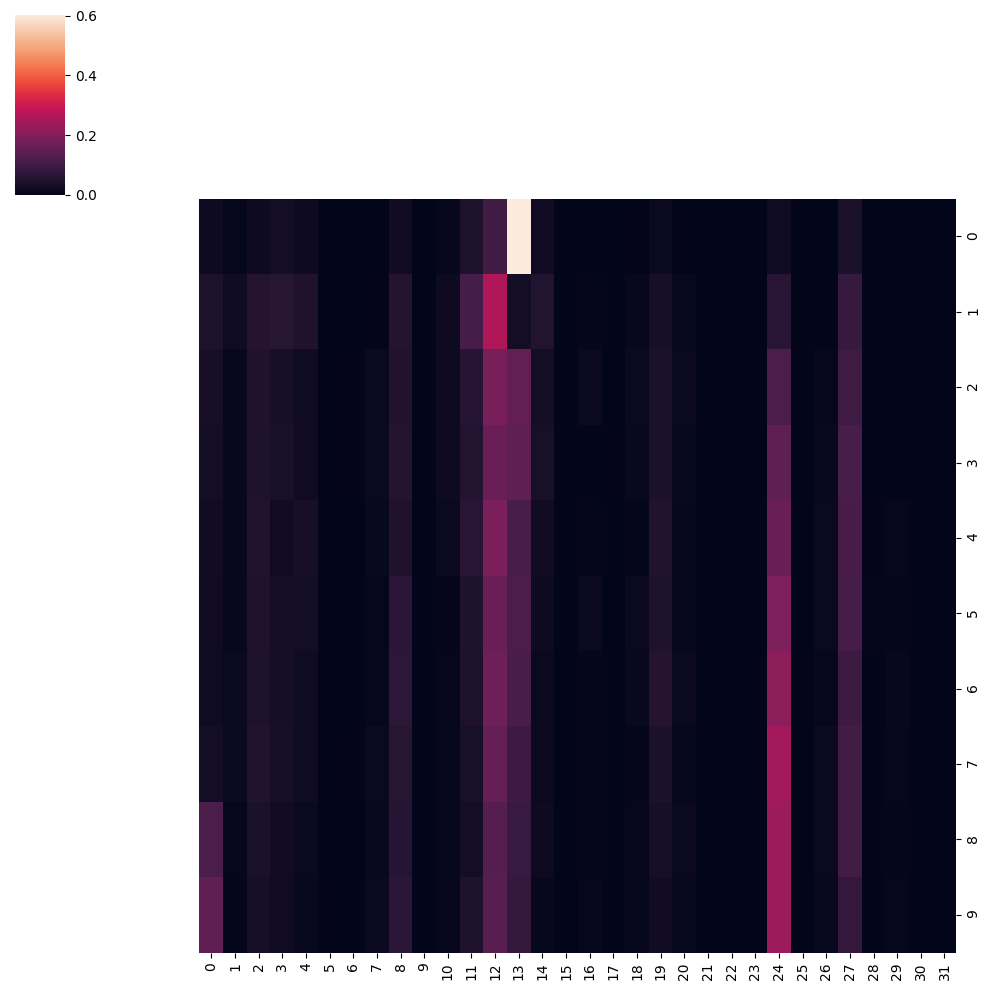

In [142]:
sns.clustermap(counts, row_cluster=False, col_cluster=False)

In [38]:
import skimage

In [39]:
verts, faces, normals, values = skimage.measure.marching_cubes(mask)

In [41]:
verts.shape, faces.shape, normals.shape

((22848, 3), (39168, 3), (22848, 3))

In [45]:
normals[:2], verts[:2]

(array([[ 0.        , -0.9486833 , -0.31622776],
        [ 0.        ,  0.        , -1.        ]], dtype=float32),
 array([[  0. ,  41.5, 117. ],
        [  1. ,  42. , 116.5]], dtype=float32))

In [47]:
start = verts[0]
stop = verts[0] + (normals[0] * 10)
line = skimage.draw.line_nd(start, stop, integer=True)
print(start, stop)

[  0.   41.5 117. ] [  0.       32.01317 113.83772]


In [48]:
line

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([42, 41, 40, 39, 38, 37, 36, 35, 34, 33]),
 array([117, 117, 116, 116, 116, 115, 115, 115, 114, 114]))

In [49]:
volume[line]

array([8, 0, 0, 1, 1, 1, 1, 0, 2, 2])

In [38]:
gene_sets = json.load(open(os.path.join(project_dir, 'analysis', 'gene_sets', 'c4.3ca.v2023.2.Hs.json')))
gene_sets.keys()

dict_keys(['GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_G2_M', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_2_CELL_CYCLE_G1_S', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_3_CELL_CYLCE_HMG_RICH', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_4_CHROMATIN', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_5_STRESS', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_METAPROGRAM_6_HYPOXIA', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_7_STRESS_IN_VITRO', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_8_PROTEASOMAL_DEGRADATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_9_UNFOLDED_PROTEIN_RESPONSE', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_13_EMT_2', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_14_EMT_3', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_15_EMT_4', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_16_MES_GLIOMA', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_17_INTERFERON_MHC_II_1', 'GAVISH_3CA_MALIGNANT_METAPROGRAM_18_INTERFERON_MHC_II_2', 'GAVISH_3CA_MALIGNANT_ME

In [39]:
next(iter(gene_sets.values()))

{'collection': 'C4:3CA',
 'systematicName': 'M46567',
 'pmid': '37258682',
 'exactSource': '3CA Download meta_programs_2023-07-13: Malignant. 1  Cell Cycle - G2/M',
 'externalDetailsURL': 'https://www.weizmann.ac.il/sites/3CA/',
 'msigdbURL': 'https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_G2_M',
 'geneSymbols': ['ARL6IP1',
  'ASPM',
  'AURKA',
  'AURKB',
  'BIRC5',
  'CCNA2',
  'CCNB1',
  'CCNB2',
  'CDC20',
  'CDCA3',
  'CDCA8',
  'CDK1',
  'CDKN3',
  'CENPA',
  'CENPE',
  'CENPF',
  'CENPW',
  'CKAP2',
  'CKS1B',
  'CKS2',
  'DEPDC1',
  'DLGAP5',
  'ECT2',
  'GTSE1',
  'H4C3',
  'HMGB2',
  'HMMR',
  'KIF20B',
  'KIF23',
  'KIF2C',
  'KNSTRN',
  'KPNA2',
  'MAD2L1',
  'MKI67',
  'NUF2',
  'NUSAP1',
  'PBK',
  'PLK1',
  'PRC1',
  'PTTG1',
  'SMC4',
  'STMN1',
  'TACC3',
  'TOP2A',
  'TPX2',
  'TUBA1B',
  'UBE2C',
  'UBE2S',
  'UBE2T',
  'ZWINT'],
 'filteredBySimilarity': [],
 'externalNamesForSimilarTerms': []}

In [246]:
df = case_to_integrated['HT397B1']['visium']
[c for c in df if 'HLA' in c]

['HHLA3',
 'HLA-A',
 'HLA-C',
 'HLA-DMA',
 'HLA-DMB',
 'HLA-DOA',
 'HLA-DPA1',
 'HLA-DPB1',
 'HLA-DQA1',
 'HLA-DRA',
 'HLA-DRB1',
 'HLA-DRB5',
 'HLA-E',
 'HLA-F']

In [40]:
volume_dtypes = ['xenium', 'visium', 'integrated']
quant_dtypes = ['xenium', 'visium']

In [286]:
# macro_gene_sets = {
#     'epithelial': [
#         'KRT18', 'EPCAM', 'LRP2', 'CA9', 'KRT10',
#  'KRT14',
#  'KRT15',
#  'KRT18',
#  'KRT23',
#  'KRT5',
#  'KRT7',
#  'KRT8',
#  'KRT80',
#     ],
#     'immune': [
# #         'PTPRC', 'CD3D', 'IL7R', 'CD68', 'MS4A1', 'GZMK', 'LYZ', 'ITGAM'
#         'PTPRC', 'HLA-A',
#  'HLA-C',
#  'HLA-DMA',
#  'HLA-DMB',
#  'HLA-DOA',
#  'HLA-DPA1',
#  'HLA-DPB1',
#  'HLA-DQA1',
#  'HLA-DRA',
#  'HLA-DRB1',
#  'HLA-DRB5',
#  'HLA-E',
#  'HLA-F'
#     ],
#     'stroma': [
# #         'ACTA2', 'FAP',
#  'COL11A1',
#  'COL12A1',
#  'COL14A1',
#  'COL15A1',
#  'COL16A1',
#  'COL18A1',
#  'COL1A1',
#  'COL1A2',
#  'COL27A1',
#  'COL3A1',
#  'COL4A1',
#  'COL4A2',
#  'COL4A5',
#  'COL5A1',
#  'COL5A2',
#  'COL5A3',
#  'COL6A1',
#  'COL6A2',
#  'COL6A3',
#  'COL7A1',
#  'COL8A1',
#  'COL8A2',
#  'COL9A2'
#     ]
# }

In [287]:
# data = []

# for case in case_order:
#     print(case)
#     disease = case_to_disease[case]
#     dtype_to_specific = case_to_specific[case]
#     dtype_to_integrated = case_to_integrated[case]
    
#     outputs = pickle.load(open(
#         os.path.join(project_dir, case, 'mushroom_50res', 'outputs.pkl'), 'rb'))
    
#     for volume_dtype in volume_dtypes:
#         if volume_dtype in outputs['dtype_to_volume']:
#             volume = outputs['dtype_to_volume'][volume_dtype]
#             labels, counts = np.unique(volume, return_counts=True)
#             total = counts.sum()
#             label_to_count = {l:c for l, c in zip(labels, counts)}
        
#         if volume_dtype == 'integrated':
#             for quant_dtype in quant_dtypes:
#                 if quant_dtype in dtype_to_integrated:
#                     df = dtype_to_integrated[quant_dtype]
#                     for name, gs in macro_gene_sets.items():
#                         genes = [g for g in gs if g in df.columns]
#                         print(quant_dtype, genes)
#                         if genes:
#                             nbhd_scores = df[genes].values.mean(1)
#                             for nbhd, score in zip(df.index.to_list(), nbhd_scores):
#                                 area = label_to_count[nbhd]
#                                 data.append([case, disease, quant_dtype, 'integrated', name, nbhd, area, area / total, score])
#         else:
#             if volume_dtype in dtype_to_specific:
#                 df = dtype_to_specific[volume_dtype]
#                 for name, gs in macro_gene_sets.items():
#                     genes = [g for g in gs if g in df.columns]
#                     if genes:
#                         nbhd_scores = df[genes].values.mean(1)
#                         for nbhd, score in zip(df.index.to_list(), nbhd_scores):
#                             area = label_to_count[nbhd]
#                             data.append([case, disease, volume_dtype, 'specific', name, nbhd, area, area / total, score])
# score_df = pd.DataFrame(data=data, columns=['case', 'disease', 'dtype', 'type', 'gene_set', 'nbhd', 'area', 'area_frac', 'score'])
# score_df

In [288]:
# df = score_df.copy()
# df = df[df['type']=='integrated']
# df = df.groupby(['case', 'disease', 'dtype', 'type', 'nbhd', 'gene_set']).mean()
# df = df.reset_index()
# df = df.pivot(columns='gene_set', index=['case', 'disease', 'dtype', 'type', 'nbhd'])
# df.columns = ['_'.join(col) for col in df.columns]
# # df -= df.values.min(0)
# # df /= df.values.std(0)
# df = df.reset_index()
# df

In [289]:
data = []

for case in case_order:
    print(case)
    disease = case_to_disease[case]
    dtype_to_specific = case_to_specific[case]
    dtype_to_integrated = case_to_integrated[case]
    
    outputs = pickle.load(open(
        os.path.join(project_dir, case, 'mushroom_50res', 'outputs.pkl'), 'rb'))
    
    for volume_dtype in volume_dtypes:
        if volume_dtype in outputs['dtype_to_volume']:
            volume = outputs['dtype_to_volume'][volume_dtype]
            labels, counts = np.unique(volume, return_counts=True)
            total = counts.sum()
            label_to_count = {l:c for l, c in zip(labels, counts)}
        
        if volume_dtype == 'integrated':
            for quant_dtype in quant_dtypes:
                if quant_dtype in dtype_to_integrated:
                    df = dtype_to_integrated[quant_dtype]
                    for name, gs in gene_sets.items():
                        genes = [g for g in gs['geneSymbols'] if g in df.columns]
                        if genes:
                            nbhd_scores = df[genes].values.mean(1)
                            for nbhd, score in zip(df.index.to_list(), nbhd_scores):
                                area = label_to_count[nbhd]
                                data.append([case, disease, quant_dtype, 'integrated', name, nbhd, area, area / total, score])
        else:
            if volume_dtype in dtype_to_specific:
                df = dtype_to_specific[volume_dtype]
                for name, gs in gene_sets.items():
                    genes = [g for g in gs['geneSymbols'] if g in df.columns]
                    if genes:
                        nbhd_scores = df[genes].values.mean(1)
                        for nbhd, score in zip(df.index.to_list(), nbhd_scores):
                            area = label_to_count[nbhd]
                            data.append([case, disease, volume_dtype, 'specific', name, nbhd, area, area / total, score])
score_df = pd.DataFrame(data=data, columns=['case', 'disease', 'dtype', 'type', 'gene_set', 'nbhd', 'area', 'area_frac', 'score'])
score_df

HT339B2-H1
HT565B1-H2
HT268B1
HT397B1
HT206B1
C3L-01287
C3L-00982
C3L-02551
HT413C1-K2
HT225C1
HT448C1-Th1K1Fp1
HT413C1-Th1k4A1
HT553P1-H2
S18-9906
S18-5591-C8


case disease   dtype        type  \
0        HT339B2-H1    BRCA  visium    specific   
1        HT339B2-H1    BRCA  visium    specific   
2        HT339B2-H1    BRCA  visium    specific   
3        HT339B2-H1    BRCA  visium    specific   
4        HT339B2-H1    BRCA  visium    specific   
...             ...     ...     ...         ...   
113346  S18-5591-C8     PKD  xenium  integrated   
113347  S18-5591-C8     PKD  xenium  integrated   
113348  S18-5591-C8     PKD  xenium  integrated   
113349  S18-5591-C8     PKD  xenium  integrated   
113350  S18-5591-C8     PKD  xenium  integrated   

                                                 gene_set  nbhd    area  \
0       GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...     0     282   
1       GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...     1      86   
2       GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...     2     464   
3       GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...     3    3186   
4       GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...     4      24   
...                                                   ...   ...     ...   
113346          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS    52     298   
113347          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS    53     227   
113348          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS    54  407483   
113349          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS    55     110   
113350          GAVISH_3CA_METAPROGRAM_B_CELLS_HSP_STRESS    56     347   

        area_frac     score  
0        0.008092 -0.114431  
1        0.002468  2.781914  
2        0.013315  3.208806  
3        0.091426  0.795420  
4        0.000689  5.073034  
...           ...       ...  
113346   0.000332  0.173978  
113347   0.000253  0.408222  
113348   0.454067 -0.294549  
113349   0.000123  0.418733  
113350   0.000387  0.439432  

[113351 rows x 9 columns]

In [282]:
# def get_macro(name):
#     if 'MALIGNANT_METAPROGRAM' in name or 'METAPROGRAM_EPITHELIAL' in name:
#         return 'epithelial'
    
#     if 'METAPROGRAM_MACROPHAGES' in name or 'METAPROGRAM_CD4_T' in name or 'METAPROGRAM_CD8_T' in name or 'METAPROGRAM_B_CELLS' in name:
#         return 'immune'
    
#     if 'METAPROGRAM_FIBROBLASTS' in name or 'METAPROGRAM_ENDOTHELIAL' in name:
#         return 'stroma'

# score_df['macro_gene_set'] = [get_macro(x) for x in score_df['gene_set']]
# score_df

In [292]:
df = score_df.copy()
df = df.groupby(['case', 'disease', 'dtype', 'type', 'nbhd', 'gene_set']).mean()
df = df.reset_index()
df = df.pivot(columns='gene_set', index=['case', 'disease', 'dtype', 'type', 'nbhd', 'area', 'area_frac'])
df.columns = ['_'.join(col) for col in df.columns]
# df = df.reset_index()
df

score_GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION  \
case      disease dtype  type       nbhd area     area_frac                                                                 
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                           -0.239158              
                                    1    9866.0   0.026054                                            0.510483              
                                    2    4832.0   0.012760                                            0.487860              
                                    3    29469.0  0.077822                                           -0.339523              
                                    4    6072.0   0.016035                                           -0.282876              
...                                                                                                        ...              
S18-9906  PKD     xenium specific   31   233.0    0.000239                                           -0.322768              
                                    32   7.0      0.000007                                           -0.350046              
                                    33   12480.0  0.012783                                           -0.418584              
                                    34   270.0    0.000277                                           -0.446139              
                                    35   1648.0   0.001688                                           -0.403232              

                                                             score_GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION  \
case      disease dtype  type       nbhd area     area_frac                                                                     
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                           -0.307964                  
                                    1    9866.0   0.026054                                            1.141471                  
                                    2    4832.0   0.012760                                            0.511324                  
                                    3    29469.0  0.077822                                           -0.394505                  
                                    4    6072.0   0.016035                                           -0.020021                  
...                                                                                                        ...                  
S18-9906  PKD     xenium specific   31   233.0    0.000239                                            0.241426                  
                                    32   7.0      0.000007                                            0.289010                  
                                    33   12480.0  0.012783                                            0.325174                  
                                    34   270.0    0.000277                                            0.458321                  
                                    35   1648.0   0.001688                                            0.457868                  

                                                             score_GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1  \
case      disease dtype  type       nbhd area     area_frac                                                    
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                         -0.293574   
                                    1    9866.0   0.026054                                          2.437954   
                                    2    4832.0   0.012760                                          0.336667   
                                    3    29469.0  0.077822                                         -0.167454   
                                    4    6072.0   0.016035                           

In [299]:
df = df[[c for c, k in zip(df.columns, pd.isnull(df).sum(0) > 0) if not k]]
df
        

score_GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION  \
case      disease dtype  type       nbhd area     area_frac                                                                 
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                           -0.239158              
                                    1    9866.0   0.026054                                            0.510483              
                                    2    4832.0   0.012760                                            0.487860              
                                    3    29469.0  0.077822                                           -0.339523              
                                    4    6072.0   0.016035                                           -0.282876              
...                                                                                                        ...              
S18-9906  PKD     xenium specific   31   233.0    0.000239                                           -0.322768              
                                    32   7.0      0.000007                                           -0.350046              
                                    33   12480.0  0.012783                                           -0.418584              
                                    34   270.0    0.000277                                           -0.446139              
                                    35   1648.0   0.001688                                           -0.403232              

                                                             score_GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION  \
case      disease dtype  type       nbhd area     area_frac                                                                     
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                           -0.307964                  
                                    1    9866.0   0.026054                                            1.141471                  
                                    2    4832.0   0.012760                                            0.511324                  
                                    3    29469.0  0.077822                                           -0.394505                  
                                    4    6072.0   0.016035                                           -0.020021                  
...                                                                                                        ...                  
S18-9906  PKD     xenium specific   31   233.0    0.000239                                            0.241426                  
                                    32   7.0      0.000007                                            0.289010                  
                                    33   12480.0  0.012783                                            0.325174                  
                                    34   270.0    0.000277                                            0.458321                  
                                    35   1648.0   0.001688                                            0.457868                  

                                                             score_GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1  \
case      disease dtype  type       nbhd area     area_frac                                                    
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                         -0.293574   
                                    1    9866.0   0.026054                                          2.437954   
                                    2    4832.0   0.012760                                          0.336667   
                                    3    29469.0  0.077822                                         -0.167454   
                                    4    6072.0   0.016035                           

In [312]:
diseases = sorted(set(case_to_disease.values()))
colors = [sns.color_palette()[diseases.index(z)] for z in df.reset_index()['disease']]

In [315]:
colors = [sns.color_palette('tab20')[case_order.index(z)] for z in df.reset_index()['case']]

In [311]:
sorted(set(case_to_disease.values()))

['BRCA', 'CCRCC', 'CRC', 'PDAC', 'PKD']

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



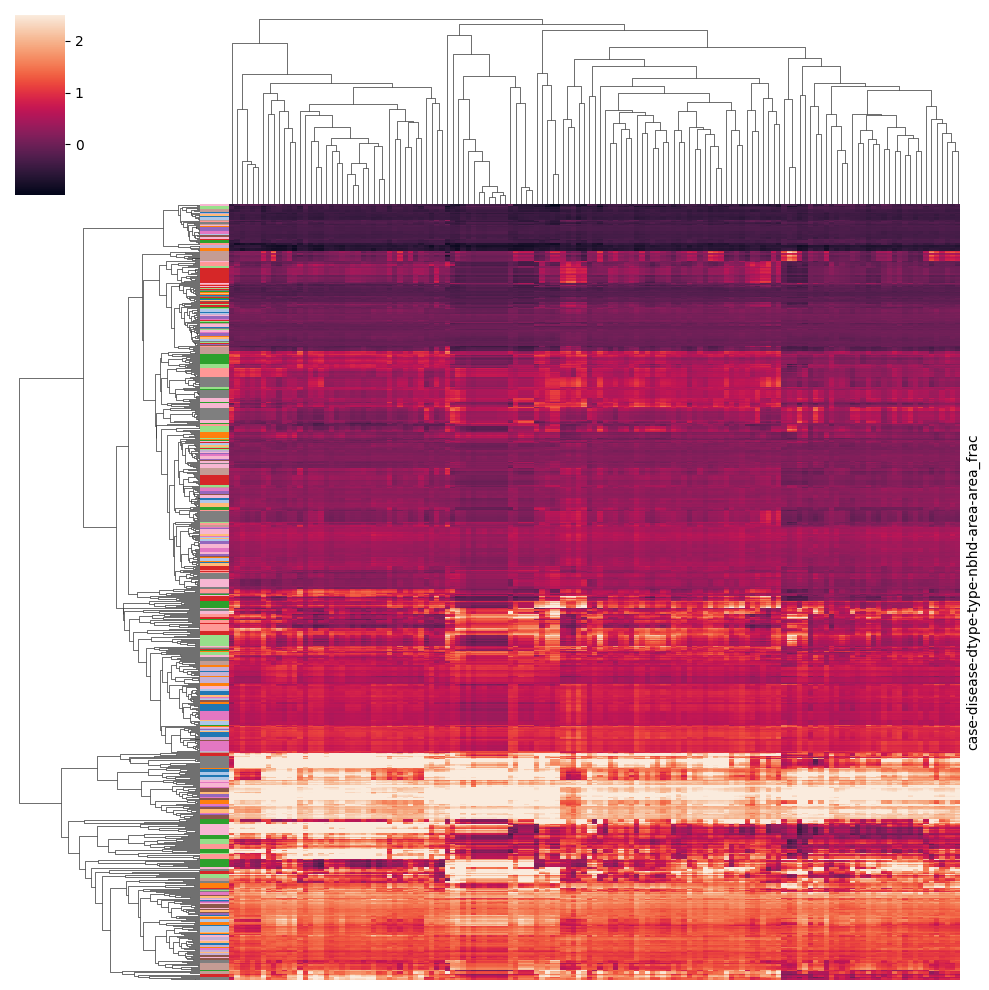

In [318]:
x = df.copy()
x[x>2.5] = 2.5
sns.clustermap(x, xticklabels=[], yticklabels=[], row_colors=colors)

In [322]:
x.reset_index()['case']=='C3L-00982'

0       True
1       True
2       True
3       True
4       True
       ...  
774    False
775    False
776    False
777    False
778    False
Name: case, Length: 779, dtype: bool

In [323]:
x

score_GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION  \
case      disease dtype  type       nbhd area     area_frac                                                                 
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                           -0.239158              
                                    1    9866.0   0.026054                                            0.510483              
                                    2    4832.0   0.012760                                            0.487860              
                                    3    29469.0  0.077822                                           -0.339523              
                                    4    6072.0   0.016035                                           -0.282876              
...                                                                                                        ...              
S18-9906  PKD     xenium specific   31   233.0    0.000239                                           -0.322768              
                                    32   7.0      0.000007                                           -0.350046              
                                    33   12480.0  0.012783                                           -0.418584              
                                    34   270.0    0.000277                                           -0.446139              
                                    35   1648.0   0.001688                                           -0.403232              

                                                             score_GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION  \
case      disease dtype  type       nbhd area     area_frac                                                                     
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                           -0.307964                  
                                    1    9866.0   0.026054                                            1.141471                  
                                    2    4832.0   0.012760                                            0.511324                  
                                    3    29469.0  0.077822                                           -0.394505                  
                                    4    6072.0   0.016035                                           -0.020021                  
...                                                                                                        ...                  
S18-9906  PKD     xenium specific   31   233.0    0.000239                                            0.241426                  
                                    32   7.0      0.000007                                            0.289010                  
                                    33   12480.0  0.012783                                            0.325174                  
                                    34   270.0    0.000277                                            0.458321                  
                                    35   1648.0   0.001688                                            0.457868                  

                                                             score_GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1  \
case      disease dtype  type       nbhd area     area_frac                                                    
C3L-00982 CCRCC   xenium integrated 0    232860.0 0.614939                                         -0.293574   
                                    1    9866.0   0.026054                                          2.437954   
                                    2    4832.0   0.012760                                          0.336667   
                                    3    29469.0  0.077822                                         -0.167454   
                                    4    6072.0   0.016035                           

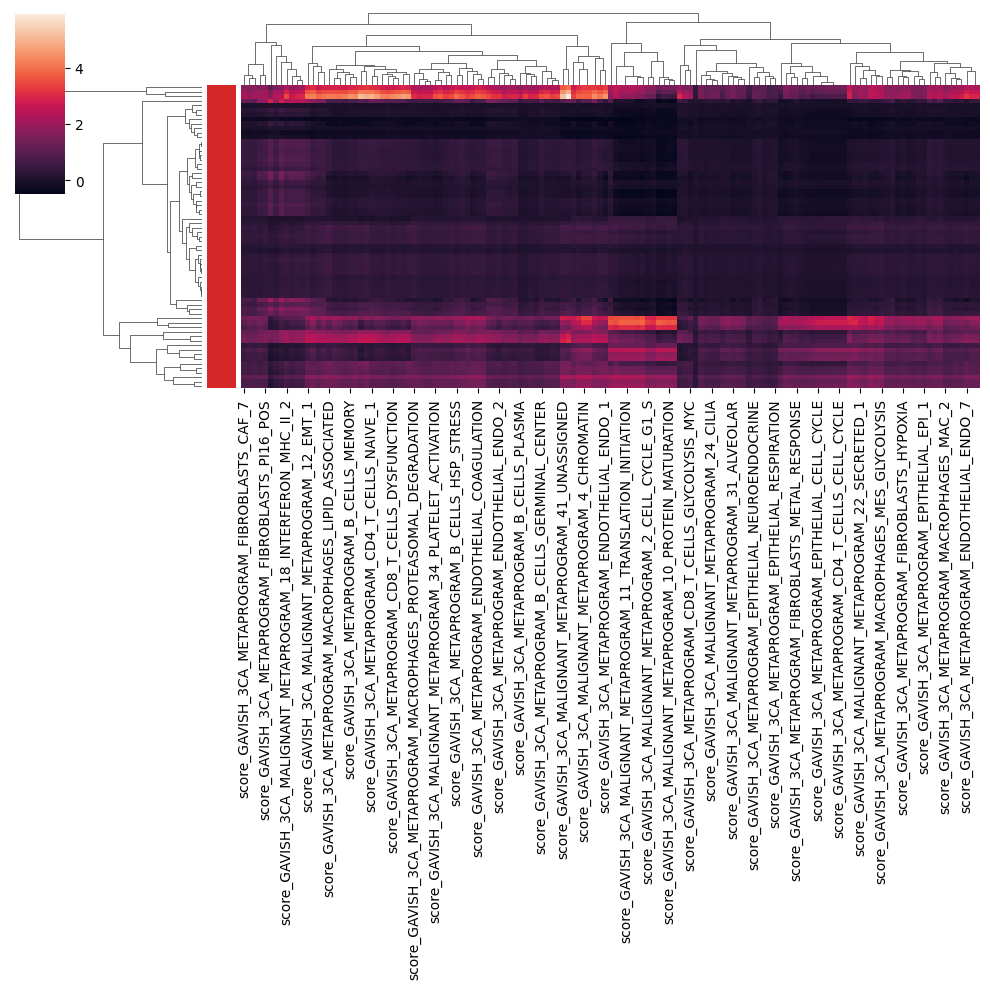

In [325]:
x = df.copy()
# x[x>2.5] = 2.5
x.index = np.arange(x.shape[0])
x = x[df.reset_index()['case']=='C3L-00982']
sns.clustermap(x, yticklabels=[], row_colors=colors)

In [328]:
x

score_GAVISH_3CA_MALIGNANT_METAPROGRAM_10_PROTEIN_MATURATION  \
0                                           -0.239158              
1                                            0.510483              
2                                            0.487860              
3                                           -0.339523              
4                                           -0.282876              
..                                                ...              
62                                           0.407195              
63                                          -0.394369              
64                                          -0.318562              
65                                          -0.014935              
66                                          -0.336647              

    score_GAVISH_3CA_MALIGNANT_METAPROGRAM_11_TRANSLATION_INITIATION  \
0                                           -0.307964                  
1                                            1.141471                  
2                                            0.511324                  
3                                           -0.394505                  
4                                           -0.020021                  
..                                                ...                  
62                                           0.385251                  
63                                          -0.351457                  
64                                          -0.331904                  
65                                          -0.004711                  
66                                          -0.291753                  

    score_GAVISH_3CA_MALIGNANT_METAPROGRAM_12_EMT_1  \
0                                         -0.293574   
1                                          2.437954   
2                                          0.336667   
3                                         -0.167454   
4                                          1.456972   
..                                              ...   
62                                         0.104065   
63                                         0.546101   
64                                         0.161047   
65                                         0.165979   
66                                         0.732291   

    score_GAVISH_3CA_MALIGNANT_METAPROGRAM_13_EMT_2  \
0                                         -0.224311   
1                                          1.491464   
2                                          0.324218   
3                                         -0.187284   
4                                          0.623151   
..                                              ...   
62                                         0.166157   
63                                         0.135729   
64                                        -0.011307   
65                                         0.097979   
66                                         0.206507   

    score_GAVISH_3CA_MALIGNANT_METAPROGRAM_14_EMT_3  \
0                                         -0.260283   
1                                          1.084085   
2                                          0.494639   
3                                         -0.284437   
4                                          0.243042   
..                                              ...   
62                                         0.378365   
63                                        -0.096381   
64                                        -0.162868   
65                                         0.068373   
66                                         0.010329   

    score_GAVISH_3CA_MALIGNANT_METAPROGRAM_15_EMT_4  \
0                                         -0.199726   
1                                          1.250129   
2                                          0.248628   
3                                         -0.134436   
4                                          0.794284   
..       

In [326]:
mushroom = Mushroom.from_config('/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res')

INFO:root:loading spore for he
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['C3L-00982-U5', 'C3L-00982-U5_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-00982-U5


0.02


INFO:root:generating image data for section C3L-00982-U5_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-00982-U5', 'he'), ('C3L-00982-U5_dup', 'he')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpcx3aii3j
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpcx3aii3j/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized


he torch.Size([3, 274, 193])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/he_chkpts/last-v3.ckpt
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 32 channels
INFO:root:3 sections detected: ['C3L-00982-U1', 'C3L-00982-U4', 'C3L-00982-U7']
INFO:root:processing sections
INFO:root:generating image data for section C3L-00982-U1


0.02


INFO:root:generating image data for section C3L-00982-U4
INFO:root:generating image data for section C3L-00982-U7
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 3 sections detected: [('C3L-00982-U1', 'multiplex'), ('C3L-00982-U4', 'multiplex'), ('C3L-00982-U7', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/multiplex_chkpts/last-v3.ckpt


multiplex torch.Size([32, 274, 193])


INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing
INFO:root:using 477 channels
INFO:root:2 sections detected: ['C3L-00982-U2', 'C3L-00982-U2_dup']
INFO:root:processing sections
INFO:root:generating image data for section C3L-00982-U2
INFO:root:generating image data for section C3L-00982-U2_dup


xenium torch.Size([477, 275, 194])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('C3L-00982-U2', 'xenium'), ('C3L-00982-U2_dup', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/xenium_chkpts/last-v2.ckpt
INFO:root:chkpt files detected, embedding to spores
INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoa

Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

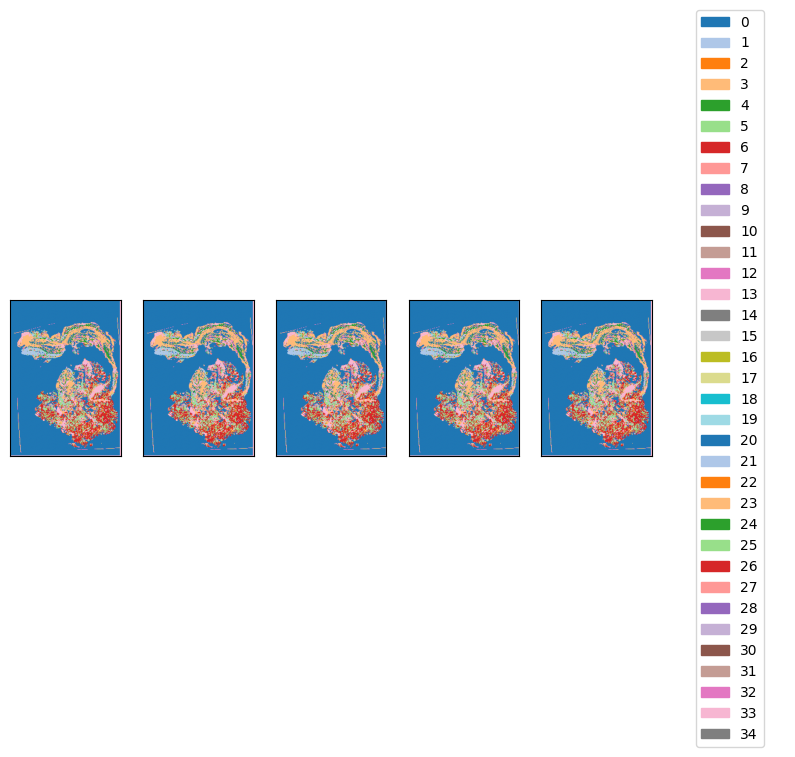

In [327]:
mushroom.display_clusters(dtype='integrated')

In [330]:
dtype_to_df = mushroom.calculate_cluster_intensities(case_to_integrated['C3L-00982'])
dtype_to_df.keys()

dict_keys(['he', 'multiplex', 'xenium'])

In [333]:
# dtype_to_df['xenium']

In [337]:
df = dtype_to_df['xenium']
data = []
idxs = []
for name, gs in gene_sets.items():
    genes = [g for g in gs['geneSymbols'] if g in df.columns]
    if genes:
        nbhd_scores = df[genes].values.mean(1)
        data.append(nbhd_scores)
        idxs.append(name)
df = pd.DataFrame(data=data, index=idxs, columns=df.index.to_list()).T
df


GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_G2_M  \
0                                            2.256838    
1                                            1.015269    
2                                            0.753000    
3                                            1.166278    
4                                            1.345181    
5                                           -0.177588    
6                                           -0.114611    
7                                           -0.024431    
8                                            0.270830    
9                                           -0.088327    
10                                           2.541410    
11                                           1.323769    
12                                           0.749170    
13                                           1.605720    
14                                           2.026672    
15                                           0.906162    
16                                           1.099355    
17                                           0.526774    
18                                           0.580715    
19                                           0.282249    
20                                           0.191144    
21                                          -0.171654    
22                                          -0.145341    
23                                          -0.096102    
24                                          -0.243710    
25                                          -0.046299    
26                                          -0.192591    
27                                           0.237569    
28                                          -0.235987    
29                                          -0.230972    
30                                           0.017381    
31                                          -0.244475    

    GAVISH_3CA_MALIGNANT_METAPROGRAM_2_CELL_CYCLE_G1_S  \
0                                            2.956266    
1                                            1.419977    
2                                            1.076229    
3                                            1.620638    
4                                            1.865150    
5                                           -0.172176    
6                                           -0.075315    
7                                           -0.001472    
8                                            0.425013    
9                                           -0.028922    
10                                           3.273682    
11                                           1.746894    
12                                           0.998107    
13                                           2.096571    
14                                           2.622432    
15                                           1.483387    
16                                           1.665921    
17                                           1.223402    
18                                           0.977280    
19                                           0.520815    
20                                           0.409033    
21                                          -0.230529    
22                                          -0.215296    
23                                          -0.141175    
24                                          -0.361145    
25                                          -0.068208    
26                                          -0.257185    
27                                           0.312252    
28                                          -0.309673    
29                                          -0.272364    
30                                           0.056877    
31                                          -0.362681    

    GAVISH_3CA_MALIGNANT_METAPROGRAM_3_CELL_CYLCE_HMG_RICH  \
0                                            3.465729        
1                                            1.684

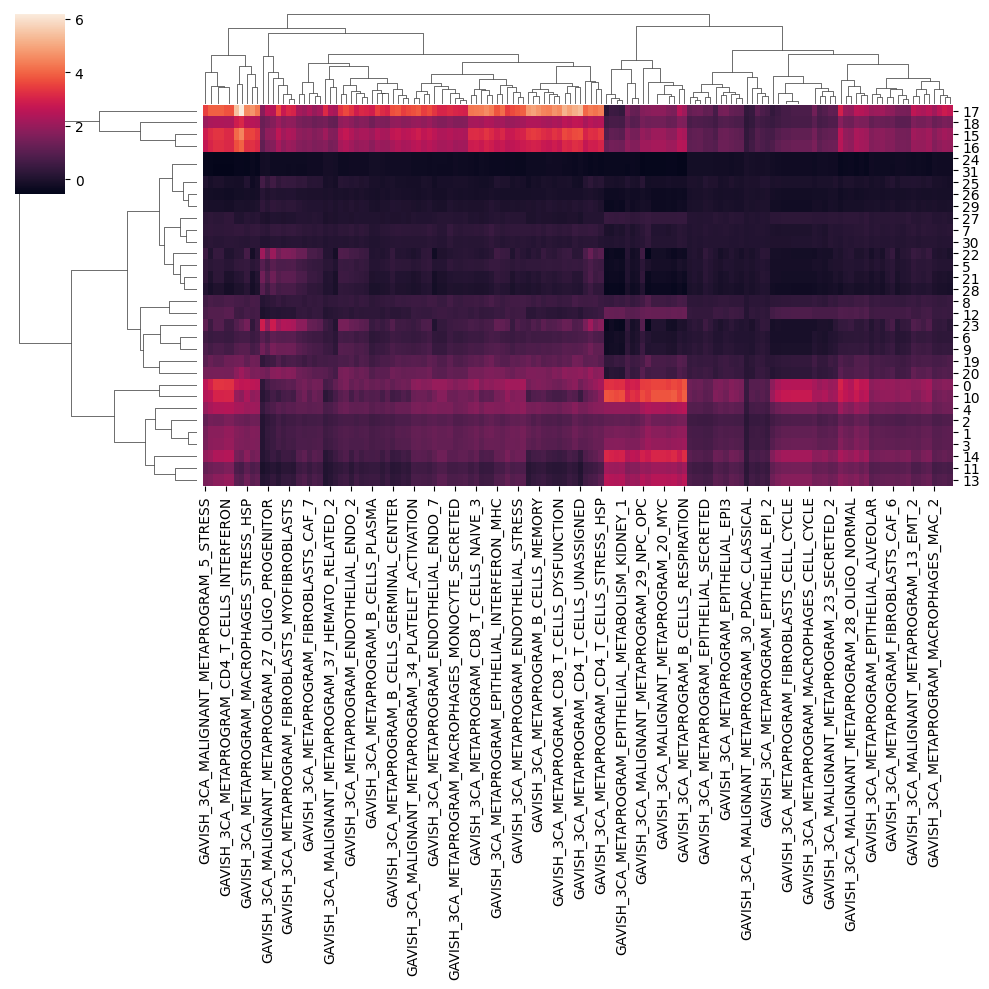

In [338]:
sns.clustermap(df)

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



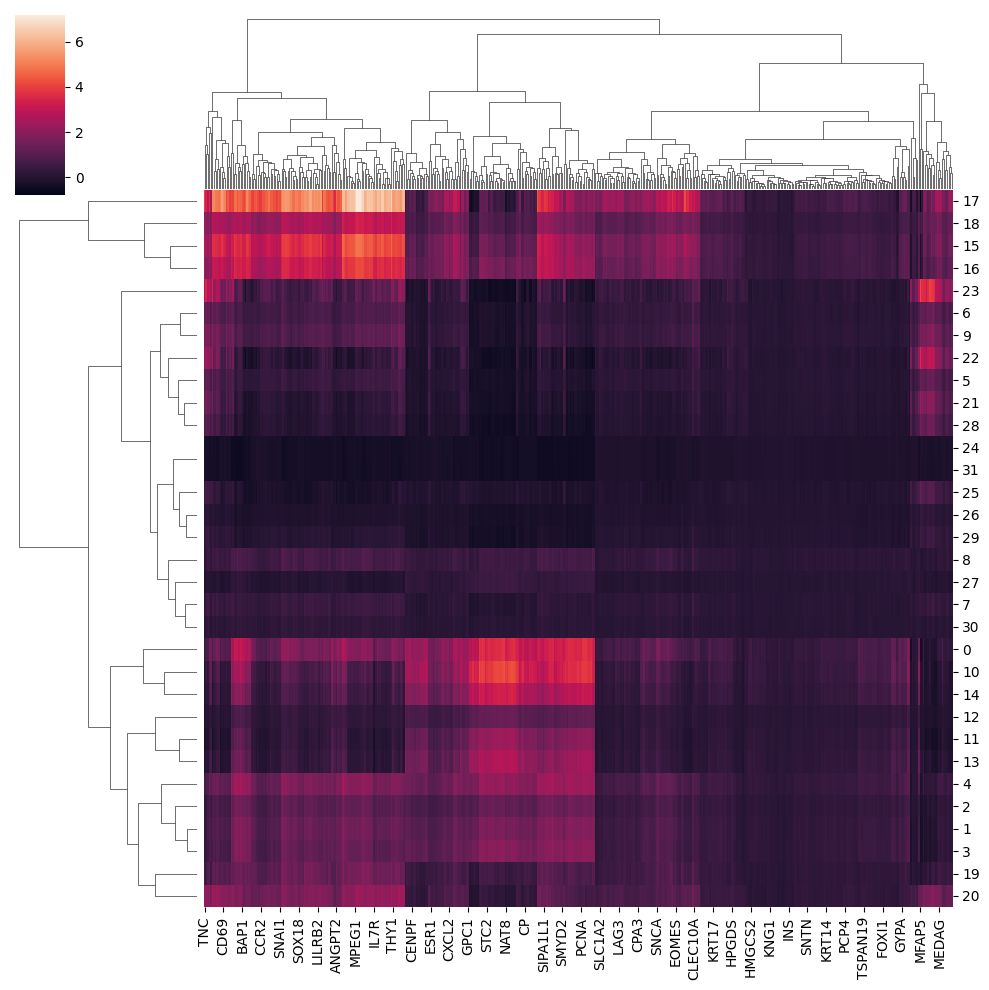

In [332]:
sns.clustermap(dtype_to_df['xenium'])

In [300]:
import umap

In [301]:
x = umap.UMAP().fit_transform(df.values)
x.shape

(779, 2)

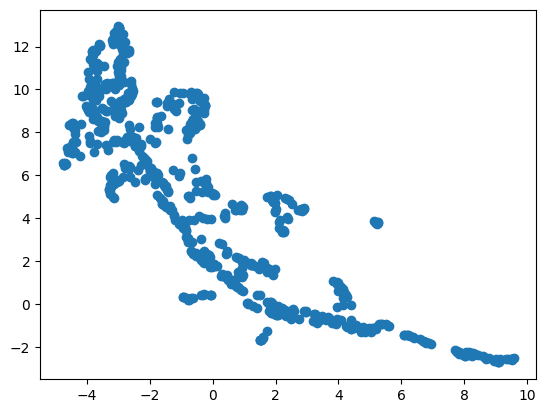

In [302]:
plt.scatter(x[:, 0], x[:, 1])

In [284]:
# sns.pairplot(data=df,
#              x_vars=['score_epithelial', 'score_stroma', 'score_immune', 'area_epithelial'],
#             y_vars=['score_epithelial', 'score_stroma', 'score_immune', 'area_epithelial'], hue='dtype')

In [285]:
fig = px.scatter_ternary(df, a="score_epithelial", b="score_immune", c="score_stroma",
                         color='disease', symbol='dtype')
fig

In [272]:
fig = px.scatter_ternary(df[df['disease']=='CCRCC'], a="score_epithelial", b="score_immune", c="score_stroma",
                         color='disease', symbol='dtype')
fig

In [276]:
fig = px.scatter_ternary(df.iloc[:1], a="score_epithelial", b="score_immune", c="score_stroma",
                         color='disease', symbol='dtype')
fig

In [275]:
df.iloc[:1]

case disease   dtype        type  nbhd  area_epithelial  area_immune  \
0  C3L-00982   CCRCC  xenium  integrated     0         232860.0     232860.0   

   area_stroma  area_frac_epithelial  area_frac_immune  area_frac_stroma  \
0     232860.0              0.614939          0.614939          0.614939   

   score_epithelial  score_immune  score_stroma  
0         -0.186918     -0.289409       -0.2629

In [263]:
import plotly.express as px
df = px.data.election()
fig = px.scatter_ternary(df, a="Joly", b="Coderre", c="Bergeron")
fig.show()

In [75]:
type(fig)

plotly.graph_objs._figure.Figure

In [264]:
df

district  Coderre  Bergeron  \
0                                  101-Bois-de-Liesse     2481      1829   
1                               102-Cap-Saint-Jacques     2525      1163   
2                                11-Sault-au-Récollet     3348      2770   
3                                        111-Mile-End     1734      4782   
4                                      112-DeLorimier     1770      5933   
5                                    113-Jeanne-Mance     1455      3599   
6                                    12-Saint-Sulpice     3252      2521   
7                          121-La Pointe-aux-Prairies     5456      1760   
8                             122-Pointe-aux-Trembles     4734      1879   
9                            123-Rivière-des-Prairies     5737       958   
10                                        13-Ahuntsic     2979      3430   
11                                  131-Saint-Édouard     1827      6408   
12                             132-Étienne-Desmarteau     2331      5748   
13                                 133-Vieux-Rosemont     2670      4962   
14                                 134-Marie-Victorin     3673      3155   
15                           14-Bordeaux-Cartierville     3612      1554   
16                                 141-Côte-de-Liesse     4308      1320   
17                                 142-Norman-McLaren     4104      1459   
18                              151-Saint-Léonard-Est     3931       882   
19                            152-Saint-Léonard-Ouest     5387      1184   
20  161-Saint-HenriPetite-BourgognePointe-Saint-Ch...     2432      3368   
21                                162-Saint-PaulÉmard     2566      2092   
22                      171-ChamplainL'Île-des-Soeurs     3347      2562   
23                           172-Desmarchais-Crawford     2476      2631   
24                                   181-Peter-McGill     1451       754   
25                                  182-Saint-Jacques     1906      2169   
26                                   183-Sainte-Marie     1347      2827   
27                                   191-Saint-Michel     3668       984   
28                              192-François-Perrault     2878      2666   
29                                       193-Villeray     2201      5819   
30                                 194-Parc-Extension     2420      1793   
31                                           21-Ouest     2184       691   
32                                             22-Est     1589       708   
33                                          23-Centre     2526       851   
34                                      31-Darlington     1873      1182   
35                                 32-Côte-des-Neiges     1644      1950   
36                                         33-Snowdon     1548      1503   
37                             34-Notre-Dame-de-Grâce     1773      2653   
38                                          35-Loyola     2040      1437   
39                                        41-du Canal     1165       832   
40                                42-J.-Émery-Provost     1193       653   
41                                    43-Fort-Rolland     1325      1205   
42                               51-Sault-Saint-Louis     4201      1642   
43                                 52-Cecil-P.-Newman     3536      1330   
44                                 61-Pierre-Foretier      631       258   
45                            62-Denis-Benjamin-Viger      595       226   
46                                  63-Jacques-Bizard      518       224   
47                                64-Sainte-Geneviève      332       131   
48                                  71-Tétreaultville     3694      2589   
49                        72-MaisonneuveLongue-Pointe     2746      3250   
50                                       73-Hochelaga     1546      3679   
51                                      74-Louis-Riel     3509      2178   
52               

In [18]:
outputs = pickle.load(open(
    '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/outputs.pkl', 'rb'))
outputs.keys()

dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities', 'dtype_to_cluster_to_agg'])

In [21]:
len(outputs['dtype_to_cluster_intensities']['dtype_specific'])

3

In [23]:
outputs['dtype_to_cluster_intensities'].keys()

dict_keys(['dtype_specific', 'dtype_projections', 'integrated'])

In [31]:
outputs['dtype_to_cluster_intensities']['integrated'][0]['multiplex'].shape

(35, 32)

In [32]:
outputs['dtype_to_cluster_intensities']['integrated'][0]['he'].shape

(35, 3)

In [30]:
nbhd_outputs = pickle.load(open(
    '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_50res/nbhd_volumes_l2.pkl', 'rb'
))
nbhd_outputs['labeled'].keys()

dict_keys(['he', 'multiplex', 'xenium', 'integrated'])

In [34]:
np.unique(nbhd_outputs['labeled']['integrated'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [54]:
volume = outputs['dtype_to_volume']['multiplex']
volume.shape

(33, 172, 172)

In [56]:
labels, counts = np.unique(volume, return_counts=True)
total = counts.sum()
label_to_count = {l:c for l, c in zip(labels, counts)}